# Imports


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
workdir_path = '/content/gdrive/My Drive/domain-adaptation'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
# workdir_path = '/content/gdrive/My Drive/Colab Notebooks/PUC/DLCV/Project'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

In [ ]:
workdir_path = '/content/gdrive/My Drive/domain-adaptation/code_updated'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
# workdir_path = '/content/gdrive/My Drive/Colab Notebooks/PUC/DLCV/Project/code_updated'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

# Base Code

## Tools (file .py)

In [ ]:
import os
import numpy as np
import scipy.io as sio
import skimage as sk
#from osgeo import gdal
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

def Analyse_hyperparameters_test(args, hyperparameters_file_path):
    f = open(hyperparameters_file_path, 'r')
    lines = f.readlines()
    for l in lines:
        fields = l.split(':')            
        if len(fields) > 1:
            field_1 = fields[0].split(' ')
            field_2 = fields[1].split(' ')
            field_head = str(field_1[-1])
            field_content = str((field_2[-1]))
            if field_head == '"epochs"':
                args.epochs = int(field_content[:-2])
            if field_head == '"lr"':
                args.lr = float(field_content[:-2])
            if field_head == '"beta1"':
                args.beta1 = float(field_content[:-2])
            if field_head == '"data_augmentation"':
                if field_content[:-2]=='true':
                    args.data_augmentation = True
                else:
                    args.data_augmentation = False
            if field_head == '"vertical_blocks"':
                args.vertical_blocks = int(field_content[:-2])
            if field_head == '"horizontal_blocks"':
                args.horizontal_blocks = int(field_content[:-2])
            if field_head == '"image_channels"':
                args.image_channels = int(field_content[:-2])
            if field_head == '"patches_dimension"':
                args.patches_dimension = int(field_content[:-2])
            if field_head == '"stride"':
                args.stride = int(field_content[:-2])          
            if field_head == '"compute_ndvi"':
                if field_content[:-2]=='true':
                    args.compute_ndvi = True
                else:
                    args.compute_ndvi = False
            if field_head == '"balanced_tr"':
                if field_content[:-2]=='true':
                    args.balanced_tr = True
                else:
                    args.balanced_tr = False
            if field_head == '"balanced_vl"':
                if field_content[:-2]=='true':
                    args.balanced_vl = True
                else:
                    args.balanced_vl = False
            if field_head == '"buffer"':
                if field_content[:-2]=='true':
                    args.buffer = True
                else:
                    args.buffer = False
            if field_head == '"porcent_of_last_reference_in_actual_reference"':
                args.porcent_of_last_reference_in_actual_reference = int(field_content[:-2])
            if field_head == '"patience"':
                args.patience = int(field_content[:-2])
            if field_head == '"data_t1_year"':
                args.data_t1_year = str(field_content[1:-3])
            if field_head == '"data_t2_year"':
                args.data_t2_year = str(field_content[1:-3])
            if field_head == '"data_t1_name"':
                args.data_t1_name = str(field_content[1:-3])
            if field_head == '"data_t2_name"':
                args.data_t2_name = str(field_content[1:-3])
            if field_head == '"reference_t1_name"':
                args.reference_t1_name = str(field_content[1:-3])
            if field_head == '"reference_t2_name"':
                args.reference_t2_name = str(field_content[1:-3])
            if field_head == '"data_type"':
                args.data_type = str(field_content[1:-3])
            if field_head =='"buffer_dimension_out"':
                args.buffer_dimension_out = int(field_content[:-2])
            if field_head =='"buffer_dimension_in"':
                args.buffer_dimension_in = int(field_content[:-2])
    return args

def save_as_mat(data, name):
    sio.savemat(name, {name: data})

def Read_TIFF_Image(Path):
    img =[]
    #gdal_header = gdal.Open(Path)
    #img = gdal_header.ReadAsArray()
    return img

def Compute_NDVI_Band(Image):
    Image = Image.astype(np.float32)
    nir_band = Image[4, :, :]
    red_band = Image[3, :, :]
    ndvi = np.zeros((Image.shape[1] , Image.shape[2] , 1))
    ndvi[ : , : , 0] = np.divide((nir_band-red_band),(nir_band+red_band))
    return ndvi

def compute_metrics(true_labels, predicted_labels):
    accuracy = 100*accuracy_score(true_labels, predicted_labels)
    f1score = 100*f1_score(true_labels, predicted_labels)
    recall = 100*recall_score(true_labels, predicted_labels)
    prescision = 100*precision_score(true_labels, predicted_labels)
    conf_mat = confusion_matrix(true_labels, predicted_labels)
    return accuracy, f1score, recall, prescision, conf_mat

def Data_Augmentation_Definition(corners_coordinates):
    num_sample = np.size(corners_coordinates , 0)
    data_cols = np.size(corners_coordinates , 1)    
    
    corners_coordinates_augmented = np.zeros((3 * num_sample, data_cols + 1))
    
    counter = 0
    for s in range(num_sample):
        corners_coordinates_0 = corners_coordinates[s]
        # central_pixels_coor_augmented[counter, 0 : 2] = central_pixels_coor_x_0
        # central_pixels_coor_augmented[counter, 2] = 0
        # labels_augmented[counter, :] = labels_y_0
        # counter += 1
        
        corners_coordinates_augmented[counter, 0 : 4] = corners_coordinates_0
        corners_coordinates_augmented[counter, 4] = 1
        counter += 1
        
        corners_coordinates_augmented[counter, 0 : 4] = corners_coordinates_0
        corners_coordinates_augmented[counter, 4] = 2
        counter += 1
        
        corners_coordinates_augmented[counter, 0 : 4] = corners_coordinates_0
        corners_coordinates_augmented[counter, 4] = 3
        counter += 1
        
    return corners_coordinates_augmented

def Data_Augmentation_Execution(data, transformation_indexs):
    data_rows = np.size(data , 1)
    data_cols = np.size(data , 2)
    data_depth = np.size(data , 3)
    num_sample = np.size(data , 0)
    
    data_transformed = np.zeros((num_sample, data_rows, data_cols, data_depth))
    counter = 0
    for s in range(num_sample):
        data_x_0 = data[s, :, :, :]
        transformation_index = transformation_indexs[s]
        #Rotating
        if transformation_index == 0:
            data_transformed[s, :, :, :] = data_x_0
        if transformation_index == 1:
            data_transformed[s, :, :, :] = np.rot90(data_x_0)
        if transformation_index == 2:
            data_transformed[s, :, :, :] = np.flip(data_x_0, 0)
        if transformation_index == 3:
            data_transformed[s, :, :, :] = np.flip(data_x_0, 1)        
    return data_transformed   

def Patch_Extraction(data, corners_coordinates, domain_index, patch_size):

    data_rows = np.size(data[0], 0)
    data_cols = np.size(data[0], 1)
    data_depth = np.size(data[0], 2)
    num_samp = np.size(corners_coordinates , 0)
    
    patches_cointainer = np.zeros((num_samp, patch_size, patch_size, data_depth)) 
        
    data_padded = data
    # ESto aqui tiene ser revisado para el nuevo contexto.
    for i in range(num_samp):
        data_padded_ = data_padded[int(domain_index[i,0])]
        patches_cointainer[i, :, :, :] = data_padded_[int(corners_coordinates[i , 0]) : int(corners_coordinates[i , 2]) , int(corners_coordinates[i , 1]) : int(corners_coordinates[i , 3]) , :]
                
    return patches_cointainer
    
def mask_creation(mask_row, mask_col, num_patch_row, num_patch_col, Train_tiles, Valid_tiles, Undesired_tiles):
    train_index = 1
    teste_index = 2
    valid_index = 3
    undesired_index = 4
    
    patch_dim_row = mask_row//num_patch_row
    patch_dim_col = mask_col//num_patch_col
    
    mask_array = 2 * np.ones((mask_row, mask_col))
    
    train_mask = np.ones((patch_dim_row, patch_dim_col))
    valid_mask = 3 * np.ones((patch_dim_row, patch_dim_col))
    undesired_mask = 4 * np.ones((patch_dim_row, patch_dim_col))
    counter_r = 1
    counter = 1
    for i in range(0, mask_row, patch_dim_row): 
        for j in range(0 , mask_col, patch_dim_col):           
            train = np.size(np.where(Train_tiles == counter),1)
            valid = np.size(np.where(Valid_tiles == counter),1)
            undesired = np.size(np.where(Undesired_tiles == counter), 1)
            if train == 1:
                mask_array[i : i + patch_dim_row, j : j + patch_dim_col] = train_mask
                if counter_r == num_patch_row:
                    mask_array[i : mask_row, j : j + patch_dim_col] = np.ones((mask_row - i, patch_dim_col))
            if valid == 1:
                mask_array[i : i + patch_dim_row, j : j + patch_dim_col] = valid_mask
                if counter_r == num_patch_row:
                    mask_array[i : mask_row, j : j + patch_dim_col] = 3 * np.ones((mask_row - i, patch_dim_col))
            if undesired == 1:
                mask_array[i : i + patch_dim_row, j : j + patch_dim_col] = undesired_mask
                if counter_r == num_patch_row:
                    mask_array[i : mask_row, j : j + patch_dim_col] = 4 * np.ones((mask_row - i, patch_dim_col))
            
            counter += 1       
        counter_r += 1
    return mask_array

def Corner_Coordinates_Definition_Training(mask, last_reference, actual_reference, patch_dimension, overlap_porcent, porcent_of_last_reference_in_actual_reference, porcent_of_positive_pixels_in_actual_reference):
    
    mask_rows = np.size(mask, 0)
    mask_cols = np.size(mask, 1)
    # Correcting the references for convenience
    last_reference[actual_reference == 2] = 1
    actual_reference[actual_reference == 2] = 0
    
    # Computing the overlaps and other things to extract patches
    overlap = round(patch_dimension * overlap_porcent)
    overlap -= overlap % 2
    stride = patch_dimension - overlap
    step_row = (stride - mask_rows % stride) % stride
    step_col = (stride - mask_cols % stride) % stride
    
    k1, k2 = (mask_rows + step_row)//stride, (mask_cols + step_col)//stride
    
    #Taking the initial coordinates
    coordinates = np.zeros((k1 * k2 , 4))
    counter = 0
    for i in range(k1):
        for j in range(k2):
            coordinates[counter, 0] = i * stride
            coordinates[counter, 1] = j * stride
            coordinates[counter, 2] = i * stride + patch_dimension
            coordinates[counter, 3] = j * stride + patch_dimension
            counter += 1
    
    pad_tuple = ((overlap//2, overlap//2 + step_row) , (overlap//2, overlap//2 + step_col))
    # Making the padding procedure 
    # into the mask
    mask_padded = np.pad(mask, pad_tuple, mode='symmetric')
    # into the past deforestation reference
    last_reference_padded = np.pad(last_reference, pad_tuple, mode='symmetric')
    # into the actual deforestation reference
    actual_reference_padded = np.pad(actual_reference, pad_tuple, mode='symmetric')    
    #Initializing the central pixels coordinates containers
    corners_coordinates_tr = []
    corners_coordinates_vl = []
    class_weights = []
    
    pad_tuple = ((overlap//2, overlap//2 + step_row) , (overlap//2, overlap//2 + step_col), (0 , 0))
    # Refine the central pixels coordinates
    counter_tr = 0
    counter_vl = 0
    positive_porcent_accumulated = 0
    for i in range(np.size(coordinates , 0)):
        mask_reference_value = mask_padded[int(coordinates[i , 0]) : int(coordinates[i , 2]) , int(coordinates[i , 1]) : int(coordinates[i , 3])]
        last_reference_value = last_reference_padded[int(coordinates[i , 0]) : int(coordinates[i , 2]) , int(coordinates[i , 1]) : int(coordinates[i , 3])]
        actual_reference_value = actual_reference_padded[int(coordinates[i , 0]) : int(coordinates[i , 2]) , int(coordinates[i , 1]) : int(coordinates[i , 3])]
        # Looking for a test pixels in the mask reference
        test_pixels_indexs = np.transpose(np.array(np.where(mask_reference_value == 2)))
        if np.size(test_pixels_indexs,0) == 0:
            number_positives_actual_reference = np.sum(actual_reference_value)
            porcent_of_positive_pixels_in_actual_reference_i = (number_positives_actual_reference/(patch_dimension * patch_dimension)) * 100
            if porcent_of_positive_pixels_in_actual_reference_i > porcent_of_positive_pixels_in_actual_reference:
                positive_porcent_accumulated += porcent_of_positive_pixels_in_actual_reference_i
                train_pixels_indexs = np.transpose(np.array(np.where(mask_reference_value == 1)))
                valid_pixels_indexs = np.transpose(np.array(np.where(mask_reference_value == 3)))
                porcent_of_training_pixels = (train_pixels_indexs.shape[0]/(patch_dimension * patch_dimension)) * 100
                porcent_of_validation_pixels = (valid_pixels_indexs.shape[0]/(patch_dimension * patch_dimension)) * 100
                if porcent_of_training_pixels > 70:
                    corners_coordinates_tr.append(coordinates[i , :])
                if porcent_of_validation_pixels > 70:
                    corners_coordinates_vl.append(coordinates[i , :])
                counter_tr += 1            
    
    mean_positive_porcent = positive_porcent_accumulated/counter_tr
    class_weights.append(mean_positive_porcent/100)
    class_weights.append(1 - (mean_positive_porcent/100))
    
    return corners_coordinates_tr, corners_coordinates_vl, last_reference_padded, actual_reference_padded, pad_tuple, class_weights

def Corner_Coordinates_Definition_Testing(mask, patch_dimension, overlap_porcent):
    
    mask_rows = np.size(mask, 0)
    mask_cols = np.size(mask, 1)
    
    # Computing the overlaps and other things to extract patches
    overlap = round(patch_dimension * overlap_porcent)
    overlap -= overlap % 2
    stride = patch_dimension - overlap
    step_row = (stride - mask_rows % stride) % stride
    step_col = (stride - mask_cols % stride) % stride
    
    k1, k2 = (mask_rows + step_row)//stride, (mask_cols + step_col)//stride
    
    #Taking the initial coordinates
    coordinates = np.zeros((k1 * k2 , 4))
    counter = 0
    for i in range(k1):
        for j in range(k2):
            coordinates[counter, 0] = i * stride
            coordinates[counter, 1] = j * stride
            coordinates[counter, 2] = i * stride + patch_dimension
            coordinates[counter, 3] = j * stride + patch_dimension
            counter += 1
    
    pad_tuple = ((overlap//2, overlap//2 + step_row) , (overlap//2, overlap//2 + step_col), (0 , 0))
    
    return coordinates, pad_tuple, k1, k2, step_row, step_col, stride, overlap

def Classification_Maps(Predicted_labels, True_labels, central_pixels_coordinates, hit_map):
        
    Classification_Map = np.zeros((hit_map.shape[0], hit_map.shape[1], 3))
    TP_counter = 0
    FP_counter = 0
    for i in range(central_pixels_coordinates.shape[0]):
        
        T_label = True_labels[i]
        P_label = Predicted_labels[i]
        
        if T_label == 1:
            if P_label == T_label:
                TP_counter += 1
                #True positve
                Classification_Map[int(central_pixels_coordinates[i , 0]),int(central_pixels_coordinates[i , 1]),0] = 0
                Classification_Map[int(central_pixels_coordinates[i , 0]),int(central_pixels_coordinates[i , 1]),1] = 255
                Classification_Map[int(central_pixels_coordinates[i , 0]),int(central_pixels_coordinates[i , 1]),2] = 0
            else:
                #False Negative
                Classification_Map[int(central_pixels_coordinates[i , 0]),int(central_pixels_coordinates[i , 1]),0] = 255
                Classification_Map[int(central_pixels_coordinates[i , 0]),int(central_pixels_coordinates[i , 1]),1] = 255
                Classification_Map[int(central_pixels_coordinates[i , 0]),int(central_pixels_coordinates[i , 1]),2] = 0
        if T_label == 0:
            if P_label == T_label:
                #True Negative
                Classification_Map[int(central_pixels_coordinates[i , 0]),int(central_pixels_coordinates[i , 1]),0] = 255
                Classification_Map[int(central_pixels_coordinates[i , 0]),int(central_pixels_coordinates[i , 1]),1] = 255
                Classification_Map[int(central_pixels_coordinates[i , 0]),int(central_pixels_coordinates[i , 1]),2] = 255
            else:
                #False Positive
                FP_counter += 1
                Classification_Map[int(central_pixels_coordinates[i , 0]),int(central_pixels_coordinates[i , 1]),0] = 255
                Classification_Map[int(central_pixels_coordinates[i , 0]),int(central_pixels_coordinates[i , 1]),1] = 0
                Classification_Map[int(central_pixels_coordinates[i , 0]),int(central_pixels_coordinates[i , 1]),2] = 0

    return Classification_Map, TP_counter, FP_counter 
        
def plot_embedding(X, y, d, title=None):
    """Plot an embedding X with the class label y colored by the domain d."""
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    # Plot colors numbers
    plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        # plot colored number
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.bwr(d[i] / 1.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)       

## Networks (file .py)

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import tensorflow as tf
from tensorflow.contrib import layers as layers_lib
from tensorflow.contrib.framework.python.ops import arg_scope
from tensorflow.contrib.layers.python.layers import layers

from tensorflow.contrib.slim.nets import resnet_v2

class Networks():
    def __init__(self, args):
        super(Networks, self).__init__()
        self.args = args
        self.base_number_of_features = 32

    def build_Unet_Arch(self, input_data, name="Unet_Arch"):
        with tf.variable_scope(name):
            # Encoder definition
            o_c1 = self.general_conv2d(input_data, self.base_number_of_features, 3, stride=1,
                                       padding='SAME', activation_function='relu', do_norm=False, name=name + '_conv2d_1')
            o_mp1 = tf.layers.max_pooling2d(
                o_c1, 2, 2, name=name + '_maxpooling_1')
            o_c2 = self.general_conv2d(o_mp1, self.base_number_of_features * 2, 3, stride=1,
                                       padding='SAME', activation_function='relu', do_norm=False, name=name + '_conv2d_2')
            o_mp2 = tf.layers.max_pooling2d(
                o_c2, 2, 2, name=name + '_maxpooling_2')
            o_c3 = self.general_conv2d(o_mp2, self.base_number_of_features * 4, 3, stride=1,
                                       padding='SAME', activation_function='relu', do_norm=False, name=name + '_conv2d_3')
            o_mp3 = tf.layers.max_pooling2d(
                o_c3, 2, 2, name=name + '_maxpooling_3')
            o_c4 = self.general_conv2d(o_mp3, self.base_number_of_features * 8, 3, stride=1,
                                       padding='SAME', activation_function='relu', do_norm=False, name=name + '_conv2d_4')
            o_mp4 = tf.layers.max_pooling2d(
                o_c4, 2, 2, name=name + '_maxpooling_4')
            o_c5 = self.general_conv2d(o_mp4, self.base_number_of_features * 16, 3, stride=1,
                                       padding='SAME', activation_function='relu', do_norm=False, name=name + '_conv2d_5')

            # Decoder definition
            o_d1 = self.general_deconv2d(o_c5, self.base_number_of_features * 8, 3, stride=2,
                                         padding='SAME', activation_function='relu', do_norm=False, name=name + '_deconv2d_1')
            o_me1 = tf.concat([o_d1, o_c4], 3)  # Skip conneco_c5tion
            o_d2 = self.general_deconv2d(o_me1, self.base_number_of_features * 4, 3, stride=2,
                                         padding='SAME', activation_function='relu', do_norm=False, name=name + '_deconv2d_2')
            o_me2 = tf.concat([o_d2, o_c3], 3)  # Skip connection
            o_d3 = self.general_deconv2d(o_me2, self.base_number_of_features * 2, 3, stride=2,
                                         padding='SAME', activation_function='relu', do_norm=False, name=name + '_deconv2d_3')
            o_me3 = tf.concat([o_d3, o_c2], 3)  # Skip connection
            o_d4 = self.general_deconv2d(o_me3, self.base_number_of_features, 3, stride=2,
                                         padding='SAME', activation_function='relu', do_norm=False, name=name + '_deconv2d_4')
            o_me4 = tf.concat([o_d4, o_c1], 3)  # Skip connection
            logits = tf.layers.conv2d(
                o_me4, self.args.num_classes, 1, 1, 'SAME', activation=None)
            prediction = tf.nn.softmax(logits, name=name + '_softmax')

            return logits, prediction, o_c5

    def build_Unet_Decoder_Arch(self, input_data, name="Unet_Decoder_Arch"):
        with tf.variable_scope(name):
            # Decoder definition
            o_d1 = self.general_deconv2d(input_data, self.base_number_of_features * 8, 3, stride=2,
                                         padding='SAME', activation_function='relu', do_norm=False, name=name + '_deconv2d_1')
            # o_me1 = tf.concat([o_d1, o_c4], 3) # Skip connection
            o_d2 = self.general_deconv2d(o_d1, self.base_number_of_features * 4, 3, stride=2,
                                         padding='SAME', activation_function='relu', do_norm=False, name=name + '_deconv2d_2')
            # o_me2 = tf.concat([o_d2, o_c3], 3) # Skip connection
            o_d3 = self.general_deconv2d(o_d2, self.base_number_of_features * 2, 3, stride=2,
                                         padding='SAME', activation_function='relu', do_norm=False, name=name + '_deconv2d_3')
            # o_me3 = tf.concat([o_d3, o_c2], 3) # Skip connection
            o_d4 = self.general_deconv2d(o_d3, self.base_number_of_features, 3, stride=2,
                                         padding='SAME', activation_function='relu', do_norm=False, name=name + '_deconv2d_4')
            # o_me4 = tf.concat([o_d4, o_c1], 3) # Skip connection
            logits = tf.layers.conv2d(
                o_d4, self.args.num_classes, 1, 1, 'SAME', activation=None)
            prediction = tf.nn.softmax(logits, name=name + '_softmax')

            return logits, prediction

    def general_conv2d(self, input_data, filters=64,  kernel_size=7, stride=1, stddev=0.02, activation_function="relu", padding="VALID", do_norm=True, relu_factor=0, name="conv2d"):
        with tf.variable_scope(name):
            conv = tf.layers.conv2d(
                input_data, filters, kernel_size, stride, padding, activation=None)

            if do_norm:
                conv = tf.layers.batch_normalization(conv, momentum=0.9)

            if activation_function == "relu":
                conv = tf.nn.relu(conv, name='relu')
            if activation_function == "leakyrelu":
                conv = tf.nn.leaky_relu(conv, alpha=relu_factor)
            if activation_function == "elu":
                conv = tf.nn.elu(conv, name='elu')

            return conv

    def general_deconv2d(self, input_data, filters=64, kernel_size=7, stride=1, stddev=0.02, activation_function="relu", padding="VALID", do_norm=True, relu_factor=0, name="deconv2d"):
        with tf.variable_scope(name):
            deconv = tf.layers.conv2d_transpose(
                input_data, filters, kernel_size, (stride, stride), padding, activation=None)

            if do_norm:
                deconv = tf.layers.batch_normalization(deconv, momentum=0.9)

            if activation_function == "relu":
                deconv = tf.nn.relu(deconv, name='relu')
            if activation_function == "leakyrelu":
                deconv = tf.nn.leaky_relu(deconv, alpha=relu_factor)
            if activation_function == "elu":
                deconv = tf.nn.elu(deconv, name='elu')

            return deconv
    
    #=============================GABRIEL: DOMAIN_CLASSIFIER=============================
    def build_Domain_Classifier_Arch(self, input_data, name="Domain_Classifier_Arch"):
        with tf.variable_scope(name):
            #Domain Classifier Definition: 2x (Fully_Connected_1024_units + ReLu) + Fully_Connected_1_unit + Logistic
            
            o_flatten = tf.layers.flatten(input_data)
            
            o_dense1 = self.general_dense(o_flatten, units=1024, activation_function="relu", name=name + '_dense1')
            o_dense2 = self.general_dense(o_dense1, units=1024, activation_function="relu", name=name + '_dense2')
            
            logits = tf.layers.dense(o_dense2, units=2, activation=None)
            prediction = tf.nn.softmax(logits, name=name + '_softmax')
            
            return logits, prediction

    #GABRIEL: GENERAL DENSE
    #Alterado de activation -> activation_function, para manter o padrão
    def general_dense(self, input_data, units=1024, activation_function="relu", use_bias=True, kernel_initializer=None,
                      bias_initializer=tf.zeros_initializer(), kernel_regularizer=None,bias_regularizer=None, activity_regularizer=None,
                      kernel_constraint=None, bias_constraint=None, trainable=True, name='dense'):
        
        with tf.variable_scope(name):
            dense = tf.layers.dense(input_data, units, activation=None)
            
            #            NÃO SEI SE É NECESSÁRIO COLOCAR O BATCH_NORM
            #            if do_norm:
            #                dense = tf.layers.batch_normalization(dense, momentum=0.9)
            
            if activation_function == "relu":
                dense = tf.nn.relu(dense, name='relu')
            if activation_function == "leakyrelu":
                dense = tf.nn.leaky_relu(dense, alpha=relu_factor)
            if activation_function == "elu":
                dense = tf.nn.elu(dense, name='elu')
                
            return dense
    #==========================================================GABRIEL: DOMAIN_CLASSIFIER==========================================================

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import tensorflow as tf
from tensorflow.contrib import layers as layers_lib
from tensorflow.contrib.framework.python.ops import arg_scope
from tensorflow.contrib.layers.python.layers import layers
# import tf.contrib.layers.l2_regularizer as l2

from tensorflow.contrib.slim.nets import resnet_v2

resnet_filters = (64,128,256)
resnet_stages = (2,2,2)

class DeepLabV3Plus(Networks):

    def __init__(self, args):
        super(DeepLabV3Plus, self).__init__(args)

    def build(self, inputs, name = "deeplabv3plus", aspp_rates = [6,12,18],batch_norm_decay = 0.9997, base_architecture='resnet_v2_50',resnet_type='simple',num_classes = 2, data_format='channels_last'):

        """
        Generator for DeepLab v3 plus models.

        Args:
        num_classes: The number of possible classes for image classification.
        aspp_rates: The ASPP rates. default value is 6,12,18
        base_architecture: The architecture of base Resnet building block.
        pre_trained_model: The path to the directory that contains pre-trained models.
        batch_norm_decay: The moving average decay when estimating layer activation
            statistics in batch normalization.
        data_format: The input format ('channels_last', 'channels_first', or None).
            If set to None, the format is dependent on whether a GPU is available.
            Only 'channels_last' is supported currently.

        Returns:
        The model function that takes in `inputs` and `is_training` and
        returns the output tensor of the DeepLab v3 model.
        """

        print('---------------------------------')
        print('Initializing DeepLab V3+ Architecture')
        print('---------------------------------')
        print('Input data shape:',inputs.shape)

        if data_format == 'channels_first':
            # Convert the inputs from channels_last (NHWC) to channels_first (NCHW).
            # This provides a large performance boost on GPU. See
            # https://www.tensorflow.org/performance/performance_guide#data_formats
            inputs = tf.transpose(inputs, [0, 3, 1, 2])


        print('Initializing ResNet as Encoder...')
        if base_architecture == 'resnet_v2_50':
            base_model = resnet_v2.resnet_v2_50
            with tf.contrib.slim.arg_scope(resnet_v2.resnet_arg_scope(batch_norm_decay=batch_norm_decay)):
                logits, end_points = base_model(inputs,
                                                num_classes=num_classes,
                                                is_training=True,
                                                global_pool=False,
                                                output_stride=8)
                net = end_points[base_architecture + '/block4']

            with tf.contrib.slim.arg_scope(resnet_v2.resnet_arg_scope(batch_norm_decay=batch_norm_decay)):
                with arg_scope([layers.batch_norm], is_training=True):
                    with tf.variable_scope("low_level_features"):
                        low_level_features = end_points[base_architecture + '/block1/unit_3/bottleneck_v2/conv1']
                        low_level_features = layers_lib.conv2d(low_level_features, 48,  [1, 1], stride=1, scope='conv_1x1')

        elif base_architecture == 'resnet_v2_34':
            base_model = ResNetV2_34_18()

            if resnet_type == 'simple':
              end_points = base_model.build_simple_residual_layers(inputs,classes=num_classes,stages=(3,4,6,3),filters=(64,128,256,512),bnMom=batch_norm_decay ,name=base_architecture)
            else:
              end_points = base_model.build_residual_layers(inputs,classes=num_classes,stages=(3,4,6,3),filters=(64,128,256,512),bnMom=batch_norm_decay ,name=base_architecture)

            low_level_features = end_points.graph.get_tensor_by_name(base_architecture+'/block1/unit3/add_shortchut:0')
            net = end_points.graph.get_tensor_by_name(base_architecture+'/block4/unit3/add_shortchut:0')
            low_level_features = layers_lib.conv2d(low_level_features, 48, [1, 1], stride=1, scope='channel_reduction_conv2d_1x1')

        elif base_architecture == 'resnet_v2_18':
            base_model = ResNetV2_34_18()

            if resnet_type == 'simple':
              end_points = base_model.build_simple_residual_layers(inputs,classes=num_classes,stages=(2,2,2,2),filters=(64,128,256,512),bnMom=batch_norm_decay, name=base_architecture)
            else:
              end_points = base_model.build_residual_layers(inputs,classes=num_classes,stages=(2,2,2,2),filters=(64,128,256,512),bnMom=batch_norm_decay, name=base_architecture)

            low_level_features = end_points.graph.get_tensor_by_name(base_architecture+'/block1/unit2/add_shortchut:0')
            # TODO: Experiment getting low level features BEFORE add_shortcut node.
            net = end_points.graph.get_tensor_by_name(base_architecture+'/block4/unit2/add_shortchut:0')
            # channel reduction from ResNet low level features
            low_level_features = layers_lib.conv2d(low_level_features, 48, [1, 1], stride=1, scope='channel_reduction_conv2d_1x1')
        
        elif base_architecture == 'mobile_net':
            base_model = MobileNet()
            net = base_model.build_encoder_layers(inputs,name='mobile_net')
            low_level_features = None

        elif base_architecture == 'xception':
            base_model = Xception()
            net = base_model.build_encoder_layers(inputs,name='xception')
            # TODO: Fix exception
            # low_level_features = base_model.low_level_features
            low_level_features = layers_lib.conv2d(low_level_features, 48, [1, 1], stride=1, scope='channel_reduction_conv2d_1x1')

        print('Loading Atrous Convolution layer...')
        encoder_output = self.atrous_spatial_pyramid_pooling(
            net, aspp_rates, batch_norm_decay, True)

        print('Initializing Decoder...')
        with tf.variable_scope("decoder"):
            
            if low_level_features is not None:
                with tf.variable_scope("upsampling_logits"):
                    # The upsample of the encoder output is the same size as the low_level_features from the encoder
                    low_level_features_size = tf.shape(low_level_features)[1:3]
                    net = tf.image.resize_bilinear(
                        encoder_output, low_level_features_size, name='upsample_1')
                    net = tf.concat(
                        [net, low_level_features], axis=3, name='concat')
                    net = layers_lib.conv2d(
                        net, 256, [3, 3], stride=1, scope='conv_3x3_1')
                    net = layers_lib.conv2d(
                        net, 256, [3, 3], stride=1, scope='conv_3x3_2')
            else: 
                net = encoder_output        
                # Last upsample will be to match the same size of the input
            
            net = layers_lib.conv2d(net, num_classes, [1, 1], activation_fn=None, normalizer_fn=None, scope='conv_1x1')
            inputs_size = tf.shape(inputs)[1:3]
            logits = tf.image.resize_bilinear(
                net, inputs_size, name='upsample_2')
            prediction = tf.nn.softmax(logits, name = name + '_softmax')

        print('DeeplabV3+ successfully loaded!')
        print('-----------------------------------')
        return logits, prediction, encoder_output

    def atrous_spatial_pyramid_pooling(self, inputs, aspp_rates, batch_norm_decay, is_training, depth=256):
        """Atrous Spatial Pyramid Pooling.

        Args:
        inputs: A tensor of size [batch, height, width, channels].
        aspp_rates: The ASPP rates for atrous convolution.
        batch_norm_decay: The moving average decay when estimating layer activation
            statistics in batch normalization.
        is_training: A boolean denoting whether the input is for training.
        depth: The depth of the ResNet unit output.

        Returns:
        The atrous spatial pyramid pooling output.
        """
        with tf.variable_scope("aspp"):

            atrous_rates = aspp_rates or [6, 12, 18]

            with tf.contrib.slim.arg_scope(resnet_v2.resnet_arg_scope(batch_norm_decay=batch_norm_decay)):
                # with arg_scope([layers.batch_norm], is_training=is_training):
                    inputs_size = tf.shape(inputs)[1:3]
                    # (a) one 1x1 convolution and three 3x3 convolutions with rates = (6, 12, 18) when output stride = 16.
                    # the rates are doubled when output stride = 8.
                    with tf.variable_scope("atrous_pyramid"):
                      conv_1x1 = layers_lib.conv2d(
                          inputs, depth, [1, 1], stride=1, scope="conv_1x1")
                      conv_3x3_1 = layers_lib.conv2d(
                          inputs, depth, [3, 3], stride=1, rate=atrous_rates[0], scope='conv_3x3_1')
                      conv_3x3_2 = layers_lib.conv2d(
                          inputs, depth, [3, 3], stride=1, rate=atrous_rates[1], scope='conv_3x3_2')
                      conv_3x3_3 = layers_lib.conv2d(
                          inputs, depth, [3, 3], stride=1, rate=atrous_rates[2], scope='conv_3x3_3')

                    # (b) the image-level features
                    with tf.variable_scope("image_level_features"):
                        # global average pooling
                        image_level_features = tf.reduce_mean(
                            inputs, [1, 2], name='global_average_pooling', keepdims=True)
                        # 1x1 convolution with 256 filters( and batch normalization)
                        image_level_features = layers_lib.conv2d(image_level_features, depth, [
                                                                1, 1], stride=1, scope='conv_1x1')
                        # bilinearly upsample features
                        image_level_features = tf.image.resize_bilinear(
                            image_level_features, inputs_size, name='upsample')

                    # net = tf.concat([conv_1x1, conv_3x3_1, conv_3x3_2, conv_3x3_3, image_level_features], axis=3, name='concat')
                    net = tf.concat([conv_1x1, conv_3x3_1, conv_3x3_2, image_level_features], axis=3, name='concat')
                    net = layers_lib.conv2d(
                        net, depth, [1, 1], stride=1, scope='conv_1x1_concat')

                    return net

class MobileNet():
    def __init__(self,OS = 8):
        self.output_stride = OS

    def build_encoder_layers(self,input_data,alpha = 1,bn_decay=0.999,bn_eps = 1e-3, name='mobile_net'):
        
        chan_dim =  -1
        with tf.variable_scope(name):
            with tf.variable_scope('reduce_input_block'):
                first_block_filters = _make_divisible(32 * alpha, 8) #check if 8 is from output_stride
                x = tf.layers.conv2d(input_data, first_block_filters, (3, 3),strides=2, use_bias=False,padding='same', activation=None,name='conv2d_3x3')
                x = tf.layers.batch_normalization(x, axis=chan_dim, epsilon=bn_eps, momentum=bn_decay,name='bn')
                x = tf.nn.relu6(x, name='relu6')

            x = self._inverted_res_block(x, filters=16, alpha=alpha, stride=1,bn_eps=bn_eps, bn_decay=bn_decay,
                                    expansion=1, block_id=0, skip_connection=False)

            x = self._inverted_res_block(x, filters=24, alpha=alpha, stride=2,bn_eps=bn_eps, bn_decay=bn_decay,
                                    expansion=6, block_id=1, skip_connection=False)
            x = self._inverted_res_block(x, filters=24, alpha=alpha, stride=1,bn_eps=bn_eps, bn_decay=bn_decay,
                                    expansion=6, block_id=2, skip_connection=True)

            x = self._inverted_res_block(x, filters=32, alpha=alpha, stride=2,bn_eps=bn_eps, bn_decay=bn_decay,
                                    expansion=6, block_id=3, skip_connection=False)
            x = self._inverted_res_block(x, filters=32, alpha=alpha, stride=1,bn_eps=bn_eps, bn_decay=bn_decay,
                                    expansion=6, block_id=4, skip_connection=True)
            x = self._inverted_res_block(x, filters=32, alpha=alpha, stride=1,bn_eps=bn_eps, bn_decay=bn_decay,
                                    expansion=6, block_id=5, skip_connection=True)

            # stride in block 6 changed from 2 -> 1, so we need to use rate = 2
            x = self._inverted_res_block(x, filters=64, alpha=alpha, stride=1,bn_eps=bn_eps, bn_decay=bn_decay,  # 1! 
                                    expansion=6, block_id=6, skip_connection=False)
            x = self._inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,bn_eps=bn_eps, bn_decay=bn_decay,
                                    expansion=6, block_id=7, skip_connection=True)
            x = self._inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,bn_eps=bn_eps, bn_decay=bn_decay,
                                    expansion=6, block_id=8, skip_connection=True)
            x = self._inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,bn_eps=bn_eps, bn_decay=bn_decay,
                                    expansion=6, block_id=9, skip_connection=True)

            x = self._inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,bn_eps=bn_eps, bn_decay=bn_decay,
                                    expansion=6, block_id=10, skip_connection=False)
            x = self._inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,bn_eps=bn_eps, bn_decay=bn_decay,
                                    expansion=6, block_id=11, skip_connection=True)
            x = self._inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,bn_eps=bn_eps, bn_decay=bn_decay,
                                    expansion=6, block_id=12, skip_connection=True)

            x = self._inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=2, bn_eps=bn_eps, bn_decay=bn_decay,  # 1!
                                    expansion=6, block_id=13, skip_connection=False)
            x = self._inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,bn_eps=bn_eps, bn_decay=bn_decay,
                                    expansion=6, block_id=14, skip_connection=True)
            x = self._inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,bn_eps=bn_eps, bn_decay=bn_decay,
                                    expansion=6, block_id=15, skip_connection=True)

            x = self._inverted_res_block(x, filters=320, alpha=alpha, stride=1, rate=4,bn_eps=bn_eps, bn_decay=bn_decay,
                                    expansion=6, block_id=16, skip_connection=False)
        return x

    def _inverted_res_block(self,input_data, expansion, stride, alpha, filters, block_id, skip_connection, rate=1,bn_eps = 1e-3,bn_decay=0.999, chan_dim=-1):
        chan_size = input_data.shape[-1]  # input_data._keras_shape[-1]
        pointwise_filters = self._make_divisible(int(filters * alpha), 8)
        x = input_data

        with tf.variable_scope('inverse_residual_block'+str(block_id)):
            if block_id:
                with tf.variable_scope('expand'):
                    x = tf.layers.conv2d(x, expansion * chan_size, (1,1), use_bias=False,padding='same', activation=None,name='conv2d_1x1')
                    x = tf.layers.batch_normalization(x, axis=chan_dim, epsilon=bn_eps, momentum=bn_decay,name='bn')
                    x = tf.nn.relu6(x, name='relu6') 

            with tf.variable_scope('depthwise'):
                depthwise_filter = tf.get_variable('filters', (3,3,x.shape[-1],1), tf.float32)
                x = tf.nn.depthwise_conv2d(x,filter=depthwise_filter, strides=[1,stride,stride,1], padding='SAME',name='depthwise_conv2d_3x3')
                x = tf.layers.batch_normalization(x, axis=chan_dim, epsilon=bn_eps, momentum=bn_decay,name='bn')
                x = tf.nn.relu6(x, name='relu6') 

            with tf.variable_scope('pointwise'):
                x = tf.layers.conv2d(x, pointwise_filters, (1,1), use_bias=False,padding='same', activation=None,name='conv2d_1x1')
                x = tf.layers.batch_normalization(x, axis=chan_dim, epsilon=bn_eps, momentum=bn_decay,name='bn')

            if skip_connection:
                x = tf.math.add(x, input_data, name='add_shortchut')

            return x

    def _make_divisible(self,v, divisor, min_value=None):
        if min_value is None:
            min_value = divisor
        new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
        # Make sure that round down does not go down by more than 10%.
        if new_v < 0.9 * v:
            new_v += divisor
        return new_v

class Xception():
    def __init__(self,OS = 8):
        self.output_stride = OS

    def build_encoder_layers(self,input_data, bn_decay=0.999,bn_eps = 1e-3, name='xception'):
        chan_dim = -1
        if self.output_stride == 8:
            entry_block3_stride = 1
            middle_block_rate = 1  # ! Not mentioned in paper, but required
            exit_block_rates = (1, 2)
            atrous_rates = (6, 12, 18)
        else:
            entry_block3_stride = 2
            middle_block_rate = 1
            exit_block_rates = (1, 2)
            atrous_rates = (3, 6, 9)

        with tf.variable_scope(name):
            with tf.variable_scope('input_block'):
                x = tf.layers.conv2d(input_data, 32, (3, 3),strides=2, use_bias=False,padding='same', activation=None,name='conv2d_1_3x3')
                x = tf.layers.batch_normalization(x, axis=chan_dim, epsilon=bn_eps, momentum=bn_decay,name='bn_1')
                x = tf.nn.relu(x, name='relu_1')

                x = tf.layers.conv2d(input_data, 64, (3, 3),strides=1, use_bias=False,padding='same', activation=None,name='conv2d_2_3x3')
                x = tf.layers.batch_normalization(x, axis=chan_dim, epsilon=bn_eps, momentum=bn_decay,name='bn_2')
                x = tf.nn.relu(x, name='relu_2')

            x = self._xception_block(x, [128, 128, 128],name= 'entry_flow_block1',
                                skip_connection_type='conv', stride=2,
                                depth_activation=False)
            x, skip1 = self._xception_block(x, [256, 256, 256],name= 'entry_flow_block2',
                                    skip_connection_type='conv', stride=2,
                                    depth_activation=False, return_skip=True)
            self.low_level_features = skip1

            x = self._xception_block(x, [728, 728, 728],name= 'entry_flow_block3',
                                skip_connection_type='conv', stride=entry_block3_stride,
                                depth_activation=False)
            for i in range(16):
                x = self._xception_block(x, [728, 728, 728],name= 'middle_flow_block'+str(i + 1),
                                    skip_connection_type='sum', stride=1, rate=middle_block_rate,
                                    depth_activation=False)

            x = self._xception_block(x, [728, 1024, 1024],name= 'exit_flow_block1',
                                skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
                                depth_activation=False)
            x = self._xception_block(x, [1536, 1536, 2048],name= 'exit_flow_block2',
                                skip_connection_type='none', stride=1, rate=exit_block_rates[1],
                                depth_activation=True)
        return x

    def _xception_block(self,input_data, depth_list, skip_connection_type, stride,bn_eps=1e-3,bn_decay=0.999,
                    rate=1, depth_activation=False, return_skip=False,name='xception_block1'):
        """ Basic building block of modified Xception network
        Args:
            input_data: input tensor
            depth_list: number of filters in each SepConv layer. len(depth_list) == 3
            skip_connection_type: one of {'conv','sum','none'}
            stride: stride at last depthwise conv
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & pointwise convs
            return_skip: flag to return additional tensor after 2 SepConvs for decoder
        """
        with tf.variable_scope(name):
            residual = input_data
            for i in range(3):
                residual = self._sep_depthwise_conv2d(x=residual,filters= depth_list[i],
                                    stride=stride if i == 2 else 1,rate=rate,depth_activation=depth_activation,
                                    name = 'depthwise_separable_conv2d_{}'.format(i + 1))
                if i == 1:
                    skip = residual
            with tf.variable_scope('shortcut'):
                if skip_connection_type == 'conv':
                    shortcut = input_data
                    if stride > 1:
                        shortcut = self._zero_pad2d(input_data,kernel_size=1,rate=1)
                        padding = 'valid'
                    else:
                        padding = 'same'
                    shortcut = tf.layers.conv2d(shortcut, depth_list[-1], (1, 1),strides=stride, use_bias=False,
                                                padding=padding, activation=None,name='conv2d_3x3')
                    shortcut = tf.layers.batch_normalization(shortcut, axis=-1, epsilon=bn_eps, momentum=bn_decay,name='bn')
                    outputs = tf.math.add(residual, shortcut,name='add')
                elif skip_connection_type == 'sum':
                    outputs = tf.math.add(residual, input_data,name='add')
                elif skip_connection_type == 'none':
                    outputs = residual
                if return_skip:
                    return outputs, skip
                return outputs

    def _sep_depthwise_conv2d(self,x, filters, stride=1, kernel_size=3, rate=1, depth_activation=False, bn_eps=1e-3,bn_decay=0.999,name = 'separable_depthwise_conv2d'):
        with tf.variable_scope(name):
            if stride == 1:
                depth_padding = 'SAME'
            else:
                x = self._zero_pad2d(x=x, kernel_size=kernel_size,rate=rate)
                depth_padding = 'VALID'

            if not depth_activation:
                x = tf.nn.relu(x,name='relu')

            with tf.variable_scope('depthwise'):
                depthwise_filter = tf.get_variable('filters', (kernel_size,kernel_size,x.shape[-1],1), tf.float32)
                x = tf.nn.depthwise_conv2d(x,filter=depthwise_filter, strides=[1,stride,stride,1], 
                                           rate=(rate, rate), padding=depth_padding,name='depthwise_conv2d_'+str(kernel_size)+'x'+str(kernel_size))
                x = tf.layers.batch_normalization(x, axis=-1, epsilon=bn_eps, momentum=bn_decay,name='depthwise_bn')
                if depth_activation:
                    x = tf.nn.relu(x,name='relu')
            
            with tf.variable_scope('pointwise'):
                x = tf.layers.conv2d(x, filters, (1, 1), padding='same', use_bias=False, activation=None,name='conv2d_1x1')
                x = tf.layers.batch_normalization(x, axis=-1, epsilon=bn_eps, momentum=bn_decay,name='bn')
                if depth_activation:
                    x = tf.nn.relu(x,name='relu')
            return x

    def _zero_pad2d(self,x,kernel_size=3, rate=1):
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        paddings=tf.constant([[0,0],[pad_beg,pad_total],[pad_beg,pad_total],[0,0]])
        x = tf.pad(x,paddings=paddings,name='zero_pad')
        return x

class ResNetV2_34_18():
    def __init__(self):
        super(ResNetV2_34_18, self).__init__()

    def residual_block(self, data, filters=64,stride=2, chanDim=-1, red=False, bnEps=2e-5, bnMom=0.9, name="block1"):
        """
        data: input to the residual module
        filters: number of filters that will be learned by the final CONV layer (the first two CONV layers will learn filters/4 filters)
        stride: controls the stride of the convolution (will help us reduce spatial dimensions without using max pooling)
        chanDim: defines the axis which will perform batch normalization (-1)
        red (i.e. reduce) will control whether we are reducing spatial dimensions (True) or not (False) as not all residual modules will reduce dimensions of our spatial volume
        reg: applies regularization strength for all CONV layers in the residual module
        bnEps: controls the Ɛ responsible for avoiding “division by zero” errors when normalizing inputs
        bnMom: controls the momentum for the moving average
        """

        with tf.variable_scope(name):
            # the shortcut branch of the ResNet module should be the input (identity) data
            shortcut = data

            # the first block of the ResNet module are the 1x1 CONVs
            with tf.variable_scope("conv1"):
                bn1 = tf.layers.batch_normalization(data, axis=chanDim, epsilon=bnEps, momentum=bnMom,name='bn')
                act1 = tf.nn.relu(bn1, name='relu') 
                conv1 = tf.layers.conv2d(act1, int(filters * 0.25), (1, 1), use_bias=False,padding='same', activation=None,name='conv2d_1x1')
            # TODO: fix filters*0.25. The correct is to multiply the last by four
            # the second block of the ResNet module are the 3x3 CONVs
            with tf.variable_scope("conv2"):
                bn2 = tf.layers.batch_normalization(conv1, axis=chanDim, epsilon=bnEps, momentum=bnMom,name='bn')
                act2 = tf.nn.relu(bn2, name='relu')
                conv2 = tf.layers.conv2d(act2, int(filters * 0.25), (3, 3), strides=stride, padding='same', use_bias=False, activation=None,name='conv2d_3x3')

            # the third block of the ResNet module is another set of 1x1 CONVs
            with tf.variable_scope("conv3"):
                bn3 = tf.layers.batch_normalization(conv2, axis=chanDim, epsilon=bnEps, momentum=bnMom,name='bn')
                act3 = tf.nn.relu(bn3, name='relu')
                conv3 = tf.layers.conv2d(act3, filters, (1, 1), use_bias=False, padding='same', activation=None,name='conv2d_1x1')

            # if we are to reduce the spatial size, apply a CONV layer to the shortcut
            if red:
                shortcut = tf.layers.conv2d(act1, filters, (1, 1), strides=stride, use_bias=False, activation=None,name="reduce_conv2d_1x1")

            # add together the shortcut and the final CONV
            x = tf.math.add(conv3, shortcut, name='add_shortchut')
        
        # return the addition as the output of the ResNet module
        return x
    
    def simple_residual_block(self, data, filters=64,stride=2, chanDim=-1, red=False, bnEps=2e-5, bnMom=0.9, name="block1"):
        """
        data: input to the residual module
        filters: number of filters that will be learned by the final CONV layer (the first two CONV layers will learn filters/4 filters)
        stride: controls the stride of the convolution (will help us reduce spatial dimensions without using max pooling)
        chanDim: defines the axis which will perform batch normalization (-1)
        red (i.e. reduce) will control whether we are reducing spatial dimensions (True) or not (False) as not all residual modules will reduce dimensions of our spatial volume
        bnEps: controls the Ɛ responsible for avoiding “division by zero” errors when normalizing inputs
        bnMom: controls the momentum for the moving average
        """

        with tf.variable_scope(name):
            # the shortcut branch of the ResNet module should be the input (identity) data
            shortcut = data

            # the first block of the ResNet module are the 1x1 CONVs
            with tf.variable_scope("conv1"):
                bn1 = tf.layers.batch_normalization(data, axis=chanDim, epsilon=bnEps, momentum=bnMom,name='bn')
                act1 = tf.nn.relu(bn1, name='relu')
                conv1 = tf.layers.conv2d(act1, filters, (3, 3), use_bias=False, padding="same",  activation=None,name='conv2d_1x1')

            # the second block of the ResNet module are the 3x3 CONVs
            with tf.variable_scope("conv2"):
                bn2 = tf.layers.batch_normalization(conv1, axis=chanDim, epsilon=bnEps, momentum=bnMom,name='bn')
                act2 = tf.nn.relu(bn2, name='relu')
                conv2 = tf.layers.conv2d(act2, filters, (3, 3), strides=stride, padding="same", use_bias=False, activation=None,name='conv2d_3x3')

            # if we are to reduce the spatial size, apply a CONV layer to the shortcut
            if red:
                shortcut = tf.layers.conv2d(act1, filters, (1, 1), strides=stride, use_bias=False, activation=None,name="reduce_conv2d_1x1")

            # add together the shortcut and the final CONV
            x = tf.math.add(conv2, shortcut, name='add_shortchut')
        
        # return the addition as the output of the ResNet module
        return x
    
    def build_simple_residual_layers(self, inputs, classes = 2, stages = (3, 4, 6, 3), filters = (64, 128, 256, 512), bnEps=2e-5, bnMom=0.9,name="resnet_v2_34"):
        
        with tf.variable_scope(name):
            # initialize the input shape to be "channels last" and the channels dimension itself
            # inputShape = (height, width, depth)
            chanDim = -1

            # if K.image_data_format() == "channels_first":
            #   inputShape = (depth, height, width)
            #   chanDim = 1

            # set the input and apply BN to the input weights
            # inputs = Input(shape=inputShape)
            # x = tf.layers.batch_normalization(inputs, axis=chanDim, epsilon=bnEps, momentum=bnMom, name='input_bn')

            with tf.variable_scope('reduce_input_block'):
                # apply CONV => BN => ACT => POOL to reduce spatial size
                x = tf.layers.conv2d(inputs, 64, 7,strides=(2, 2), use_bias=False, padding="same", activation=None,name="conv2d_7x7")
                x = tf.layers.batch_normalization(x, axis=chanDim, epsilon=bnEps, momentum=bnMom,name='bn')
                x = tf.nn.relu(x, name='relu')
                # x = tf.pad(x, paddings = tf.constant([[1, 1,], [1, 1]]), mode='CONSTANT', constant_values=0, name='zero_padding2d')
                x = tf.layers.max_pooling2d(x,(3, 3), strides=(2, 2), padding="same", name = 'max_pooling2d')
            
            # loop over the number of stages
            for i in range(0, len(stages)):
                # initialize the stride, then apply a residual module
                # used to reduce the spatial size of the input volume

                # end_points[base_architecture + '/block1/unit3/bottleneck_v2/conv1']
                # O stride será de 1 quando o stage for inicial porque a imagem já foi reduzida quando entrou na rede.
                stride = (1, 1) if i == 0 else (2, 2)
                x = self.simple_residual_block(x, filters[i], stride,
                    chanDim, red=True, bnEps=bnEps, bnMom=bnMom, name = "block" + str(i+1)+"/unit1")

                # loop over the number of remanescent layers in the stage
                for j in range(0, stages[i] - 1):
                    x = self.simple_residual_block(x, filters[i],
                    (1, 1), chanDim, bnEps=bnEps, bnMom=bnMom, name = "block" + str(i+1)+"/unit" + str(j+2))
            
            with tf.variable_scope('last_bn_act_pooling'):
                # apply BN => ACT => POOL
                x = tf.layers.batch_normalization(inputs, axis=chanDim, epsilon=bnEps, momentum=bnMom,name='bn')
                x = tf.nn.relu(x, name='relu')
                end_points = tf.reduce_mean(x, axis=[1, 2], name='global_pool', keepdims=True)

            # Convert end_points_collection into a dictionary of end_points.
            # end_points = tensorflow.contrib.slim.utils.convert_collection_to_dict(
            #     end_points)

            # softmax classifier
            # logits = tf.contrib.layers.flatten(x, data_format='channels_last',name='flatten')
            # prediction = tf.nn.softmax(logits, name='softmax')
            
            return end_points
    
    def build_residual_layers(self, inputs, classes = 2, stages = (3, 4, 6, 3), filters = (64, 128, 256, 512), bnEps=2e-5, bnMom=0.9,name="resnet_v2_34"):
        
        with tf.variable_scope(name):
            # initialize the input shape to be "channels last" and the channels dimension itself
            # inputShape = (height, width, depth)
            chanDim = -1

            # if K.image_data_format() == "channels_first":
            #   inputShape = (depth, height, width)
            #   chanDim = 1

            # set the input and apply BN to the input weights
            # inputs = Input(shape=inputShape)
            # x = tf.layers.batch_normalization(inputs, axis=chanDim, epsilon=bnEps, momentum=bnMom, name='input_bn')

            with tf.variable_scope('reduce_input_block'):
                # apply CONV => BN => ACT => POOL to reduce spatial size
                x = tf.layers.conv2d(inputs, 64, 7,strides=(2, 2), use_bias=False, padding="same", activation=None,name="conv2d_7x7")
                x = tf.layers.batch_normalization(x, axis=chanDim, epsilon=bnEps, momentum=bnMom,name='bn')
                x = tf.nn.relu(x, name='relu')
                # x = tf.pad(x, paddings = tf.constant([[1, 1,], [1, 1]]), mode='CONSTANT', constant_values=0, name='zero_padding2d')
                x = tf.layers.max_pooling2d(x,(3, 3), strides=(2, 2), padding="same", name = 'max_pooling2d')
            
            # loop over the number of stages
            for i in range(0, len(stages)):
                # initialize the stride, then apply a residual module
                # used to reduce the spatial size of the input volume

                # end_points[base_architecture + '/block1/unit3/bottleneck_v2/conv1']
                # O stride será de 1 quando o stage for inicial porque a imagem já foi reduzida quando entrou na rede.
                stride = (1, 1) if i == 0 else (2, 2)
                x = self.residual_block(x, filters[i], stride,
                    chanDim, red=True, bnEps=bnEps, bnMom=bnMom, name = "block" + str(i+1)+"/unit1")

                # loop over the number of remanescent layers in the stage
                for j in range(0, stages[i] - 1):
                    x = self.residual_block(x, filters[i],
                    (1, 1), chanDim, bnEps=bnEps, bnMom=bnMom, name = "block" + str(i+1)+"/unit" + str(j+2))
            
            with tf.variable_scope('last_bn_act_pooling'):
                # apply BN => ACT => POOL
                x = tf.layers.batch_normalization(inputs, axis=chanDim, epsilon=bnEps, momentum=bnMom,name='bn')
                x = tf.nn.relu(x, name='relu')
                end_points = tf.reduce_mean(x, axis=[1, 2], name='global_pool', keepdims=True)

            # Convert end_points_collection into a dictionary of end_points.
            # end_points = tensorflow.contrib.slim.utils.convert_collection_to_dict(
            #     end_points)

            # softmax classifier
            # logits = tf.contrib.layers.flatten(x, data_format='channels_last',name='flatten')
            # prediction = tf.nn.softmax(logits, name='softmax')
            
            return end_points

In [ ]:
# pad_beg = 1
# pad_end = 1
# paddings = tf.constant([[0,0],[1,1],[1,1],[0,0]])
# x = tf.pad(input_data,paddings=paddings,name='zero_pad')

In [ ]:
# tf.reset_default_graph()
# input_data = np.random.rand(16,128,128,14).astype(np.float32)
# deeplabv3 = DeepLabV3Plus(args = None).build(input_data, name = "deeplabv3plus", aspp_rates = [6,12,18],batch_norm_decay = 0.9997, base_architecture='resnet_v2_34')

## Flip Gradient

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow.python.framework import ops


class FlipGradientBuilder(object):
    def __init__(self):
        self.num_calls = 0

    def __call__(self, x, l=1.0):
        grad_name = "FlipGradient%d" % self.num_calls
        @ops.RegisterGradient(grad_name)
        def _flip_gradients(op, grad):
            return [tf.negative(grad) * l]
        
        g = tf.get_default_graph()
        with g.gradient_override_map({"Identity": grad_name}):
            y = tf.identity(x)
            
        self.num_calls += 1
        return y
    
flip_gradient = FlipGradientBuilder()

## Models (file .py)

In [ ]:
import os
import sys
import time
import skimage
import numpy as np
import scipy.io as sio
from tqdm import trange
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from contextlib import redirect_stdout
#from tensordash.tensordash import Customdash

# from flip_gradient import flip_gradient
# from Tools import *
# from Networks import *

class Models():
    def __init__(self, args, dataset):
        self.args = args
        #Initializing the tensordash model to track the behaviour of the model
        #self.histories = Customdash(ModelName = 'LVC02_model_i', email = 'pedrosoto423@gmail.com', password = '')
        # Initializing the placeholders
        #Changing  the seed  in any run
        tf.set_random_seed(int(time.time()))
        tf.reset_default_graph()
        
        #self.learning_rate = tf.placeholder(tf.float32, [], name="learning_rate")
        
        if self.args.compute_ndvi:
            self.data = tf.placeholder(tf.float32, [None, self.args.patches_dimension, self.args.patches_dimension, 2 * self.args.image_channels + 2], name = "data")
        else: 
            self.data = tf.placeholder(tf.float32, [None, self.args.patches_dimension, self.args.patches_dimension, 2 * self.args.image_channels], name = "data")
        
        self.label_d = tf.placeholder(tf.float32, [None, 2], name = "label_d")
        self.label_c = tf.placeholder(tf.float32, [None, self.args.patches_dimension, self.args.patches_dimension, self.args.num_classes], name = "label_c")
        self.mask_c = tf.placeholder(tf.float32, [None, self.args.patches_dimension, self.args.patches_dimension], name="labeled_samples")
        self.class_weights = tf.placeholder(tf.float32, [None, self.args.patches_dimension, self.args.patches_dimension, self.args.num_classes], name="class_weights")
        self.L = tf.placeholder(tf.float32, [], name="L" )
        
        # Initializing the network class
        self.networks = Networks(self.args)
        
        # TODO LUCAS: É aqui que eu tenho que mexer!!!! DeepLab vai ser outro if e talvez mexer no decoder.  
        if self.args.method_type == 'Unet':
            #Defining the classifiers
            self.logits_c , self.prediction_c, self.features_c = self.networks.build_Unet_Arch(self.data, name = "Unet_Encoder_Classifier")
            if self.args.training_type == 'domain_adaptation':
                flip_feature = flip_gradient(self.features_c, self.L)
                self.logits_d, self.prediction_d = self.networks.build_Domain_Classifier_Arch(flip_feature, name = 'Unet_Domain_Classifier')
                
        # TODO:Deep lab entra aqui
        elif self.args.method_type == 'DeepLab':
            deeplab_network = DeepLabV3Plus(self.args)
            is_training = self.args.phase == 'train' or False
            self.logits_c , self.prediction_c, self.features_c = deeplab_network.build(
                                                                                inputs = self.data,
                                                                                base_architecture = self.args.base_architecture,
                                                                                resnet_type = self.args.resnet_type,
                                                                                aspp_rates = self.args.aspp_rates,
                                                                                name = "deeplabv3plus")
            if self.args.training_type == 'domain_adaptation':
                flip_feature = flip_gradient(self.features_c, self.L)
                self.logits_d, self.prediction_d = deeplab_network.build_Domain_Classifier_Arch(flip_feature, name = 'deeplabv3plus_discriminator')

        if self.args.phase == 'train':
            self.dataset_s = dataset[0]
            self.dataset_t = dataset[1]
            #Defining losses
            # Classifier loss, only for the source labeled samples
            if self.args.loss_type == 'weighted_focal_loss':
              self.loss_before_mask = self.weighted_focal_loss_c()
            else:
              self.loss_before_mask = self.weighted_cross_entropy_c()

            # Essa mask_c deixa de fora os pixels que eu não me importo. A rede vai gerar um resultado, mas eu não nao me importo com essas saidas
            self.classifier_loss =  tf.reduce_sum(self.mask_c * self.loss_before_mask) / tf.reduce_sum(self.mask_c)
            # Perguntar essa frase de baixo pro Pedro
            # Here I need to thing a way to avoid the patches from the target domain using the same weights mask

            if self.args.training_type == 'classification':
                self.total_loss = self.classifier_loss
            else:
               self.domainregressor_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits_d, labels = self.label_d)) 
               self.total_loss = self.classifier_loss + self.domainregressor_loss

            # Defining the Optimizers
            # TODO LUCAS: Testar o melhor otimizador e se vai precisar de learning_rate_decay ou não.
            # self.training_optimizer = tf.train.MomentumOptimizer(self.learning_rate, self.args.beta1).minimize(self.total_loss)
            self.training_optimizer = tf.train.AdamOptimizer(self.args.lr, self.args.beta1).minimize(self.total_loss)
            self.saver = tf.train.Saver(max_to_keep=5)
            self.sess=tf.Session()
            self.sess.run(tf.initialize_all_variables())

    
        elif self.args.phase == 'test':
            self.dataset = dataset
            self.saver = tf.train.Saver(max_to_keep=5)
            self.sess=tf.Session()
            self.sess.run(tf.initialize_all_variables())
            print('[*]Loading the feature extractor and classifier trained models...')
            mod = self.load(self.args.trained_model_path)
            if mod:
                print(" [*] Load with SUCCESS ")
            else:
                print(" [!] Load failed... ")
                sys.exit()
                
    def weighted_cross_entropy_c(self):
        self.temp = -self.label_c * tf.log(self.prediction_c + 1e-6)
        self.temp_weighted = self.class_weights * self.temp
        self.loss = tf.reduce_sum(self.temp_weighted, 3) 
        print('-----')
        print('Weighted Cross Entropy:',self.loss)
        print('-----')
        return self.loss
    
    def weighted_focal_loss_c(self):
        # https://github.com/GXYM/Focal-loss/blob/master/focal-loss.py
        # loss = alfa_t * (1 - p_t)^gamma * tf.log(p_t + 1e-6)
        sigmoid_p = tf.nn.sigmoid(self.logits_c)
        zeros = tf.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
        # For positive prediction, only need consider front part loss, back part is 0;
        pos_p_sub = tf.where(self.label_c > zeros, self.label_c - sigmoid_p, zeros)

        # For negative prediction, only need consider back part loss, front part is 0;
        # labels > zeros <=> z=1, so negative coefficient = 0.
        neg_p_sub = tf.where(self.label_c > zeros, zeros, sigmoid_p)
        fl_loss = - self.args.loss_alpha * (pos_p_sub ** self.args.loss_gamma) * tf.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0)) \
                  - (1 - self.args.loss_alpha) * (neg_p_sub ** self.args.loss_gamma) * tf.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
        
        weights = tf.convert_to_tensor(self.class_weights)
        if weights is not None:
            self.loss = tf.divide(tf.reduce_sum(fl_loss*weights,3),tf.maximum(tf.reduce_sum(weights,3), 1e-5))
        else:
            self.loss = tf.reduce_sum(fl_loss,3)
        print('-----')
        print('Weighted Focal Loss:',self.loss)
        print('-----')
        return self.loss

    def Learning_rate_decay(self):
        lr = self.args.lr / (1. + 10 * self.p)**0.75
        return lr      
            
    def Train(self):
        
        best_f1score = 0
        pat = 0
        #TODO Lucas: Perguntar ao Pedro se esse class_weights está correto 
        class_weights = []
        class_weights.append(0.4)
        class_weights.append(2)
        
        reference_t1_s = np.zeros((self.dataset_s.references_[0].shape[0], self.dataset_s.references_[0].shape[1], 1))
        reference_t2_s = np.zeros((self.dataset_s.references_[0].shape[0], self.dataset_s.references_[0].shape[1], 1))
        reference_t1_t = np.zeros((self.dataset_t.references_[0].shape[0], self.dataset_t.references_[0].shape[1], 1))
        reference_t2_t = np.zeros((self.dataset_t.references_[0].shape[0], self.dataset_t.references_[0].shape[1], 1))
        if self.args.balanced_tr:
            class_weights = self.dataset_s.class_weights
        
        # Copy the original input values    
        corners_coordinates_tr_s = self.dataset_s.corners_coordinates_tr.copy()
        corners_coordinates_vl_s = self.dataset_s.corners_coordinates_vl.copy()
        reference_t1_ = self.dataset_s.references_[0].copy()
        reference_t1_[self.dataset_s.references_[0] == 0] = 1
        reference_t1_[self.dataset_s.references_[0] == 1] = 0
       
        reference_t1_s[:,:,0] = reference_t1_.copy()
        reference_t2_s[:,:,0] = self.dataset_s.references_[1].copy()
        
        if self.args.training_type == 'domain_adaptation':
            corners_coordinates_tr_t = self.dataset_t.corners_coordinates_tr.copy()
            corners_coordinates_vl_t = self.dataset_t.corners_coordinates_vl.copy()
        
        print('Sets dimensions before data augmentation')
        print('Source dimensions: ')
        print(np.shape(corners_coordinates_tr_s))
        print(np.shape(corners_coordinates_vl_s))
        if self.args.training_type == 'domain_adaptation':
            print('Target dimension: ')
            print(np.shape(corners_coordinates_tr_t))
            print(np.shape(corners_coordinates_vl_t))
            
        if self.args.data_augmentation:
            corners_coordinates_tr_s = Data_Augmentation_Definition(corners_coordinates_tr_s)
            corners_coordinates_vl_s = Data_Augmentation_Definition(corners_coordinates_vl_s)
            if self.args.training_type == 'domain_adaptation':
                corners_coordinates_tr_t = Data_Augmentation_Definition(corners_coordinates_tr_t)
                corners_coordinates_vl_t = Data_Augmentation_Definition(corners_coordinates_vl_t)                
        
        print('Sets dimensions before balancing')
        print('Source dimensions: ')
        print(np.shape(corners_coordinates_tr_s))
        print(np.shape(corners_coordinates_vl_s))
        if self.args.training_type == 'domain_adaptation':
            print('Target dimension: ')
            print(np.shape(corners_coordinates_tr_t))
            print(np.shape(corners_coordinates_vl_t))
        
            # Balancing the number of samples between source and target domain
            size_tr_s = corners_coordinates_tr_s.shape[0]
            size_tr_t = corners_coordinates_tr_t.shape[0]
            size_vl_s = corners_coordinates_vl_s.shape[0]
            size_vl_t = corners_coordinates_vl_t.shape[0]
                        
            if size_tr_s < size_tr_t:
                diff = size_tr_t - size_tr_s 
                corners_coordinates_tr_s = np.concatenate((corners_coordinates_tr_s , corners_coordinates_tr_s[:diff,:]),axis=0)
            if size_tr_t < size_tr_s:
                diff = size_tr_s - size_tr_t
                corners_coordinates_tr_t = np.concatenate((corners_coordinates_tr_t , corners_coordinates_tr_t[:diff,:]),axis=0)
                
            if size_vl_s < size_vl_t:
                diff = size_vl_t - size_vl_s 
                corners_coordinates_vl_s = np.concatenate((corners_coordinates_vl_s , corners_coordinates_vl_s[:diff,:]),axis=0)
            if size_vl_t < size_vl_s:
                diff = size_vl_s - size_vl_t
                corners_coordinates_vl_t = np.concatenate((corners_coordinates_vl_t , corners_coordinates_vl_t[:diff,:]),axis=0)
            
            print('Sets dimensions after balancing')
            print('Source dimensions: ')
            print(np.shape(corners_coordinates_tr_s))
            print(np.shape(corners_coordinates_vl_s))
        # if self.args.training_type == 'domain_adaptation':
            print('Target dimension: ')
            print(np.shape(corners_coordinates_tr_t))
            print(np.shape(corners_coordinates_vl_t))
        
        print(np.shape(reference_t1_s))
        print(np.shape(reference_t2_s))
                    
        data = []
        x_train = np.concatenate((self.dataset_s.images_norm_[0], self.dataset_s.images_norm_[1], reference_t1_s, reference_t2_s), axis = 2)
        data.append(x_train)
        if self.args.training_type == 'domain_adaptation':
            x_train_t = np.concatenate((self.dataset_t.images_norm_[0], self.dataset_t.images_norm_[1], reference_t1_t, reference_t2_t), axis = 2)
            data.append(x_train_t)
        
        # Training configuration
        if self.args.training_type == 'classification':
            # Domain indexs configuration
            corners_coordinates_tr = corners_coordinates_tr_s.copy()
            corners_coordinates_vl = corners_coordinates_vl_s.copy()
            
            domain_indexs_tr = np.zeros((corners_coordinates_tr.shape[0], 1))
            domain_indexs_vl = np.zeros((corners_coordinates_vl.shape[0], 1))  
            
        if self.args.training_type == 'domain_adaptation':
            # Concatenating coordinates from source and target domains
            corners_coordinates_tr = np.concatenate((corners_coordinates_tr_s, corners_coordinates_tr_t), axis = 0)
            corners_coordinates_vl = np.concatenate((corners_coordinates_vl_s, corners_coordinates_vl_t), axis = 0)
            # Domain indexs configuration
            domain_indexs_tr_s = np.zeros((corners_coordinates_tr_s.shape[0], 1))
            domain_indexs_tr_t = np.ones((corners_coordinates_tr_t.shape[0], 1))
            domain_indexs_vl_s = np.zeros((corners_coordinates_vl_s.shape[0], 1))
            domain_indexs_vl_t = np.ones((corners_coordinates_vl_t.shape[0], 1))
            
            domain_indexs_tr = np.concatenate((domain_indexs_tr_s, domain_indexs_tr_t), axis = 0)
            domain_indexs_vl = np.concatenate((domain_indexs_vl_s, domain_indexs_vl_t), axis = 0)
            # Domain labels configuration
            #source_labels_tr = np.ones((corners_coordinates_tr_s.shape[0], self.args.patches_dimension, self.args.patches_dimension))
            #target_labels_tr = np.zeros((corners_coordinates_tr_t.shape[0], self.args.patches_dimension, self.args.patches_dimension))
            source_labels_tr = np.ones((corners_coordinates_tr_s.shape[0], 1))
            target_labels_tr = np.zeros((corners_coordinates_tr_t.shape[0], 1))
            #source_labels_vl = np.ones((corners_coordinates_vl_s.shape[0], self.args.patches_dimension, self.args.patches_dimension))
            #target_labels_vl = np.zeros((corners_coordinates_vl_t.shape[0], self.args.patches_dimension, self.args.patches_dimension))
            source_labels_vl = np.ones((corners_coordinates_vl_s.shape[0], 1))
            target_labels_vl = np.zeros((corners_coordinates_vl_t.shape[0], 1))
            
            y_train_d = np.concatenate((source_labels_tr, target_labels_tr), axis = 0)
            y_valid_d = np.concatenate((source_labels_vl, target_labels_vl), axis = 0)
        
        #Computing the number of batches
        num_batches_tr = corners_coordinates_tr.shape[0]//self.args.batch_size
        num_batches_vl = corners_coordinates_vl.shape[0]//self.args.batch_size
        e = 0
        
        while (e < self.args.epochs):
        #for e in range(self.args.epochs):  
            #Shuffling the data and the labels
            num_samples = corners_coordinates_tr.shape[0]
            index = np.arange(num_samples)
            np.random.shuffle(index)
            corners_coordinates_tr = corners_coordinates_tr[index, :]
            domain_indexs_tr = domain_indexs_tr[index, :]
            if self.args.training_type == 'domain_adaptation':
                y_train_d = y_train_d[index, :]
                
            #Shuffling the data and the labels for validation samples
            num_samples = corners_coordinates_vl.shape[0]
            index = np.arange(num_samples)
            np.random.shuffle(index)
            corners_coordinates_vl = corners_coordinates_vl[index, :]
            domain_indexs_vl = domain_indexs_vl[index, :]
            if self.args.training_type == 'domain_adaptation':
                y_valid_d = y_valid_d[index, :]
                       
            # Open a file in order to save the training history
            f = open(self.args.save_checkpoint_path + "Log.txt","a")
            #Initializing loss metrics
            loss_cl_tr = np.zeros((1 , 2))
            loss_cl_vl = np.zeros((1 , 2))
            loss_dr_tr = np.zeros((1 , 2))
            loss_dr_vl = np.zeros((1 , 2))
            
            accuracy_tr = 0
            f1_score_tr = 0
            recall_tr = 0
            precission_tr = 0

            accuracy_vl = 0
            f1_score_vl = 0
            recall_vl = 0
            precission_vl = 0
            
            #Computing some parameters
            self.p = float(e) / self.args.epochs
            self.l = 2. / (1. + np.exp(-da_beta * self.p)) - 1
            self.lr = self.Learning_rate_decay()
            print('epochs percentage:',self.p)
            # print(self.lr)
            print('lambda_p:',self.l)         
            
                       
            batch_counter_cl = 0
            batchs = trange(num_batches_tr)
            #for b in range(num_batches_tr):
            for b in batchs:
                corners_coordinates_tr_batch = corners_coordinates_tr[b * self.args.batch_size : (b + 1) * self.args.batch_size , :]
                domain_index_batch = domain_indexs_tr[b * self.args.batch_size : (b + 1) * self.args.batch_size, :]
                
                #print(domain_index_batch)
                
                if self.args.data_augmentation:
                    transformation_indexs_batch = corners_coordinates_tr[b * self.args.batch_size : (b + 1) * self.args.batch_size , 4]

                #Extracting the data patches from it's coordinates
                data_batch_ = Patch_Extraction(data, corners_coordinates_tr_batch, domain_index_batch, self.args.patches_dimension)
                # print(np.shape(data_batch_))
                
                # Perform data augmentation?
                if self.args.data_augmentation:
                    data_batch_ = Data_Augmentation_Execution(data_batch_, transformation_indexs_batch)
                # Recovering data
                data_batch = data_batch_[:,:,:,: 2 * self.args.image_channels]
                # Recovering past reference
                reference_t1_ = data_batch_[:,:,:, 2 * self.args.image_channels]
                reference_t2_ = data_batch_[:,:,:, 2 * self.args.image_channels + 1]
                # plt.imshow(reference_t1_[0,:,:])
                # plt.show()
                # plt.imshow(reference_t2_[0,:,:])
                # plt.show()
                # Hot encoding the reference_t2_
                y_train_c_hot_batch = tf.keras.utils.to_categorical(reference_t2_, self.args.num_classes)
                classification_mask_batch = reference_t1_.copy()
                
                # Setting the class weights
                Weights = np.ones((self.args.batch_size, self.args.patches_dimension, self.args.patches_dimension, self.args.num_classes))
                Weights[:,:,:,0] = class_weights[0] * Weights[:,:,:,0]
                Weights[:,:,:,1] = class_weights[1] * Weights[:,:,:,1]
                    
                # _, batch_loss, batch_probs  = self.sess.run([self.training_optimizer, self.total_loss, self.prediction_c],
                #                                             feed_dict={self.data: data_batch, self.label: y_train_c_hot_batch,
                #                                                     self.mask_c: classification_mask_batch, self.class_weights: Weights, self.learning_rate: self.lr})
                if self.args.training_type == 'classification':
                    _, c_batch_loss, batch_probs  = self.sess.run([self.training_optimizer, self.total_loss, self.prediction_c],
                                                                feed_dict={self.data: data_batch, self.label_c: y_train_c_hot_batch,
                                                                           self.mask_c: classification_mask_batch, self.class_weights: Weights})
                if self.args.training_type == 'domain_adaptation':
                    y_train_d_batch = y_train_d[b * self.args.batch_size : (b + 1) * self.args.batch_size, :]
                    y_train_d_hot_batch = tf.keras.utils.to_categorical(y_train_d_batch, 2)
                    _, c_batch_loss, batch_probs, d_batch_loss  = self.sess.run([self.training_optimizer, self.classifier_loss, self.prediction_c, self.domainregressor_loss],
                                                                  feed_dict={self.data: data_batch, self.label_c: y_train_c_hot_batch, self.label_d: y_train_d_hot_batch,
                                                                             self.mask_c: classification_mask_batch, self.class_weights: Weights, self.L: self.l})
                    
                    loss_dr_tr[0 , 0] += d_batch_loss 
                
                loss_cl_tr[0 , 0] += c_batch_loss
                # print(loss_cl_tr)
                y_train_predict_batch = np.argmax(batch_probs, axis = 3)
                y_train_batch = np.argmax(y_train_c_hot_batch, axis = 3)
                
                # Reshaping probability output, true labels and last reference
                y_train_predict_r = y_train_predict_batch.reshape((y_train_predict_batch.shape[0] * y_train_predict_batch.shape[1] * y_train_predict_batch.shape[2], 1))
                y_train_true_r = y_train_batch.reshape((y_train_batch.shape[0] * y_train_batch.shape[1] * y_train_batch.shape[2], 1))
                classification_mask_batch_r = classification_mask_batch.reshape((classification_mask_batch.shape[0] * classification_mask_batch.shape[1] * classification_mask_batch.shape[2], 1))
                
                available_training_pixels= np.transpose(np.array(np.where(classification_mask_batch_r == 1)))
                
                y_predict = y_train_predict_r[available_training_pixels[:,0],available_training_pixels[:,1]]
                y_true = y_train_true_r[available_training_pixels[:,0],available_training_pixels[:,1]]
                
                accuracy, f1score, recall, precission, conf_mat = compute_metrics(y_true.astype(int), y_predict.astype(int))
            
                accuracy_tr += accuracy
                f1_score_tr += f1score
                recall_tr += recall
                precission_tr += precission
                
                batch_counter_cl += 1
                        
            if (num_batches_tr * self.args.batch_size) < corners_coordinates_tr.shape[0]:
                corners_coordinates_tr_batch = corners_coordinates_tr[num_batches_tr * self.args.batch_size: , :]
                domain_index_batch = domain_indexs_tr[num_batches_tr * self.args.batch_size:, :]
                
                if self.args.data_augmentation:
                    transformation_indexs_batch = corners_coordinates_tr[num_batches_tr * self.args.batch_size: , 4]
                
                #Extracting the data patches from it's coordinates
                data_batch_ = Patch_Extraction(data, corners_coordinates_tr_batch, domain_index_batch, self.args.patches_dimension)
                # Perform data augmentation?
                if self.args.data_augmentation:
                   data_batch_ = Data_Augmentation_Execution(data_batch_, transformation_indexs_batch)
                
                # Recovering data
                data_batch = data_batch_[:,:,:,: 2 * self.args.image_channels]
                # Recovering past reference
                reference_t1_ = data_batch_[:,:,:, 2 * self.args.image_channels]
                reference_t2_ = data_batch_[:,:,:, 2 * self.args.image_channels + 1]

                # Hot encoding the reference_t2_
                y_train_c_hot_batch = tf.keras.utils.to_categorical(reference_t2_, self.args.num_classes)
                classification_mask_batch = reference_t1_.copy()
                
                # Setting the class weights
                Weights = np.ones((corners_coordinates_tr_batch.shape[0], self.args.patches_dimension, self.args.patches_dimension, self.args.num_classes))
                Weights[:,:,:,0] = class_weights[0] * Weights[:,:,:,0]
                Weights[:,:,:,1] = class_weights[1] * Weights[:,:,:,1]
                
                
               # _, batch_loss, batch_probs  = self.sess.run([self.training_optimizer, self.total_loss, self.prediction_c],
                #                                             feed_dict={self.data: data_batch, self.label: y_train_c_hot_batch,
                #                                                     self.mask_c: classification_mask_batch, self.class_weights: Weights, self.learning_rate: self.lr})
                if self.args.training_type == 'classification':
                    _, c_batch_loss, batch_probs  = self.sess.run([self.training_optimizer, self.total_loss, self.prediction_c],
                                                                feed_dict={self.data: data_batch, self.label_c: y_train_c_hot_batch,
                                                                           self.mask_c: classification_mask_batch, self.class_weights: Weights})
                if self.args.training_type == 'domain_adaptation':
                    y_train_d_batch = y_train_d[num_batches_tr * self.args.batch_size:, :]
                    y_train_d_hot_batch = tf.keras.utils.to_categorical(y_train_d_batch, 2)
                    _, c_batch_loss, batch_probs, d_batch_loss  = self.sess.run([self.training_optimizer, self.classifier_loss, self.prediction_c, self.domainregressor_loss],
                                                                  feed_dict={self.data: data_batch, self.label_c: y_train_c_hot_batch, self.label_d: y_train_d_hot_batch,
                                                                             self.mask_c: classification_mask_batch, self.class_weights: Weights, self.L: self.l})
                    
                    loss_dr_tr[0 , 0] += d_batch_loss 
                
                loss_cl_tr[0 , 0] += c_batch_loss
                
                y_train_predict_batch = np.argmax(batch_probs, axis = 3)
                y_train_batch = np.argmax(y_train_c_hot_batch, axis = 3)
                
                # Reshaping probability output, true labels and last reference
                y_train_predict_r = y_train_predict_batch.reshape((y_train_predict_batch.shape[0] * y_train_predict_batch.shape[1] * y_train_predict_batch.shape[2], 1))
                y_train_true_r = y_train_batch.reshape((y_train_batch.shape[0] * y_train_batch.shape[1] * y_train_batch.shape[2], 1))
                classification_mask_batch_r = classification_mask_batch.reshape((classification_mask_batch.shape[0] * classification_mask_batch.shape[1] * classification_mask_batch.shape[2], 1))
                
                available_training_pixels= np.transpose(np.array(np.where(classification_mask_batch_r == 1)))
                
                y_predict = y_train_predict_r[available_training_pixels[:,0],available_training_pixels[:,1]]
                y_true = y_train_true_r[available_training_pixels[:,0],available_training_pixels[:,1]]
                
                accuracy, f1score, recall, precission, conf_mat = compute_metrics(y_true.astype(int), y_predict.astype(int))
            
                accuracy_tr += accuracy
                f1_score_tr += f1score
                recall_tr += recall
                precission_tr += precission
                batch_counter_cl += 1
                
            
                
            
            loss_cl_tr = loss_cl_tr/batch_counter_cl
            accuracy_tr = accuracy_tr/batch_counter_cl
            f1_score_tr = f1_score_tr/batch_counter_cl
            recall_tr = recall_tr/batch_counter_cl
            precission_tr = precission_tr/batch_counter_cl
            print(batch_counter_cl)
            
            if self.args.training_type == 'domain_adaptation':
                loss_dr_tr = loss_dr_tr/batch_counter_cl
                print ("%d [Training loss: %f, acc.: %.2f%%, precission: %.2f%%, recall: %.2f%%, f1: %.2f%%, Dr loss: %f]" % (e, loss_cl_tr[0,0], accuracy_tr, precission_tr, recall_tr, f1_score_tr, loss_dr_tr[0,0]))
                f.write("%d [Training loss: %f, acc.: %.2f%%, precission: %.2f%%, recall: %.2f%%, f1: %.2f%%, Dr loss: %f]\n" % (e, loss_cl_tr[0,0], accuracy_tr, precission_tr, recall_tr, f1_score_tr, loss_dr_tr[0,0]))
            else:
                print ("%d [Training loss: %f, acc.: %.2f%%, precission: %.2f%%, recall: %.2f%%, f1: %.2f%%]" % (e, loss_cl_tr[0,0], accuracy_tr, precission_tr, recall_tr, f1_score_tr))
                f.write("%d [Training loss: %f, acc.: %.2f%%, precission: %.2f%%, recall: %.2f%%, f1: %.2f%%]\n" % (e, loss_cl_tr[0,0], accuracy_tr, precission_tr, recall_tr, f1_score_tr))
            
            #Computing the validation loss
            print('[*]Computing the validation loss...')
            batch_counter_cl = 0
            batchs = trange(num_batches_vl)
            #for b in range(num_batches_vl):    
            for b in batchs:
                corners_coordinates_vl_batch = corners_coordinates_vl[b * self.args.batch_size : (b + 1) * self.args.batch_size , :]
                domain_index_batch = domain_indexs_vl[b * self.args.batch_size : (b + 1) * self.args.batch_size, :]
                
                if self.args.data_augmentation:
                    transformation_indexs_batch = corners_coordinates_vl[b * self.args.batch_size : (b + 1) * self.args.batch_size , 4]
                
                
                #Extracting the data patches from it's coordinates
                data_batch_ = Patch_Extraction(data, corners_coordinates_vl_batch, domain_index_batch, self.args.patches_dimension)
                    
                if self.args.data_augmentation:
                    data_batch_ = Data_Augmentation_Execution(data_batch_, transformation_indexs_batch)
                    
                # Recovering data
                data_batch = data_batch_[:,:,:,: 2 * self.args.image_channels]
                # Recovering past reference
                reference_t1_ = data_batch_[:,:,:, 2 * self.args.image_channels]
                reference_t2_ = data_batch_[:,:,:, 2 * self.args.image_channels + 1]

                # Hot encoding the reference_t2_
                y_valid_c_hot_batch = tf.keras.utils.to_categorical(reference_t2_, self.args.num_classes)
                classification_mask_batch = reference_t1_.copy()
                
                # Setting the class weights
                Weights = np.ones((corners_coordinates_vl_batch.shape[0], self.args.patches_dimension, self.args.patches_dimension, self.args.num_classes))
                Weights[:,:,:,0] = class_weights[0] * Weights[:,:,:,0]
                Weights[:,:,:,1] = class_weights[1] * Weights[:,:,:,1]
                if self.args.training_type == 'classification':
                    c_batch_loss, batch_probs = self.sess.run([self.total_loss, self.prediction_c],
                                                            feed_dict={self.data: data_batch, self.label_c: y_valid_c_hot_batch,
                                                                    self.mask_c: classification_mask_batch, self.class_weights: Weights})
                if self.args.training_type == 'domain_adaptation':
                    y_valid_d_batch = y_valid_d[b * self.args.batch_size : (b + 1) * self.args.batch_size, :]
                    y_valid_d_hot_batch = tf.keras.utils.to_categorical(y_valid_d_batch, 2)
                    c_batch_loss, batch_probs, d_batch_loss = self.sess.run([self.classifier_loss, self.prediction_c, self.domainregressor_loss],
                                                                            feed_dict={self.data: data_batch, self.label_c: y_valid_c_hot_batch, self.label_d: y_valid_d_hot_batch,
                                                                            self.mask_c: classification_mask_batch, self.class_weights: Weights})
                    
                    loss_dr_vl[0 , 0] = d_batch_loss 
                
                loss_cl_vl[0 , 0] += c_batch_loss
                
                y_valid_batch = np.argmax(y_valid_c_hot_batch, axis = 3)
                y_valid_predict_batch = np.argmax(batch_probs, axis = 3)
                
                # Reshaping probability output, true labels and last reference
                y_valid_predict_r = y_valid_predict_batch.reshape((y_valid_predict_batch.shape[0] * y_valid_predict_batch.shape[1] * y_valid_predict_batch.shape[2], 1))
                y_valid_true_r = y_valid_batch.reshape((y_valid_batch.shape[0] * y_valid_batch.shape[1] * y_valid_batch.shape[2], 1))
                classification_mask_batch_r = classification_mask_batch.reshape((classification_mask_batch.shape[0] * classification_mask_batch.shape[1] * classification_mask_batch.shape[2], 1))
                
                available_validation_pixels= np.transpose(np.array(np.where(classification_mask_batch_r == 1)))
                
                y_predict = y_valid_predict_r[available_validation_pixels[:,0],available_validation_pixels[:,1]]
                y_true = y_valid_true_r[available_validation_pixels[:,0],available_validation_pixels[:,1]]
                
            
                accuracy, f1score, recall, precission, conf_mat = compute_metrics(y_true.astype(int), y_predict.astype(int))
            
                accuracy_vl += accuracy
                f1_score_vl += f1score
                recall_vl += recall
                precission_vl += precission
                batch_counter_cl += 1
                        
            if (num_batches_vl * self.args.batch_size) < corners_coordinates_vl.shape[0]:
                corners_coordinates_vl_batch = corners_coordinates_vl[num_batches_vl * self.args.batch_size : , :]
                domain_index_batch = domain_indexs_vl[num_batches_vl * self.args.batch_size :, :]
                
                if self.args.data_augmentation:
                    transformation_indexs_batch = corners_coordinates_vl[num_batches_vl * self.args.batch_size : , 4]
                    
                
                #Extracting the data patches from it's coordinates
                data_batch_ = Patch_Extraction(data, corners_coordinates_vl_batch, domain_index_batch, self.args.patches_dimension)
                if self.args.data_augmentation:
                    data_batch_ = Data_Augmentation_Execution(data_batch_, transformation_indexs_batch)
                    
                 # Recovering data
                data_batch = data_batch_[:,:,:,: 2 * self.args.image_channels]
                # Recovering past reference
                reference_t1_ = data_batch_[:,:,:, 2 * self.args.image_channels]
                reference_t2_ = data_batch_[:,:,:, 2 * self.args.image_channels + 1]

                # Hot encoding the reference_t2_
                y_valid_c_hot_batch = tf.keras.utils.to_categorical(reference_t2_, self.args.num_classes)
                classification_mask_batch = reference_t1_.copy()
                
                # Setting the class weights
                Weights = np.ones((corners_coordinates_vl_batch.shape[0], self.args.patches_dimension, self.args.patches_dimension, self.args.num_classes))
                Weights[:,:,:,0] = class_weights[0] * Weights[:,:,:,0]
                Weights[:,:,:,1] = class_weights[1] * Weights[:,:,:,1]
                
                if self.args.training_type == 'classification':
                    c_batch_loss, batch_probs = self.sess.run([self.total_loss, self.prediction_c],
                                                                feed_dict={self.data: data_batch, self.label_c: y_valid_c_hot_batch,
                                                                self.mask_c: classification_mask_batch, self.class_weights: Weights})
                if self.args.training_type == 'domain_adaptation':
                    y_valid_d_batch = y_valid_d[num_batches_vl * self.args.batch_size :, :]
                    y_valid_d_hot_batch = tf.keras.utils.to_categorical(y_valid_d_batch, 2)
                    c_batch_loss, batch_probs, d_batch_loss = self.sess.run([self.classifier_loss, self.prediction_c, self.domainregressor_loss],
                                                                            feed_dict={self.data: data_batch, self.label_c: y_valid_c_hot_batch, self.label_d: y_valid_d_hot_batch,
                                                                            self.mask_c: classification_mask_batch, self.class_weights: Weights})
                    
                    loss_dr_vl[0 , 0] = d_batch_loss 
                
                loss_cl_vl[0 , 0] += c_batch_loss
                
                y_valid_batch = np.argmax(y_valid_c_hot_batch, axis = 3)
                y_valid_predict_batch = np.argmax(batch_probs, axis = 3)
                
                # Reshaping probability output, true labels and last reference
                y_valid_predict_r = y_valid_predict_batch.reshape((y_valid_predict_batch.shape[0] * y_valid_predict_batch.shape[1] * y_valid_predict_batch.shape[2], 1))
                y_valid_true_r = y_valid_batch.reshape((y_valid_batch.shape[0] * y_valid_batch.shape[1] * y_valid_batch.shape[2], 1))
                classification_mask_batch_r = classification_mask_batch.reshape((classification_mask_batch.shape[0] * classification_mask_batch.shape[1] * classification_mask_batch.shape[2], 1))
                
                available_validation_pixels= np.transpose(np.array(np.where(classification_mask_batch_r == 1)))
                
                y_predict = y_valid_predict_r[available_validation_pixels[:,0],available_validation_pixels[:,1]]
                y_true = y_valid_true_r[available_validation_pixels[:,0],available_validation_pixels[:,1]]
                
            
                accuracy, f1score, recall, precission, conf_mat = compute_metrics(y_true.astype(int), y_predict.astype(int))
            
                accuracy_vl += accuracy
                f1_score_vl += f1score
                recall_vl += recall
                precission_vl += precission
                batch_counter_cl += 1
                
            loss_cl_vl = loss_cl_vl/(batch_counter_cl)
            accuracy_vl = accuracy_vl/(batch_counter_cl)
            f1_score_vl = f1_score_vl/(batch_counter_cl)
            recall_vl = recall_vl/(batch_counter_cl)
            precission_vl = precission_vl/(batch_counter_cl)
            if self.args.training_type == 'domain_adaptation':
                loss_dr_vl = loss_dr_vl/batch_counter_cl
                print ("\n %d [Validation loss: %f, acc.: %.2f%%,  precission: %.2f%%, recall: %.2f%%, f1: %.2f%%, DrV loss: %f]\n" % (e, loss_cl_vl[0,0], accuracy_vl, precission_vl, recall_vl, f1_score_vl, loss_dr_vl[0 , 0]))
                f.write("\n %d [Validation loss: %f, acc.: %.2f%%, precission: %.2f%%, recall: %.2f%%, f1: %.2f%%, DrV loss: %f]\n" % (e, loss_cl_vl[0,0], accuracy_vl, precission_vl, recall_vl, f1_score_vl, loss_dr_vl[0 , 0]))
            else:  
                print ("\n %d [Validation loss: %f, acc.: %.2f%%,  precission: %.2f%%, recall: %.2f%%, f1: %.2f%%]" % (e, loss_cl_vl[0,0], accuracy_vl, precission_vl, recall_vl, f1_score_vl))
                f.write("\n %d [Validation loss: %f, acc.: %.2f%%, precission: %.2f%%, recall: %.2f%%, f1: %.2f%%]\n" % (e, loss_cl_vl[0,0], accuracy_vl, precission_vl, recall_vl, f1_score_vl))
            
            f.close()
            
            # if self.args.training_type == 'domain_adaptation':
            #     # TODO: Save model for domain adaptation
            #     print('Code for saving model will be implemented soon!')
            # else:
            if best_f1score < f1_score_vl:
              if self.args.training_type == 'domain_adaptation' and e > 4:

                best_f1score = f1_score_vl
                pat = 0
                print('---------------------------------------')
                print('[!] Best Validation F1 score: %.2f%%',best_f1score)
                print('---------------------------------------')

                best_model_epoch = e
                if self.args.save_intermediate_model:
                    print('[!]Saving best model ...')
                    self.save(self.args.save_checkpoint_path, best_model_epoch)                
            else:
                pat += 1
                if pat > self.args.patience:
                    print("Patience limit reachead. Exiting training...")
                    print('---------------------------------------')

                    break
            e += 1
        print('Training ended')
        print('[!] Best Validation F1 score: %.2f%%',best_f1score)
        print('Saving the best model')
        self.save(self.args.save_checkpoint_path, best_model_epoch)       
        
        
    def Test(self): 
        
        #hit_map_ = np.zeros((self.dataset.images_norm[0].shape[0] , self.dataset.images_norm[0].shape[1]))
        #print(np.shape(hit_map_))
        hit_map_ = np.zeros((self.dataset.k1 * self.dataset.stride, self.dataset.k2 * self.dataset.stride))
        
        x_test = []
        data = np.concatenate((self.dataset.images_norm_[0], self.dataset.images_norm_[1]), axis = 2)
        x_test.append(data)
        
        num_batches_ts = self.dataset.corners_coordinates_ts.shape[0]//self.args.batch_size
        batchs = trange(num_batches_ts)
        print(num_batches_ts)
        
        for b in batchs:
            self.corners_coordinates_ts_batch = self.dataset.corners_coordinates_ts[b * self.args.batch_size : (b + 1) * self.args.batch_size , :]
            #self.x_test_batch = Patch_Extraction(x_test, self.central_pixels_coor_ts_batch, np.zeros((self.args.batch_size , 1)), self.args.patches_dimension, True, 'reflect')
            self.x_test_batch = Patch_Extraction(x_test, self.corners_coordinates_ts_batch, np.zeros((self.args.batch_size , 1)), self.args.patches_dimension)
                       
            probs = self.sess.run(self.prediction_c,
                                         feed_dict={self.data: self.x_test_batch})
            
            for i in range(self.args.batch_size):
                hit_map_[int(self.corners_coordinates_ts_batch[i, 0]) : int(self.corners_coordinates_ts_batch[i, 0]) + int(self.dataset.stride), 
                        int(self.corners_coordinates_ts_batch[i, 1]) : int(self.corners_coordinates_ts_batch[i, 1]) + int(self.dataset.stride)] = probs[i, int(self.dataset.overlap//2) : int(self.dataset.overlap//2) + int(self.dataset.stride),
                                                                                                                                                           int(self.dataset.overlap//2) : int(self.dataset.overlap//2) + int(self.dataset.stride),1]
            
        
        if (num_batches_ts * self.args.batch_size) < self.dataset.corners_coordinates_ts.shape[0]:
            self.corners_coordinates_ts_batch = self.dataset.corners_coordinates_ts[num_batches_ts * self.args.batch_size : , :]
            self.x_test_batch = Patch_Extraction(x_test, self.corners_coordinates_ts_batch, np.zeros((self.corners_coordinates_ts_batch.shape[0] , 1)), self.args.patches_dimension)
                       
            probs = self.sess.run(self.prediction_c,
                                         feed_dict={self.data: self.x_test_batch})
            for i in range(self.corners_coordinates_ts_batch.shape[0]):
                hit_map_[int(self.corners_coordinates_ts_batch[i, 0]) : int(self.corners_coordinates_ts_batch[i, 0]) + int(self.dataset.stride), 
                        int(self.corners_coordinates_ts_batch[i, 1]) : int(self.corners_coordinates_ts_batch[i, 1]) + int(self.dataset.stride)] = probs[i, int(self.dataset.overlap//2) : int(self.dataset.overlap//2) + int(self.dataset.stride),
                                                                                                                                                           int(self.dataset.overlap//2) : int(self.dataset.overlap//2) + int(self.dataset.stride),1]
        
        hit_map = hit_map_[:self.dataset.k1 * self.dataset.stride - self.dataset.step_row, :self.dataset.k2 * self.dataset.stride - self.dataset.step_col]
        # plt.imshow(hit_map)
        # plt.show()
        # sys.exit()
        print(np.shape(hit_map))
        np.save(self.args.save_results_dir + 'hit_map', hit_map)
    
    def save(self, checkpoint_dir, epoch):

        # TODO: Implement if else for saving DeepLab or Unet
        if self.args.method_type == 'Unet': #if/elif inserido
            model_name = "Unet"
        elif self.args.method_type == 'DeepLab': #if/elif inserido
            model_name = "DeepLab"
        # Not saving because of google colab
        self.saver.save(self.sess,
                        os.path.join(checkpoint_dir, model_name),
                        global_step=epoch)
        print("Checkpoint Saved with SUCCESS!")

    def load(self, checkpoint_dir):
        print(" [*] Reading checkpoint...")
        print(checkpoint_dir)
        
        ckpt = tf.train.get_checkpoint_state(checkpoint_dir)        
        if ckpt and ckpt.model_checkpoint_path:
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            self.saver.restore(self.sess, os.path.join(checkpoint_dir, ckpt_name))
            aux = 'model_example'
            for i in range(len(ckpt_name)):
                if ckpt_name[-i-1] == '-':
                    aux = ckpt_name[-i:]
                    break
            return aux
        else:
            return ''



def Metrics_For_Test(hit_map,
                     reference_t1, reference_t2,
                     Train_tiles, Valid_tiles, Undesired_tiles,
                     Thresholds,
                     args):
    
    save_path = args.results_dir + args.file + '/'
    print('[*]Defining the initial central patches coordinates...')
    mask_init = mask_creation(reference_t1.shape[0], reference_t1.shape[1], args.horizontal_blocks, args.vertical_blocks, [], [], [])
    mask_final = mask_creation(reference_t1.shape[0], reference_t1.shape[1], args.horizontal_blocks, args.vertical_blocks, Train_tiles, Valid_tiles, Undesired_tiles)
    
    #mask_final = mask_final_.copy()
    mask_final[mask_final == 1] = 0
    mask_final[mask_final == 3] = 0
    mask_final[mask_final == 2] = 1
    
    Probs_init = hit_map
    positive_map_init = np.zeros_like(Probs_init)
    
    # Metrics containers 
    ACCURACY = np.zeros((1, len(Thresholds))) 
    FSCORE = np.zeros((1, len(Thresholds))) 
    RECALL = np.zeros((1, len(Thresholds))) 
    PRECISSION = np.zeros((1, len(Thresholds))) 
    CONFUSION_MATRIX = np.zeros((2 , 2, len(Thresholds)))
    CLASSIFICATION_MAPS = np.zeros((len(Thresholds), hit_map.shape[0], hit_map.shape[1], 3))
    ALERT_AREA = np.zeros((1 , len(Thresholds)))
    
        
    print('[*]The metrics computation has started...')
    #Computing the metrics for each defined threshold    
    for th in range(len(Thresholds)):
        print(Thresholds[th])
        
        positive_map_init = np.zeros_like(hit_map)
        reference_t1_copy = reference_t1.copy()
        
        threshold = Thresholds[th]
        positive_coordinates = np.transpose(np.array(np.where(Probs_init >= threshold)))
        positive_map_init[positive_coordinates[:,0].astype('int'), positive_coordinates[:,1].astype('int')] = 1
        
        if args.eliminate_regions:
            positive_map_init_ = skimage.morphology.area_opening(positive_map_init.astype('int'),area_threshold = args.area_avoided, connectivity=1)
            eliminated_samples = positive_map_init - positive_map_init_
        else:
            eliminated_samples = np.zeros_like(hit_map)
            
                  
        reference_t1_copy = reference_t1_copy + eliminated_samples           
        reference_t1_copy[reference_t1_copy == 2] = 1
        
        reference_t1_copy = reference_t1_copy - 1
        reference_t1_copy[reference_t1_copy == -1] = 1
        reference_t1_copy[reference_t2 == 2] = 0
        mask_f = mask_final * reference_t1_copy
        
        #central_pixels_coordinates_ts, y_test = Central_Pixel_Definition_For_Test(mask_final_, reference_t1_copy, reference_t2, args.patches_dimension, 1, 'metrics')
        central_pixels_coordinates_ts_ = np.transpose(np.array(np.where(mask_f == 1)))
        #print(np.shape(central_pixels_coordinates_ts))
        #print(np.shape(central_pixels_coordinates_ts_))
        y_test = reference_t2[central_pixels_coordinates_ts_[:,0].astype('int'), central_pixels_coordinates_ts_[:,1].astype('int')]
        
        #print(np.shape(central_pixels_coordinates_ts))
        Probs = hit_map[central_pixels_coordinates_ts_[:,0].astype('int'), central_pixels_coordinates_ts_[:,1].astype('int')]        
        Probs[Probs >= Thresholds[th]] = 1
        Probs[Probs <  Thresholds[th]] = 0
        
        accuracy, f1score, recall, precission, conf_mat = compute_metrics(y_test.astype('int'), Probs.astype('int'))
        
        Classification_map, _, _ = Classification_Maps(Probs, y_test, central_pixels_coordinates_ts_, hit_map)
        
        TP = conf_mat[1 , 1]
        FP = conf_mat[0 , 1]
        TN = conf_mat[0 , 0]
        FN = conf_mat[1 , 0]
        numerator = TP + FP
        
        denominator = TN + FN + FP + TP
        
        Alert_area = 100*(numerator/denominator)
        print(f1score)
        ACCURACY[0 , th] = accuracy
        FSCORE[0 , th] = f1score
        RECALL[0 , th] = recall 
        PRECISSION[0 , th] = precission
        CONFUSION_MATRIX[: , : , th] = conf_mat
        #CLASSIFICATION_MAPS[th, :, :, :] = Classification_map
        ALERT_AREA[0 , th] = Alert_area
        
    #Saving the metrics as npy array
    if not args.save_result_text:
        np.save(save_path + 'Accuracy', ACCURACY)
        np.save(save_path + 'Fscore', FSCORE)
        np.save(save_path + 'Recall', RECALL)
        np.save(save_path + 'Precission', PRECISSION)
        np.save(save_path + 'Confusion_matrix', CONFUSION_MATRIX)
        np.save(save_path + 'Alert_area', ALERT_AREA)
        
    plt.imshow(Classification_map)
    plt.savefig(save_path + 'Classification_map.jpg')
    
    print('Accuracy')
    print(ACCURACY)
    print('Fscore')
    print(FSCORE)
    print('Recall')
    print(RECALL)
    print('Precision')
    print(PRECISSION)
    print('Confusion matrix')
    print(CONFUSION_MATRIX[:,:,0])
    print('Alert_area')
    print(ALERT_AREA)
    
    return ACCURACY, FSCORE, RECALL, PRECISSION, CONFUSION_MATRIX, ALERT_AREA

def Metrics_For_Test_M(hit_map,
                     reference_t1, reference_t2,
                     Train_tiles, Valid_tiles, Undesired_tiles,
                     args):
        
    
    
    save_path = args.results_dir + args.file + '/'
    print('[*]Defining the initial central patches coordinates...')
    mask_init = mask_creation(reference_t1.shape[0], reference_t1.shape[1], args.horizontal_blocks, args.vertical_blocks, [], [], [])
    mask_final = mask_creation(reference_t1.shape[0], reference_t1.shape[1], args.horizontal_blocks, args.vertical_blocks, Train_tiles, Valid_tiles, Undesired_tiles)
    
    #mask_final = mask_final_.copy()
    mask_final[mask_final == 1] = 0
    mask_final[mask_final == 3] = 0
    mask_final[mask_final == 2] = 1
    
    sio.savemat(save_path + 'hit_map.mat' , {'hit_map': hit_map})
    Probs_init = hit_map
    positive_map_init = np.zeros_like(Probs_init)
    
    reference_t1_copy_ = reference_t1.copy()
    reference_t1_copy_ = reference_t1_copy_ - 1
    reference_t1_copy_[reference_t1_copy_ == -1] = 1
    reference_t1_copy_[reference_t2 == 2] = 0
    mask_f_ = mask_final * reference_t1_copy_
    sio.savemat(save_path + 'mask_f_.mat' , {'mask_f_': mask_f_})
    sio.savemat(save_path + 'reference_t2.mat' , {'reference': reference_t2})
    # Raul Implementation
    min_array = np.zeros((1 , ))
    Pmax = np.max(Probs_init[mask_f_ == 1])
    probs_list = np.arange(Pmax, 0, -Pmax/(args.Npoints - 1))
    Thresholds = np.concatenate((probs_list , min_array))
       
    print('Max probability value:')
    print(Pmax)
    print('Thresholds:')
    print(Thresholds)
    # Metrics containers 
    ACCURACY = np.zeros((1, len(Thresholds))) 
    FSCORE = np.zeros((1, len(Thresholds))) 
    RECALL = np.zeros((1, len(Thresholds))) 
    PRECISSION = np.zeros((1, len(Thresholds))) 
    CONFUSION_MATRIX = np.zeros((2 , 2, len(Thresholds)))
    #CLASSIFICATION_MAPS = np.zeros((len(Thresholds), hit_map.shape[0], hit_map.shape[1], 3))
    ALERT_AREA = np.zeros((1 , len(Thresholds)))
    
    
    print('[*]The metrics computation has started...')
    #Computing the metrics for each defined threshold    
    for th in range(len(Thresholds)):
        print(Thresholds[th])
        
        positive_map_init = np.zeros_like(hit_map)
        reference_t1_copy = reference_t1.copy()
        
        threshold = Thresholds[th]
        positive_coordinates = np.transpose(np.array(np.where(Probs_init >= threshold)))
        positive_map_init[positive_coordinates[:,0].astype('int'), positive_coordinates[:,1].astype('int')] = 1
        
        if args.eliminate_regions:
            positive_map_init_ = skimage.morphology.area_opening(positive_map_init.astype('int'),area_threshold = args.area_avoided, connectivity=1)
            eliminated_samples = positive_map_init - positive_map_init_
        else:
            eliminated_samples = np.zeros_like(hit_map)
            
                  
        reference_t1_copy = reference_t1_copy + eliminated_samples
        reference_t1_copy[reference_t1_copy == 2] = 1
        reference_t1_copy = reference_t1_copy - 1
        reference_t1_copy[reference_t1_copy == -1] = 1
        reference_t1_copy[reference_t2 == 2] = 0
        mask_f = mask_final * reference_t1_copy
        
        #central_pixels_coordinates_ts, y_test = Central_Pixel_Definition_For_Test(mask_final_, reference_t1_copy, reference_t2, args.patches_dimension, 1, 'metrics')
        central_pixels_coordinates_ts_ = np.transpose(np.array(np.where(mask_f == 1)))
        #print(np.shape(central_pixels_coordinates_ts))
        #print(np.shape(central_pixels_coordinates_ts_))
        y_test = reference_t2[central_pixels_coordinates_ts_[:,0].astype('int'), central_pixels_coordinates_ts_[:,1].astype('int')]
        
        #print(np.shape(central_pixels_coordinates_ts))
        Probs = hit_map[central_pixels_coordinates_ts_[:,0].astype('int'), central_pixels_coordinates_ts_[:,1].astype('int')]        
        Probs[Probs >= Thresholds[th]] = 1
        Probs[Probs <  Thresholds[th]] = 0
        
        accuracy, f1score, recall, precission, conf_mat = compute_metrics(y_test.astype('int'), Probs.astype('int'))
        
        #Classification_map, _, _ = Classification_Maps(Probs, y_test, central_pixels_coordinates_ts_, hit_map)
        
        TP = conf_mat[1 , 1]
        FP = conf_mat[0 , 1]
        TN = conf_mat[0 , 0]
        FN = conf_mat[1 , 0]
        numerator = TP + FP
        
        denominator = TN + FN + FP + TP
        
        Alert_area = 100*(numerator/denominator)
        #print(f1score)
        print(precission)
        print(recall)
        ACCURACY[0 , th] = accuracy
        FSCORE[0 , th] = f1score
        RECALL[0 , th] = recall 
        PRECISSION[0 , th] = precission
        CONFUSION_MATRIX[: , : , th] = conf_mat
        #CLASSIFICATION_MAPS[th, :, :, :] = Classification_map
        ALERT_AREA[0 , th] = Alert_area
        
    #Saving the metrics as npy array
    if not args.save_result_text:
        np.save(save_path + 'Accuracy', ACCURACY)
        np.save(save_path + 'Fscore', FSCORE)
        np.save(save_path + 'Recall', RECALL)
        np.save(save_path + 'Precission', PRECISSION)
        np.save(save_path + 'Confusion_matrix', CONFUSION_MATRIX)
        #np.save(save_path + 'Classification_maps', CLASSIFICATION_MAPS)
        np.save(save_path + 'Alert_area', ALERT_AREA)
    
    print('Accuracy')
    print(ACCURACY)
    print('Fscore')
    print(FSCORE)
    print('Recall')
    print(RECALL)
    print('Precision')
    print(PRECISSION)
    print('Confusion matrix')
    print(CONFUSION_MATRIX[:,:,0])
    print('Alert_area')
    print(ALERT_AREA)
    
    return ACCURACY, FSCORE, RECALL, PRECISSION, CONFUSION_MATRIX, ALERT_AREA  

## Main Train (file .py)

In [ ]:
# !python code_updated/Main_Train_FC114.py --method_type DeepLab --source_dataset Amazon_RO --epochs 20 --output_stride 8 --patience 10 --batch_size 16 --lr 0.0001 --overlap_s 0.95 --num_classes 2 \
# --fixed_tiles True --defined_before False --image_channels 7 --patches_dimension 128 --porcent_of_positive_pixels_in_actual_reference_s 3 \
# --save_intermediate_model False --source_vertical_blocks 10 --source_horizontal_blocks 10 --target_vertical_blocks 3 --target_horizontal_blocks 5 \
# --buffer True --source_buffer_dimension_out 2 --source_buffer_dimension_in 0 --target_buffer_dimension_out 2 --target_buffer_dimension_in 0 --porcent_of_last_reference_in_actual_reference 100 \
# --dataset_main_path 'Datasets/'  --checkpoint_dir '05_Deeplab_Resnet_V2_101_overlap_095_epochs_20_output_stride_8_Train_Amazon'


import os
import sys
import json
import argparse
import numpy as np
import tensorflow as tf
import skimage.morphology
from datetime import datetime
import matplotlib.pyplot as plt
from skimage.morphology import square, disk 
from sklearn.preprocessing import StandardScaler
#from tensordash.tensordash import Tensordash, Customdash

# from Tools import *
# from Models_FC114 import *
from Amazonia_Legal_RO import AMAZON_RO
from Amazonia_Legal_PA import AMAZON_PA
from Cerrado_Biome_MA import CERRADO_MA



# TODO: method required only when running inside google colab
def train_arg_parser():
  parser = argparse.ArgumentParser(description='')
  #Defining the meta-paramerts
  # Model
  parser.add_argument('--method_type', dest='method_type', type=str, default='Unet', help='method that will be used, could be used also (siamese_network)')
  parser.add_argument('--output_stride', dest='output_stride', type=int, default=8, help='Determines the rates for atrous convolution. The rates are (6, 12, 18) when the stride is 16, and doubled when 8')
  parser.add_argument('--batch_norm_decay', dest='batch_norm_decay', type=float, default=0.9997, help='moving average decay when estimating layer activation statistics in batch normalization')

  # Training parameters
  parser.add_argument('--epochs', dest='epochs', type=int, default=100, help='number of epochs')
  parser.add_argument('--batch_size', dest='batch_size', type=int, default=32, help='number images in batch')
  # Optimizer hyperparameters
  parser.add_argument('--lr', dest='lr', type=float, default=0.01, help='initial learning rate for adam')
  parser.add_argument('--beta1', dest='beta1', type=float, default=0.9, help='momentum term of adam')
  # Image_processing hyperparameters
  parser.add_argument('--data_augmentation', dest='data_augmentation', type=eval, choices=[True, False], default=True, help='if data argumentation is applied to the data')

  # TODO LUCAS:Em quantas colunas ou linhas eu irei dividir minha imagem para gerar os quadradinhos (patches)
  parser.add_argument('--source_vertical_blocks', dest='source_vertical_blocks', type=int, default=10, help='number of blocks which will divide the image vertically')
  parser.add_argument('--source_horizontal_blocks', dest='source_horizontal_blocks', type=int, default=10, help='number of blocks which will divide the image horizontally')
  parser.add_argument('--target_vertical_blocks', dest='target_vertical_blocks', type=int, default=10, help='number of blocks which will divide the image vertically')
  parser.add_argument('--target_horizontal_blocks', dest='target_horizontal_blocks', type=int, default=10, help='number of blocks which will divide the image horizontally')

  parser.add_argument('--fixed_tiles', dest='fixed_tiles', type=eval, choices=[True, False], default=True, help='decide if tiles will be choosen randomly or not')
  parser.add_argument('--defined_before', dest='defined_before', type=eval, choices=[True, False], default=False, help='decide if tiles will be choosen randomly or not')
  parser.add_argument('--image_channels', dest='image_channels', type=int, default=7, help='number of image channels')
  parser.add_argument('--patches_dimension', dest='patches_dimension', type=int, default=128, help= 'dimension of the extracted patches')

  # 
  parser.add_argument('--overlap_s', dest='overlap_s', type=float, default= 0.75, help= 'stride cadence')
  parser.add_argument('--overlap_t', dest='overlap_t', type=float, default= 0.75, help= 'stride cadence')

  # compute ndvi refere-se a um indice. Era algum tipo de stack de bandas. compute_ndvi = False. Pode ignorar e manter assim.
  parser.add_argument('--compute_ndvi', dest='compute_ndvi', type=eval, choices=[True, False], default=False, help='Cumpute and stack the ndvi index to the rest of bands')
  parser.add_argument('--balanced_tr', dest='balanced_tr', type=eval, choices=[True, False], default=True, help='Decide wether a balanced training will be performed')
  #parser.add_argument('--balanced_vl', dest='balanced_vl', type=eval, choices=[True, False], default=True, help='Decide wether a balanced training will be performed')

  # TODO LUCAS:ParÃƒÆ’Ã‚Â¢metro buffer para quando for converter de imagem vetorial para pixel
  parser.add_argument('--buffer', dest='buffer', type=eval, choices=[True, False], default=True, help='Decide wether a buffer around deforestated regions will be performed')
  parser.add_argument('--source_buffer_dimension_out', dest='source_buffer_dimension_out', type=int, default=4, help='Dimension of the buffer outside of the area')
  parser.add_argument('--source_buffer_dimension_in', dest='source_buffer_dimension_in', type=int, default=2, help='Dimension of the buffer inside of the area')
  parser.add_argument('--target_buffer_dimension_out', dest='target_buffer_dimension_out', type=int, default=2, help='Dimension of the buffer outside of the area')
  parser.add_argument('--target_buffer_dimension_in', dest='target_buffer_dimension_in', type=int, default=0, help='Dimension of the buffer inside of the area')

  parser.add_argument('--porcent_of_last_reference_in_actual_reference', dest='porcent_of_last_reference_in_actual_reference', type=int, default=100, help='Porcent of number of pixels of last reference in the actual reference')
  parser.add_argument('--porcent_of_positive_pixels_in_actual_reference_s', dest='porcent_of_positive_pixels_in_actual_reference_s', type=int, default=2, help='Porcent of number of pixels of last reference in the actual reference in source domain')
  parser.add_argument('--porcent_of_positive_pixels_in_actual_reference_t', dest='porcent_of_positive_pixels_in_actual_reference_t', type=int, default=2, help='Porcent of number of pixels of last reference in the actual reference in target domain')
  parser.add_argument('--num_classes', dest='num_classes', type=int, default=2, help='Number of classes comprised in both domains')
  # Phase
  parser.add_argument('--phase', dest='phase', default='train', help='train, test, generate_image, create_dataset')
  parser.add_argument('--training_type', dest='training_type', type=str, default='classification', help='classification|domain_adaptation|domain_adaptation_check')

  # TODO LUCAS:Geralmente rodamos 10x
  parser.add_argument('--runs', dest='runs', type=int, default=1, help='number of executions of the algorithm')
  #parser.add_argument('--scatter_plot', dest='scatter_plot', type=eval, choices=[True, False], default=True, help='Decide if a scatter plot is done during the training')
  #parser.add_argument('--change_every_epoch', dest='change_every_epoch', type=eval, choices=[True, False], default=False, help='Decide if the target set will be change every epoch in order to balance the training')
  # Early stop parameter
  parser.add_argument('--patience', dest='patience', type=int, default=10, help='number of epochs without improvement to apply early stop')
  #Checkpoint dir
  parser.add_argument('--checkpoint_dir', dest='checkpoint_dir', default='prove', help='Domain adaptation checkpoints')
  # Images dir and names
  parser.add_argument('--source_dataset', dest='source_dataset', type=str, default='Amazon_RO',help='The name of the dataset used')
  parser.add_argument('--target_dataset', dest='target_dataset', type=str, default='Cerrado_MA',help='The name of the dataset used')
  parser.add_argument('--images_section', dest='images_section', type=str, default='Organized/Images/', help='Folder for the images')
  parser.add_argument('--reference_section', dest='reference_section', type=str, default='Organized/References/', help='Folder for the reference')
  parser.add_argument('--data_type', dest='data_type', type=str, default='.npy', help= 'Type of the input images and references')

  parser.add_argument('--source_data_t1_year', dest='source_data_t1_year', type=str, default='2016', help='Year of the time 1 image')
  parser.add_argument('--source_data_t2_year', dest='source_data_t2_year', type=str, default='2017', help='Year of the time 2 image')
  parser.add_argument('--target_data_t1_year', dest='target_data_t1_year', type=str, default='2017', help='Year of the time 3 image')
  parser.add_argument('--target_data_t2_year', dest='target_data_t2_year', type=str, default='2018', help='Year of the time 4 image')
  parser.add_argument('--source_data_t1_name', dest='source_data_t1_name', type=str, default='18_07_2016_image_R232_67_RO', help='image 1 name')
  parser.add_argument('--source_data_t2_name', dest='source_data_t2_name', type=str, default='21_07_2017_image_R232_67_RO', help='image 2 name')
  parser.add_argument('--target_data_t1_name', dest='target_data_t1_name', type=str, default='18_08_2017_image_R220_63_MA', help='image 3 name')
  parser.add_argument('--target_data_t2_name', dest='target_data_t2_name', type=str, default='21_08_2018_image_R220_63_MA', help='image 4 name')
  parser.add_argument('--source_reference_t1_name', dest='source_reference_t1_name', type=str, default='PAST_REFERENCE_FOR_2017_EPSG32620_R232_67_RO', help='reference 1 name')
  parser.add_argument('--source_reference_t2_name', dest='source_reference_t2_name', type=str, default='REFERENCE_2017_EPSG32620_R232_67_RO', help='reference 2 name')
  parser.add_argument('--target_reference_t1_name', dest='target_reference_t1_name', type=str, default='PAST_REFERENCE_FOR_2018_EPSG4674_R220_63_MA', help='reference 1 name')
  parser.add_argument('--target_reference_t2_name', dest='target_reference_t2_name', type=str, default='None', help='reference 2 name')
  #Dataset Main paths
  parser.add_argument('--dataset_main_path', dest='dataset_main_path', type=str, default='/code/Datasets/', help='Dataset main path')

  parser.add_argument('--save_intermediate_model', dest='save_intermediate_model',type=eval, choices=[True, False], default=True, help='Save intermediate models or not')

  # #Architecture configuration
  # parser.add_argument('--FE_Architecture', dest='FE_Architecture', type=str, default='', help='Decide the architecture of the Feature Extractor(FE)')
  # parser.add_argument('--CL_Architecture', dest='CL_Architecture', type=str, default='', help='Decide the architecture of the Classifier(Cl)')
  # parser.add_argument('--DR_Architecture', dest='DR_Architecture', type=str, default='', help='Decide the architecture of the Domain Regressor(DR)')
  # parser.add_argument('--FE_flatten', dest='FE_flatten', type=eval, choices=[True, False], default=True, help='Decide wether a flaten is applied at the end of the choosen predefined architecture of FE')

  # TODO: argument required only when running inside google colab
  parser.add_argument("-f", "--file", required=False)

  args = parser.parse_args()
  return args

In [ ]:
# def main():
def main_train(args = None):
    if args == None:
      args = train_arg_parser()
    print("Arguments for Train: ")
    print(args)
    print("-------------------------------------------------")
    #histories = Customdash(ModelName = 'SLVC06_train_process', email = 'pedrosoto423@gmail.com', password = 'Bad87*be@tles63')
    
    if not os.path.exists('./checkpoints/'):
        os.makedirs('./checkpoints/')
    
    args.checkpoint_dir = './checkpoints/' + args.checkpoint_dir 
    
    if args.source_dataset == 'Amazon_RO':
        args.dataset = 'Amazonia_Legal/'
        args.buffer_dimension_in = args.source_buffer_dimension_in
        args.buffer_dimension_out = args.source_buffer_dimension_out
        args.data_t1_name = args.source_data_t1_name
        args.data_t2_name = args.source_data_t2_name
        args.reference_t1_name = args.source_reference_t1_name
        args.reference_t2_name = args.source_reference_t2_name
        dataset_s = AMAZON_RO(args)
        
    if args.source_dataset == 'Amazon_PA':
        args.dataset = 'Amazonia_Legal/'
        args.buffer_dimension_in = args.source_buffer_dimension_in
        args.buffer_dimension_out = args.source_buffer_dimension_out
        args.data_t1_name = args.source_data_t1_name
        args.data_t2_name = args.source_data_t2_name
        args.reference_t1_name = args.source_reference_t1_name
        args.reference_t2_name = args.source_reference_t2_name
        dataset_s = AMAZON_PA(args)
        
    if args.source_dataset == 'Cerrado_MA':
        args.dataset = 'Cerrado_Biome/'
        args.buffer_dimension_in = args.source_buffer_dimension_in
        args.buffer_dimension_out = args.source_buffer_dimension_out
        args.data_t1_name = args.source_data_t1_name
        args.data_t2_name = args.source_data_t2_name
        args.reference_t1_name = args.source_reference_t1_name
        args.reference_t2_name = args.source_reference_t2_name
        dataset_s = CERRADO_MA(args)
                            
    if args.target_dataset == 'Amazon_RO':
        args.dataset = 'Amazonia_Legal/'
        args.buffer_dimension_in = args.target_buffer_dimension_in
        args.buffer_dimension_out = args.target_buffer_dimension_out
        args.data_t1_name = args.target_data_t1_name
        args.data_t2_name = args.target_data_t2_name
        args.reference_t1_name = args.target_reference_t1_name
        args.reference_t2_name = args.target_reference_t2_name if args.target_reference_t2_name is not None else 'None'
        dataset_t = AMAZON_RO(args)
        
    if args.target_dataset == 'Amazon_PA':
        args.dataset = 'Amazonia_Legal/'
        args.buffer_dimension_in = args.target_buffer_dimension_in
        args.buffer_dimension_out = args.target_buffer_dimension_out
        args.data_t1_name = args.target_data_t1_name
        args.data_t2_name = args.target_data_t2_name
        args.reference_t1_name = args.target_reference_t1_name
        args.reference_t2_name = args.target_reference_t2_name if args.target_reference_t2_name is not None else 'None'
        dataset_t = AMAZON_PA(args)
        
    if args.target_dataset == 'Cerrado_MA':
        args.dataset = 'Cerrado_Biome/'
        args.buffer_dimension_in = args.target_buffer_dimension_in
        args.buffer_dimension_out = args.target_buffer_dimension_out
        args.data_t1_name = args.target_data_t1_name
        args.data_t2_name = args.target_data_t2_name
        args.reference_t1_name = args.target_reference_t1_name
        args.reference_t2_name = args.target_reference_t2_name if args.target_reference_t2_name is not None else 'None'
        dataset_t = CERRADO_MA(args)
        
        
       
    # print(np.shape(dataset_s.images_norm))
    # print(np.shape(dataset_t.images_norm))
    # print(np.shape(dataset_t.images_norm))
    for i in range(args.runs):
        dataset = []
        # print(i)
        now = datetime.now()
        dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
        # print(dt_string)
        if args.training_type == 'classification':
            args.save_checkpoint_path = args.checkpoint_dir + '/' + args.method_type + '_' + dt_string + '/'
        if args.training_type == 'domain_adaptation' or args.training_type == 'domain_adaptation_balance':
            args.save_checkpoint_path = args.checkpoint_dir + '/' + 'Tr_M_' + dt_string + '/'
        if not os.path.exists(args.save_checkpoint_path):
            os.makedirs(args.save_checkpoint_path)
            #Writing the args into a file
        with open(args.save_checkpoint_path + 'commandline_args.txt', 'w') as f:
            json.dump(args.__dict__, f, indent=2)
        
        args.vertical_blocks = args.source_vertical_blocks
        args.horizontal_blocks = args.source_horizontal_blocks
        args.overlap = args.overlap_s
        args.porcent_of_positive_pixels_in_actual_reference = args.porcent_of_positive_pixels_in_actual_reference_s
        dataset_s.Tiles_Configuration(args, i)
        dataset_s.Coordinates_Creator(args, i)
        
        args.vertical_blocks = args.target_vertical_blocks
        args.horizontal_blocks = args.target_horizontal_blocks
        args.overlap = args.overlap_t
        args.porcent_of_positive_pixels_in_actual_reference = args.porcent_of_positive_pixels_in_actual_reference_t
        dataset_t.Tiles_Configuration(args, i)
        dataset_t.Coordinates_Creator(args, i)
        
        dataset.append(dataset_s)
        dataset.append(dataset_t) 
        
        print('[*]Initializing the model...')
        model = Models(args, dataset)
               
        model.Train()
        #histories.sendLoss(loss = model.best_val_acc, epoch = i, total_epochs = args.runs)


# TODO: Remove comments below  if using in script
# if __name__=='__main__':
#     main()


## Main Test (file .py)

In [ ]:
# !python code_updated/Main_Test_FC114.py --method_type DeepLab --output_stride 8 --batch_norm_decay 0.9997 --dataset Amazon_RO --batch_size 16 --overlap 0.95 --num_classes 2 --buffer False \
#  --checkpoint_dir '/05_Deeplab_Resnet_V2_101_overlap_095_epochs_20_output_stride_8_Train_Amazon' --results_dir '/09_Deeplab_Resnet_V2_101_overlap_095_epochs_20_output_stride_8_Train_Amazon_Test_Amazon' --dataset_main_path 'Datasets/'


import os
import sys
import json
import argparse
import numpy as np
import tensorflow as tf
import skimage.morphology
from datetime import datetime
import matplotlib.pyplot as plt
from skimage.morphology import square, disk 
from sklearn.preprocessing import StandardScaler
#from tensordash.tensordash import Tensordash, Customdash

# from Tools import *
# from Models_FC114 import *
from Amazonia_Legal_RO import AMAZON_RO
from Amazonia_Legal_PA import AMAZON_PA
from Cerrado_Biome_MA import CERRADO_MA

def test_arg_parser():
  parser = argparse.ArgumentParser(description='')
  #Defining the meta-paramerts
  # Model
  parser.add_argument('--method_type', dest='method_type', type=str, default='DeepLab', help='method that will be used, could be used also (siamese_network)')
  parser.add_argument('--output_stride', dest='output_stride', type=int, default=8, help='Determines the rates for atrous convolution. The rates are (6, 12, 18) when the stride is 16, and doubled when 8')
  parser.add_argument('--batch_norm_decay', dest='batch_norm_decay', type=float, default=0.9997, help='moving average decay when estimating layer activation statistics in batch normalization')

  # Testing parameters
  parser.add_argument('--batch_size', dest='batch_size', type=int, default=32, help='number images in batch')
  parser.add_argument('--vertical_blocks', dest='vertical_blocks', type=int, default=10, help='number of blocks which will divide the image vertically')
  parser.add_argument('--horizontal_blocks', dest='horizontal_blocks', type=int, default=10, help='number of blocks which will divide the image horizontally')
  parser.add_argument('--overlap', dest='overlap', type=float, default= 0.75, help= 'stride cadence')
  parser.add_argument('--image_channels', dest='image_channels', type=int, default=7, help='number of image channels')
  parser.add_argument('--patches_dimension', dest='patches_dimension', type=int, default=128, help= 'dimension of the extracted patches')
  parser.add_argument('--compute_ndvi', dest='compute_ndvi', type=eval, choices=[True, False], default=False, help='Cumpute and stack the ndvi index to the rest of bands')
  parser.add_argument('--buffer', dest='buffer', type=eval, choices=[True, False], default=False, help='Decide wether a buffer around deforestated regions will be performed')
  parser.add_argument('--num_classes', dest='num_classes', type=int, default=2, help='Number of classes comprised in both domains')
  # Phase
  parser.add_argument('--phase', dest='phase', default='test', help='train, test, generate_image, create_dataset')
  parser.add_argument('--training_type', dest='training_type', type=str, default='classification', help='classification|domain_adaptation')
  #Checkpoint dir
  parser.add_argument('--checkpoint_dir', dest='checkpoint_dir', default='./checkpoints/prove', help='Domain adaptation checkpoints')
  parser.add_argument('--results_dir', dest='results_dir', type=str, default='./checkpoints/results', help='results will be saved here')
  # Images dir and names
  # Images dir and names
  parser.add_argument('--dataset', dest='dataset', type=str, default='Amazonia_Legal/',help='The name of the dataset used')
  parser.add_argument('--images_section', dest='images_section', type=str, default='Organized/Images/', help='Folder for the images')
  parser.add_argument('--reference_section', dest='reference_section', type=str, default='Organized/References/', help='Folder for the reference')
  parser.add_argument('--data_type', dest='data_type', type=str, default='.npy', help= 'Type of the input images and references')
  parser.add_argument('--data_t1_year', dest='data_t1_year', type=str, default='2016', help='Year of the time 1 image')
  parser.add_argument('--data_t2_year', dest='data_t2_year', type=str, default='2017', help='Year of the time 2 image')
  parser.add_argument('--data_t1_name', dest='data_t1_name', type=str, default='18_07_2016_image_R232_67_RO', help='image 1 name')
  parser.add_argument('--data_t2_name', dest='data_t2_name', type=str, default='21_07_2017_image_R232_67_RO', help='image 2 name')
  # Default reference for Amazon
  parser.add_argument('--reference_t1_name', dest='reference_t1_name', type=str, default='PAST_REFERENCE_FOR_2017_EPSG32620_R232_67_RO', help='reference 1 name')
  parser.add_argument('--reference_t2_name', dest='reference_t2_name', type=str, default='REFERENCE_2017_EPSG32620_R232_67_RO', help='reference 2 name')
  #Dataset Main paths
  parser.add_argument('--dataset_main_path', dest='dataset_main_path', type=str, default='/Datasets/', help='Dataset main path')
  #Architecture configuration
  #parser.add_argument('--FE_Architecture', dest='FE_Architecture', type=str, default='', help='Decide the architecture of the Feature Extractor(FE)')
  #parser.add_argument('--CL_Architecture', dest='CL_Architecture', type=str, default='', help='Decide the architecture of the Classifier(Cl)')
  #parser.add_argument('--DR_Architecture', dest='DR_Architecture', type=str, default='', help='Decide the architecture of the Domain Regressor(DR)')
  #parser.add_argument('--FE_flatten', dest='FE_flatten', type=eval, choices=[True, False], default=True, help='Decide wether a flaten is applied at the end of the choosen predefined architecture of FE')

  # TODO: argument required only when running inside google colab
  parser.add_argument("-f", "--file", required=False)
  args = parser.parse_args()
  return args


In [ ]:
# def main():
def main_test(args = None):
    if args is None:
      args = test_arg_parser()
    print("Arguments for Test run: ")
    print(args)
    print("------------------------------------------------------")
    # histories = Customdash(ModelName = 'SLVC06_evaluation_process',
    #                       email = 'pedrosoto423@gmail.com',
    #                       password = 'Bad87*be@tles63')
    if args.phase == 'test':
        print("Starting Test run...")
        if not os.path.exists('./results/'):
            os.makedirs('./results/')
            
        args.results_dir = './results/' + args.results_dir + '/'
        args.checkpoint_dir = './checkpoints/' + args.checkpoint_dir + '/'
        
        if args.dataset == 'Amazon_RO':
            args.dataset = 'Amazonia_Legal/'
            dataset = AMAZON_RO(args)
        
        if args.dataset == 'Amazon_MT':
            args.dataset = 'Amazonia_Legal/'
            dataset = AMAZON_MT(args)
            
        if args.dataset == 'Amazon_PA':
            args.dataset = 'Amazonia_Legal/'
            dataset = AMAZON_PA(args)
        
        if args.dataset == 'Cerrado_MA':
            args.dataset = 'Cerrado_Biome/'
            dataset = CERRADO_MA(args)
            
        
        dataset.Tiles_Configuration(args, 0)
        dataset.Coordinates_Creator(args, 0)
                    
        checkpoint_files = os.listdir(args.checkpoint_dir)
        for i in range(len(checkpoint_files)):
            
            model_folder = checkpoint_files[i]
            args.trained_model_path = args.checkpoint_dir + '/' + model_folder + '/'
            model_folder_fields = model_folder.split('_')
            
            now = datetime.now()
            dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
            args.save_results_dir = args.results_dir + args.method_type + '_' + 'Model_Results_' + 'Trained_' + model_folder_fields[3] + '_' + model_folder_fields[4] + '_' + model_folder[-19:] + '_Tested_' + args.data_t1_year + '_' + args.data_t2_year + '_' + dt_string +'/'
            #args.save_results_dir = args.results_dir + '\\model_' + str(i) + '\\'
            if not os.path.exists(args.save_results_dir):
                os.makedirs(args.save_results_dir)
            
            print('[*]Initializing the model...')
            model = Models(args, dataset)            
            
            model.Test()
            #histories.sendLoss(loss = 0.0, epoch = i, total_epochs = len(checkpoint_files))

# TODO: Remove comments below  if using in script
# if __name__=='__main__':
#     main()



## Compute Metrics (file .py)


In [ ]:
# !python code_updated/Main_Compute_Metrics_05.py --method_type DeepLab --overlap 0.95 --buffer True \
# --compute_ndvi False --buffer_dimension_out 2 --buffer_dimension_in 0 \
# --horizontal_blocks 10 --vertical_blocks 10 --patches_dimension 128 \
# --phase compute_metrics --training_type classification \
# --dataset Amazon_RO --save_result_text True \
# --data_t1_year 2016 --data_t2_year 2017 \
# --data_t1_name 18_07_2016_image_R232_67_RO --data_t2_name 21_07_2017_image_R232_67_RO \
# --reference_t1_name PAST_REFERENCE_FOR_2017_EPSG32620_R232_67_RO --reference_t2_name REFERENCE_2017_EPSG32620_R232_67_RO \
# --checkpoint_dir '/05_Deeplab_Resnet_V2_101_overlap_095_epochs_20_output_stride_8_Train_Amazon' \
# --results_dir '/09_Deeplab_Resnet_V2_101_overlap_095_epochs_20_output_stride_8_Train_Amazon_Test_Amazon' --dataset_main_path 'Datasets/'

import os
import sys
import json
import argparse
import numpy as np
import tensorflow as tf
import skimage.morphology
from datetime import datetime
import matplotlib.pyplot as plt
from skimage.morphology import square, disk 
from sklearn.preprocessing import StandardScaler
#from tensordash.tensordash import Tensordash, Customdash

# from Tools import*
# from Models_FC114 import*
from Amazonia_Legal_RO import AMAZON_RO
from Amazonia_Legal_PA import AMAZON_PA
from Cerrado_Biome_MA import CERRADO_MA

def compute_metrics_arg_parser():
  parser = argparse.ArgumentParser(description='')
  #Defining the meta-paramerts
  # Model
  parser.add_argument('--method_type', dest='method_type', type=str, default='Unet', help='method that will be used, could be used also (siamese_network)')
  parser.add_argument('--vertical_blocks', dest='vertical_blocks', type=int, default=10, help='number of blocks which will divide the image vertically')
  parser.add_argument('--horizontal_blocks', dest='horizontal_blocks', type=int, default=10, help='number of blocks which will divide the image horizontally')
  parser.add_argument('--patches_dimension', dest='patches_dimension', type=int, default=128, help= 'dimension of the extracted patches')
  parser.add_argument('--fixed_tiles', dest='fixed_tiles', type=eval, choices=[True, False], default=True, help='decide if tiles will be choosen randomly or not')
  parser.add_argument('--defined_before', dest='defined_before', type=eval, choices=[True, False], default=False, help='decide if tiles will be choosen randomly or not')
  parser.add_argument('--overlap', dest='overlap', type=float, default= 0.75, help= 'stride cadence')
  parser.add_argument('--buffer', dest='buffer', type=eval, choices=[True, False], default=True, help='Decide wether a buffer around deforestated regions will be performed')
  parser.add_argument('--buffer_dimension_out', dest='buffer_dimension_out', type=int, default=4, help='Dimension of the buffer outside of the area')
  parser.add_argument('--buffer_dimension_in', dest='buffer_dimension_in', type=int, default=2, help='Dimension of the buffer inside of the area')
  parser.add_argument('--eliminate_regions', dest='eliminate_regions', type=eval, choices=[True, False], default=True, help='Decide if small regions will be taken into account')
  parser.add_argument('--area_avoided', dest='area_avoided', type=int, default=69, help='area threshold that will be avoided')
  parser.add_argument('--compute_ndvi', dest='compute_ndvi', type=eval, choices=[True, False], default=False, help='Cumpute and stack the ndvi index to the rest of bands')
  parser.add_argument('--phase', dest='phase', default='compute_metrics', help='train, test, compute_metrics')
  parser.add_argument('--training_type', dest='training_type', type=str, default='classification', help='classification|domain_adaptation')
  parser.add_argument('--save_result_text', dest='save_result_text', type=eval, choices=[True, False], default = True, help='decide if a text file results is saved')
  #Checkpoint dir
  parser.add_argument('--checkpoint_dir', dest='checkpoint_dir', default='./DA_prove_1', help='Domain adaptation checkpoints')
  #Results dir
  parser.add_argument('--results_dir', dest='results_dir', type=str, default='./results_DA_prove_1/', help='results will be saved here')
  # Images dir and names
  parser.add_argument('--dataset', dest='dataset', type=str, default='Amazonia_RO',help='The name of the dataset used')
  parser.add_argument('--images_section', dest='images_section', type=str, default='Organized/Images/', help='Folder for the images')
  parser.add_argument('--reference_section', dest='reference_section', type=str, default='Organized/References/', help='Folder for the reference')
  parser.add_argument('--data_type', dest='data_type', type=str, default='.npy', help= 'Type of the input images and references')
  parser.add_argument('--data_t1_year', dest='data_t1_year', type=str, default='2016', help='Year of the time 1 image')
  parser.add_argument('--data_t2_year', dest='data_t2_year', type=str, default='2017', help='Year of the time 2 image')
  parser.add_argument('--data_t1_name', dest='data_t1_name', type=str, default='18_07_2016_image', help='image 1 name')
  parser.add_argument('--data_t2_name', dest='data_t2_name', type=str, default='21_07_2017_image', help='image 2 name')
  parser.add_argument('--reference_t1_name', dest='reference_t1_name', type=str, default='PAST_REFERENCE_FOR_2017_EPSG32620', help='reference 1 name')
  parser.add_argument('--reference_t2_name', dest='reference_t2_name', type=str, default='REFERENCE_2017_EPSG32620', help='reference 2 name')
  #Dataset Main paths
  parser.add_argument('--dataset_main_path', dest='dataset_main_path', type=str, default='/Datasets/', help='Dataset main path')

  # TODO: argument required only when running inside google colab
  parser.add_argument("-f", "--file", required=False)
  args = parser.parse_args()
  return args

In [ ]:
def main_compute_metrics(args = None):
    
    # if args is None:
    #   args = compute_metrics_arg_parser()
    print("Arguments for Compute Metrics: ")
    print(args)
    print("----------------------------------")
    # histories = Customdash(ModelName = 'SLVC06_Metrics_compute',
    #                        email = 'pedrosoto423@gmail.com',
    #                        password = 'Bad87*be@tles63')
    Thresholds = np.array([0.5])
    if args.dataset == 'Amazon_RO':
        args.dataset = 'Amazonia_Legal/'
        dataset = AMAZON_RO(args)
    
    # if args.dataset == 'Amazon_MT':
    #     args.dataset = 'Amazonia_Legal/'
    #     dataset = AMAZON_MT(args)
        
    if args.dataset == 'Amazon_PA':
        args.dataset = 'Amazonia_Legal/'
        dataset = AMAZON_PA(args)
    
    if args.dataset == 'Cerrado_MA':
        args.dataset = 'Cerrado_Biome/'
        dataset = CERRADO_MA(args)
    
    args.results_dir = './results/' + args.results_dir + '/'
    args.checkpoint_dir = './checkpoints/' + args.checkpoint_dir + '/'
    counter = 0
    files = os.listdir(args.results_dir)
    for i in range(0, len(files)):
        Hit_map_path = args.results_dir + files[i] + '/hit_map.npy'
        args.file = files[i]
        if os.path.exists(Hit_map_path):
            hit_map = np.load(Hit_map_path)
            fields_file = files[i].split('_')
            checkpoint_name = fields_file[0] + '_' + fields_file[3] + '_' + fields_file[1] + '_' + fields_file[4] + '_' + fields_file[5] + '_' + fields_file[6] + '_' + fields_file[7] + '_'+ fields_file[8] + '_' + fields_file[9] + '_' + fields_file[10] + '_' + fields_file[11] 
            args.save_checkpoint_path = args.checkpoint_dir + '/' + checkpoint_name + '/' 
            #need to put the path of the checkpoint to recover if needed the original train, validation, and test tiles.
            dataset.Tiles_Configuration(args, i)
            
            if args.save_result_text:
                # Open a file in order to save the training history
                f = open(args.results_dir + "/Results.txt","a")
                if counter == 0:
                    ACCURACY_ = []  
                    FSCORE_ = []
                    RECALL_ = []
                    PRECISION_ = [] 
                    ALERT_AREA_ = []  
        
            ACCURACY, FSCORE, RECALL, PRECISION, CONFUSION_MATRIX, ALERT_AREA = Metrics_For_Test(hit_map,
                                                                                                 dataset.references[0], dataset.references[1],
                                                                                                 dataset.Train_tiles, dataset.Valid_tiles, dataset.Undesired_tiles,
                                                                                                 Thresholds,
                                                                                                args)
            
            if args.save_result_text:
                
                ACCURACY_.append(ACCURACY[0,0])
                FSCORE_.append(FSCORE[0,0])
                RECALL_.append(RECALL[0,0])
                PRECISION_.append(PRECISION[0,0])
                ALERT_AREA_.append(ALERT_AREA[0,0])
                #histories.sendLoss(loss = FSCORE[0 , 0], epoch = i, total_epochs = len(files))
                f.write("Run: %d Accuracy: %.2f%% F1-Score: %.2f%% Recall: %.2f%% Precision: %.2f%% Area: %.2f%% File Name: %s\n" % (counter, ACCURACY, FSCORE, RECALL, PRECISION, ALERT_AREA, args.file))
                f.close()
            else:
                print('Coming up!')
                #histories.sendLoss(loss = 0.0, epoch = i, total_epochs = len(files))

            counter += 1
    print(ACCURACY_)
    if args.save_result_text:
        f = open(args.results_dir + "/Results.txt","a")
        ACCURACY_m = np.mean(ACCURACY_)
        FSCORE_m = np.mean(FSCORE_)
        RECALL_m = np.mean(RECALL_)
        PRECISION_m = np.mean(PRECISION_)
        ALERT_AREA_m = np.mean(ALERT_AREA_)
        
        
        ACCURACY_s = np.std(ACCURACY_)
        FSCORE_s = np.std(FSCORE_)
        RECALL_s = np.std(RECALL_)
        PRECISION_s = np.std(PRECISION_) 
        ALERT_AREA_s = np.std(ALERT_AREA_)
        
        #histories.sendLoss(loss = FSCORE_m, epoch = i + 1, total_epochs = len(files) + 1)
        f.write("Mean: %d Accuracy: %f%% F1-Score: %f%% Recall: %f%% Precision: %f%% Area: %f%%\n" % ( 0, ACCURACY_m, FSCORE_m, RECALL_m, PRECISION_m, ALERT_AREA_m))
        f.write("Std: %d Accuracy: %.2f%% F1-Score: %.2f%% Recall: %.2f%% Precision: %.2f%% Area: %.2f%%\n" % ( 0, ACCURACY_s, FSCORE_s, RECALL_s, PRECISION_s, ALERT_AREA_s))
        f.close()
    print("------------------------------------------------------------------------------------")
    print("Mean: %d Accuracy: %f%% F1-Score: %f%% Recall: %f%% Precision: %f%% Area: %f%%\n" % ( 0, ACCURACY_m, FSCORE_m, RECALL_m, PRECISION_m, ALERT_AREA_m))
    print("Std: %d Accuracy: %.2f%% F1-Score: %.2f%% Recall: %.2f%% Precision: %.2f%% Area: %.2f%%\n" % ( 0, ACCURACY_s, FSCORE_s, RECALL_s, PRECISION_s, ALERT_AREA_s))
    print("------------------------------------------------------------------------------------")

# TODO: Remove comments below  if using in script
# if __name__=='__main__':
#     Main()

## Compute Metrics Multi Threshold (.py)

In [ ]:
# parser.add_argument('--method_type', dest='method_type', type=str, default='DANN', help='method that will be used, could be used also (siamese_network)')
# parser.add_argument('--vertical_blocks', dest='vertical_blocks', type=int, default=10, help='number of blocks which will divide the image vertically')
# parser.add_argument('--horizontal_blocks', dest='horizontal_blocks', type=int, default=10, help='number of blocks which will divide the image horizontally')
# parser.add_argument('--patches_dimension', dest='patches_dimension', type=int, default=29, help= 'dimension of the extracted patches')
# parser.add_argument('--fixed_tiles', dest='fixed_tiles', type=eval, choices=[True, False], default=True, help='decide if tiles will be choosen randomly or not')
# parser.add_argument('--defined_before', dest='defined_before', type=eval, choices=[True, False], default=False, help='decide if tiles will be choosen randomly or not')
# parser.add_argument('--stride', dest='stride', type=int, default= 1, help= 'stride cadence')
# parser.add_argument('--buffer', dest='buffer', type=eval, choices=[True, False], default=True, help='Decide wether a buffer around deforestated regions will be performed')
# parser.add_argument('--buffer_dimension_out', dest='buffer_dimension_out', type=int, default=4, help='Dimension of the buffer outside of the area')
# parser.add_argument('--buffer_dimension_in', dest='buffer_dimension_in', type=int, default=2, help='Dimension of the buffer inside of the area')
# parser.add_argument('--eliminate_regions', dest='eliminate_regions', type=eval, choices=[True, False], default=True, help='Decide if small regions will be taken into account')
# parser.add_argument('--area_avoided', dest='area_avoided', type=int, default=69, help='area threshold that will be avoided')
# parser.add_argument('--Npoints', dest='Npoints', type=float, default=50, help='Number of thresholds used to compute the curves')
# parser.add_argument('--compute_ndvi', dest='compute_ndvi', type=eval, choices=[True, False], default=True, help='Cumpute and stack the ndvi index to the rest of bands')
# parser.add_argument('--phase', dest='phase', default='compute_metrics', help='train, test, compute_metrics')
# parser.add_argument('--training_type', dest='training_type', type=str, default='classification', help='classification|domain_adaptation')
# parser.add_argument('--save_result_text', dest='save_result_text', type=eval, choices=[True, False], default = True, help='decide if a text file results is saved')
# #Checkpoint dir
# parser.add_argument('--checkpoint_dir', dest='checkpoint_dir', default='./DA_prove_1', help='Domain adaptation checkpoints')
# #Results dir
# parser.add_argument('--results_dir', dest='results_dir', type=str, default='./results_DA_prove_1/', help='results will be saved here')
# # Images dir and names
# parser.add_argument('--dataset', dest='dataset', type=str, default='Amazonia_Legal/',help='The name of the dataset used')
# parser.add_argument('--images_section_real', dest='images_section_real', type=str, default='', help='Folder for the images')
# parser.add_argument('--images_section_adapted', dest='images_section_adapted', type=str, default='', help='Folder for the images')
# parser.add_argument('--reference_section', dest='reference_section', type=str, default='Organized/References/', help='Folder for the reference')
# parser.add_argument('--data_type', dest='data_type', type=str, default='.npy', help= 'Type of the input images and references')
# parser.add_argument('--data_t1_year', dest='data_t1_year', type=str, default='', help='Year of the time 1 image')
# parser.add_argument('--data_t2_year', dest='data_t2_year', type=str, default='', help='Year of the time 2 image')
# parser.add_argument('--data_t1_name_real', dest='data_t1_name_real', type=str, default='', help='image 1 name')
# parser.add_argument('--data_t2_name_real', dest='data_t2_name_real', type=str, default='', help='image 2 name')
# parser.add_argument('--data_t12_name_adapted', dest='data_t12_name_adapted', type=str, default='', help='image 2 name')
# parser.add_argument('--reference_t1_name', dest='reference_t1_name', type=str, default='', help='reference 1 name')
# parser.add_argument('--reference_t2_name', dest='reference_t2_name', type=str, default='', help='reference 2 name')
# #Dataset Main paths
# parser.add_argument('--dataset_main_path', dest='dataset_main_path', type=str, default='/media/lvc/Dados/PEDROWORK/Trabajo_Domain_Adaptation/Dataset/', help='Dataset main path')

# args = parser.parse_args()

In [ ]:
import os
import sys
import json
import argparse
import numpy as np
import tensorflow as tf
import skimage.morphology
from datetime import datetime
import matplotlib.pyplot as plt
from skimage.morphology import square, disk 
from sklearn.preprocessing import StandardScaler
#from tensordash.tensordash import Tensordash, Customdash

from Tools import*
# from Models_UDAB2 import*
from Amazonia_Legal_RO import AMAZON_RO
#from Amazonia_Legal_MT import AMAZON_MT
from Amazonia_Legal_PA import AMAZON_PA
from Cerrado_Biome_MA import CERRADO_MA
parser = argparse.ArgumentParser(description='')
#Defining the meta-paramerts
# Model

# TODO LUCAS:Esse script calcula o multi threshold. gera um array com varios precisions e recalls para thresholds diferentes

# def Main():
def main_compute_metrics_multi_threshold(args = None):
    
    # if args is None:
    #   args = compute_metrics_arg_parser()
    print("Arguments for Compute Metrics Multi Threshold: ")
    print(args)
    print("-----------------------------------------------")
    # histories = Customdash(ModelName = 'SLVC06_Metrics_compute',
    #                        email = 'pedrosoto423@gmail.com',
    #                        password = 'Bad87*be@tles63')
    #Thresholds = np.linspace(1 , 0.01, 50)
    if args.dataset == 'Amazon_RO':
        args.dataset = 'Amazonia_Legal/'
        dataset = AMAZON_RO(args)

    # if args.dataset == 'Amazon_MT':
    #     args.dataset = 'Amazonia_Legal/'
    #     dataset = AMAZON_MT(args)
        
    if args.dataset == 'Amazon_PA':
        args.dataset = 'Amazonia_Legal/'
        dataset = AMAZON_PA(args)
        
    if args.dataset == 'Cerrado_MA':
        args.dataset = 'Cerrado_Biome/'
        dataset = CERRADO_MA(args)
    args.results_dir = './results/' + args.results_dir + '/'
    args.checkpoint_dir = './checkpoints/' + args.checkpoint_dir + '/'
    counter = 0
    files = os.listdir(args.results_dir)
    for i in range(0, len(files)):
        if files[i] == 'Results.txt':
            print('Results file')
        else:
            Hit_map_path = args.results_dir + files[i] + '/hit_map.npy'
            args.file = files[i]
            if os.path.exists(Hit_map_path):
                hit_map = np.load(Hit_map_path)
                fields_file = files[i].split('_')
                checkpoint_name = fields_file[0] + '_' + fields_file[3] + '_' + fields_file[1] + '_' + fields_file[4] + '_' + fields_file[5] + '_' + fields_file[6] + '_' + fields_file[7] + '_'+ fields_file[8] + '_' + fields_file[9] + '_' + fields_file[10] + '_' + fields_file[11] 
                args.save_checkpoint_path = args.checkpoint_dir + checkpoint_name + '/' 
                #need to put the path of the checkpoint to recover if needed the original train, validation, and test tiles.
                dataset.Tiles_Configuration(args, i)
                
                
                if args.save_result_text:
                    # Open a file in order to save the training history
                    f = open(args.results_dir + "Results.txt","a")
                    if counter == 0:
                        ACCURACY_ = []  
                        FSCORE_ = []
                        RECALL_ = []
                        PRECISION_ = [] 
                        ALERT_AREA_ = []  
            
                ACCURACY, FSCORE, RECALL, PRECISION, CONFUSION_MATRIX, ALERT_AREA = Metrics_For_Test_M(hit_map,
                                                                                                    dataset.references[0], dataset.references[1],
                                                                                                    dataset.Train_tiles, dataset.Valid_tiles, dataset.Undesired_tiles,
                                                                                                    args)
                
                if args.save_result_text:
                    
                    ACCURACY_.append(ACCURACY[0,0])
                    FSCORE_.append(FSCORE[0,0])
                    RECALL_.append(RECALL[0,0])
                    PRECISION_.append(PRECISION[0,0])
                    ALERT_AREA_.append(ALERT_AREA[0,0])
                    #histories.sendLoss(loss = FSCORE[0 , 0], epoch = i, total_epochs = len(files))
                    f.write("Run: %d Accuracy: %.2f%% F1-Score: %.2f%% Recall: %.2f%% Precision: %.2f%% Area: %.2f%% File Name: %s\n" % (counter, ACCURACY, FSCORE, RECALL, PRECISION, ALERT_AREA, args.file))
                    f.close()
                    print(ACCURACY_)
                else:
                    print('Coming up!')
                    #histories.sendLoss(loss = 0.0, epoch = i, total_epochs = len(files))

                counter += 1
    
    if args.save_result_text:
        f = open(args.results_dir + "Results.txt","a")
        ACCURACY_m = np.mean(ACCURACY_)
        FSCORE_m = np.mean(FSCORE_)
        RECALL_m = np.mean(RECALL_)
        PRECISION_m = np.mean(PRECISION_)
        ALERT_AREA_m = np.mean(ALERT_AREA_)
        
        
        ACCURACY_s = np.std(ACCURACY_)
        FSCORE_s = np.std(FSCORE_)
        RECALL_s = np.std(RECALL_)
        PRECISION_s = np.std(PRECISION_) 
        ALERT_AREA_s = np.std(ALERT_AREA_)
        
        #histories.sendLoss(loss = FSCORE_m, epoch = i + 1, total_epochs = len(files) + 1)
        f.write("Mean: %d Accuracy: %f%% F1-Score: %f%% Recall: %f%% Precision: %f%% Area: %f%%\n" % ( 0, ACCURACY_m, FSCORE_m, RECALL_m, PRECISION_m, ALERT_AREA_m))
        f.write("Std: %d Accuracy: %.2f%% F1-Score: %.2f%% Recall: %.2f%% Precision: %.2f%% Area: %.2f%%\n" % ( 0, ACCURACY_s, FSCORE_s, RECALL_s, PRECISION_s, ALERT_AREA_s))
        f.close()

# if __name__=='__main__':
#     Main()

## Compute Precision Recall Curve (.py)

In [ ]:
import os
import sys
import numpy as np 
import json
import argparse
import matplotlib.pyplot as plt

# results_folders = []
# results_folders.append('./results_avg/Unet_50ep_15patience_2runs_Tr_Amazonia_RO_Ts_Amazonia_RO/')
# results_folders.append('./results_avg/Unet_50ep_15patience_2runs_Tr_Cerrado_MA_Ts_Amazonia_RO/')
#results_folders.append('./results_avg/Unet_50ep_15patience_2runs_Tr_Cerrado_MA_Ts_Cerrado_MA/')
#results_folders.append('./results_avg/Unet_50ep_15patience_2runs_Tr_Amazonia_RO_Ts_Cerrado_MA/')


def create_precision_recall_curve(results_folders, num_samples = 100,source_domain='AMAZON_RO',target_domain='CERRADO_MA',figsize = (10,8)):

    labels = []
    labels.append('1-Tr:T,Ts:T,')
    labels.append('2-Tr:S,Ts:T, ')
    labels.append('3-Tr:S->T,Ts:T (DANN),')

    colors = []
    colors.append('#4169E1')
    colors.append('#00BFFF')
    colors.append('#FF0000')
    colors.append('#660033')
    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    Npoints = num_samples
    Interpolation = True
    Correct = True
    for rf in range(len(results_folders)):
                
        recall = np.zeros((1 , num_samples))
        precision = np.zeros((1 , num_samples))
        
        MAP = 0
        
        recall_i = np.zeros((1,num_samples))
        precision_i = np.zeros((1,num_samples))
        
        AP_i = []
        AP_i_ = 0
        folder_i = os.listdir(results_folders[rf])
        
        for i in range(len(folder_i)):
            result_folder_name = folder_i[i]
            if result_folder_name != 'Results.txt':
                #print(folder_i[i])
                recall_path = results_folders[rf] + folder_i[i] + '/Recall.npy'
                precision_path = results_folders[rf] + folder_i[i] + '/Precission.npy'
                
                recall__ = np.load(recall_path)
                precision__ = np.load(precision_path)
                
                #print(precision__)
                #print(recall__)
                
                if np.size(recall__, 1) > Npoints:
                    recall__ = recall__[:,:-1]
                if np.size(precision__, 1) > Npoints:
                    precision__ = precision__[:,:-1]
                
                recall__ = recall__/100
                precision__ = precision__/100
                
                if Correct:
                         
                    if precision__[0 , 0] == 0:
                        precision__[0 , 0] = 2 * precision__[0 , 1] - precision__[0 , 2]                
                    
                    if Interpolation:
                        precision = precision__[0,:]
                        precision__[0,:] = np.maximum.accumulate(precision[::-1])[::-1]
                    
                    
                    if recall__[0 , 0] > 0:
                        recall = np.zeros((1,num_samples + 1))
                        precision = np.zeros((1,num_samples + 1))
                        # Replicating precision value
                        precision[0 , 0] = precision__[0 , 0]
                        precision[0 , 1:] = precision__
                        precision__ = precision
                        # Attending recall
                        recall[0 , 1:] = recall__
                        recall__ = recall
                
                                
                p = precision__[:,:-1]
                dr = np.diff(recall__)
                
                recall_i = recall__
                precision_i = precision__
                
                mAP = 100 * np.matmul(p , np.transpose(dr))
               
        ax.plot(recall_i[0,:], precision_i[0,:], color=colors[rf], label=labels[rf] + 'mAP:' + str(np.round(mAP[0,0],1)))
        
    ax.legend()
    #plt.show()
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.grid(True)
    plt.title(f'S: {source_domain}, T:{target_domain}')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    # plt.savefig('Recall_vs_Precision_10_runs_DA_WITH_CYCLEGAN_IDT_DIFF_NORM_T05S0_CERRADO_MA_AMAZON_RO_1988_2016_1236.png')

In [ ]:
def parse_params(params):
  parser = argparse.ArgumentParser(description='parse key pairs into a dictionary')

  for key,value in params.items():
    parser.add_argument("--"+key, dest=key,type = type(value),default=value)

  parser.add_argument("-f", "--file", required=False)
  args = parser.parse_args()
  return args

In [ ]:
# workdir_path = '/content/gdrive/My Drive/Colab Notebooks/PUC/DLCV/Project'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
workdir_path = '/content/gdrive/My Drive/domain-adaptation'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

# Run Experiment

In [ ]:
overlap = 0.75
epochs = 50
batch_size = 32
aspp_rates = [3,6,12]
backbone_net = 'resnet_v2_18'
# resnet_filters = (64,128,256,512)
# resnet_stages = (2,2,2,2)
da_beta = 5

resnet_type = 'simple'
loss_type = ''
loss_gamma = 2
loss_alpha = 0.1
bn_decay = 0.9
training_type = 'classification'
runs = 1
porcent_positives = 1

train_dir_amazon = '20201216_01_Resnet18_classification_Train_Amazon'
train_dir_cerrado = '20201216_01_Resnet18_classification_Train_Cerrado'

test_dir_amazon_amazon = '20201216_01_Resnet18_classification_Amazon_Test_Amazon'
test_dir_amazon_cerrado = '20201216_01_Resnet18_classification_Amazon_Test_Cerrado'

test_dir_cerrado_cerrado = '20201216_01_Resnet18_classification_Cerrado_Test_Cerrado'
test_dir_cerrado_amazon = '20201216_01_Resnet18_classification_Cerrado_Test_Amazon'

train_dir_da_amazon_to_cerrado = '20201216_01_Resnet18_DA_Source_Amazon_Target_Cerrado'
train_dir_da_cerrado_to_amazon = '20201216_01_Resnet18_DA_Source_Cerrado_Target_Amazon'

test_dir_da_target_cerrado = '20201216_01_Resnet18_DA_Test_Source_Amazon_Target_Cerrado'
test_dir_da_target_amazon = '20201216_01_Resnet18_DA_Test_Source_Cerrado_Target_Amazon'

train_params_amazon = {
    'method_type':'DeepLab',
    'batch_norm_decay': bn_decay,
    'is_training':True,
    'base_architecture':backbone_net,
    'aspp_rates':aspp_rates,
    'resnet_type':resnet_type,

    'epochs':epochs,
    'batch_size': batch_size, 
    'lr': 0.0001,
    'beta1':0.9,
    'num_classes': 2,
    'patience': 10,
    'balanced_tr':True,
    'save_intermediate_model':False,
    'loss_type':loss_type,
    'loss_gamma':loss_gamma,
    'loss_alpha':loss_alpha,

    'phase':'train',
    'training_type':training_type,
    'runs':runs,
    'overlap_s':overlap,
    'overlap_t':overlap,

    'data_augmentation':True,
    'source_vertical_blocks':10,
    'source_horizontal_blocks':10,
    'target_vertical_blocks':3,
    'target_horizontal_blocks':5,
    'image_channels':7,
    'patches_dimension':64,

    'compute_ndvi':False,
    'defined_before':False,
    'fixed_tiles':True,

    'buffer':True,
    'source_buffer_dimension_out':2,
    'source_buffer_dimension_in':0,
    'target_buffer_dimension_out':2,
    'target_buffer_dimension_in':0,

    'porcent_of_positive_pixels_in_actual_reference_s':porcent_positives,
    'porcent_of_positive_pixels_in_actual_reference_t':porcent_positives,
    'porcent_of_last_reference_in_actual_reference':100,

    'source_dataset': 'Amazon_RO',
    'target_dataset': 'Cerrado_MA',

    'source_data_t1_year':'2016',
    'source_data_t2_year':'2017',
    'target_data_t1_year':'2017',
    'target_data_t2_year':'2018',

    'source_data_t1_name':'18_07_2016_image_R232_67_RO',
    'source_data_t2_name':'21_07_2017_image_R232_67_RO',
    'target_data_t1_name':'18_08_2017_image_R220_63_MA',
    'target_data_t2_name':'21_08_2018_image_R220_63_MA',

    'source_reference_t1_name':'PAST_REFERENCE_FOR_2017_EPSG32620_R232_67_RO',
    'source_reference_t2_name':'REFERENCE_2017_EPSG32620_R232_67_RO',
    'target_reference_t1_name':'PAST_REFERENCE_FOR_2018_EPSG4674_R220_63_MA',
    'target_reference_t2_name':'None',

    'images_section': 'Organized/Images/',
    'reference_section': 'Organized/References/',
    'data_type': '.npy',
    'dataset_main_path':'Datasets/',
    'checkpoint_dir':train_dir_amazon,
}

train_params_cerrado = {
    'method_type':'DeepLab',
    'batch_norm_decay': bn_decay,
    'is_training':True,
    'base_architecture':backbone_net,
    'aspp_rates':aspp_rates,
    'resnet_type':resnet_type,

    'epochs':epochs,
    'batch_size': batch_size, 
    'lr': 0.0001,
    'beta1':0.9,
    'num_classes': 2,
    'patience': 10,
    'balanced_tr':True,
    'save_intermediate_model':False,
    'loss_type':loss_type,
    'loss_gamma':loss_gamma,
    'loss_alpha':loss_alpha,

    'phase':'train',
    'training_type':training_type,
    'runs':runs,
    'overlap_s':overlap,
    'overlap_t':overlap,

    'data_augmentation':True,
    'source_vertical_blocks':3,
    'source_horizontal_blocks':5,
    'target_vertical_blocks':10,
    'target_horizontal_blocks':10,
    'image_channels':7,
    'patches_dimension':64,

    'compute_ndvi':False,
    'defined_before':False,
    'fixed_tiles':True,

    'buffer':True,
    'source_buffer_dimension_out':2,
    'source_buffer_dimension_in':0,
    'target_buffer_dimension_out':2,
    'target_buffer_dimension_in':0,

    'porcent_of_positive_pixels_in_actual_reference_s':porcent_positives,
    'porcent_of_positive_pixels_in_actual_reference_t':porcent_positives,
    'porcent_of_last_reference_in_actual_reference':100,

    'source_dataset': 'Cerrado_MA',
    'target_dataset': 'Amazon_RO',

    'source_data_t1_year':'2017',
    'source_data_t2_year':'2018',
    'target_data_t1_year':'2016',
    'target_data_t2_year':'2017',

    'source_data_t1_name':'18_08_2017_image_R220_63_MA',
    'source_data_t2_name':'21_08_2018_image_R220_63_MA',
    'target_data_t1_name':'18_07_2016_image_R232_67_RO',
    'target_data_t2_name':'21_07_2017_image_R232_67_RO',

    'source_reference_t1_name':'PAST_REFERENCE_FOR_2018_EPSG4674_R220_63_MA',
    'source_reference_t2_name':'REFERENCE_2018_EPSG4674_R220_63_MA',
    'target_reference_t1_name':'PAST_REFERENCE_FOR_2017_EPSG32620_R232_67_RO',
    'target_reference_t2_name':'None',

    'images_section': 'Organized/Images/',
    'reference_section': 'Organized/References/',
    'data_type': '.npy',
    'dataset_main_path':'Datasets/',
    'checkpoint_dir':train_dir_cerrado,
}

test_params_amazon = {
    'method_type':'DeepLab',
    'base_architecture':backbone_net,
    'batch_norm_decay': bn_decay,
    'aspp_rates':aspp_rates,
    'num_classes': 2,
    'image_channels':7,
    'batch_size': batch_size, 
    'resnet_type':resnet_type,

    'phase':'test',
    'training_type':training_type,
    'overlap':overlap,
    'loss_type':loss_type,
    'loss_gamma':loss_gamma,
    'loss_alpha':loss_alpha,

    'vertical_blocks':10,
    'horizontal_blocks':10,
    'patches_dimension':64,

    'compute_ndvi':False,
    'defined_before':False,
    'fixed_tiles':True,

    'buffer':False,
    'buffer_dimension_out':2,
    'buffer_dimension_in':0,
    'eliminate_regions':True,
    'area_avoided':69,

    'dataset': 'Amazon_RO',
    'data_t1_year':'2016',
    'data_t2_year':'2017',
    'data_t1_name':'18_07_2016_image_R232_67_RO',
    'data_t2_name':'21_07_2017_image_R232_67_RO',
    'reference_t1_name':'PAST_REFERENCE_FOR_2017_EPSG32620_R232_67_RO',
    'reference_t2_name':'REFERENCE_2017_EPSG32620_R232_67_RO',

    'images_section': 'Organized/Images/',
    'reference_section': 'Organized/References/',
    'data_type': '.npy',
    'dataset_main_path':'Datasets/',
    'checkpoint_dir':train_dir_amazon,
    'results_dir':test_dir_amazon_amazon,
    'save_result_text':True
}

metrics_params_amazon = {
    'method_type':'DeepLab',
    
    'phase':'compute_metrics',
    'training_type':training_type,
    'overlap':overlap,

    'vertical_blocks':10,
    'horizontal_blocks':10,
    'patches_dimension':64,

    'compute_ndvi':False,
    'defined_before':False,
    'fixed_tiles':True,

    'buffer':True,
    'buffer_dimension_out':4,
    'buffer_dimension_in':2,
    'eliminate_regions':True,
    'area_avoided':69,

    'dataset': 'Amazon_RO',
    'data_t1_year':'2016',
    'data_t2_year':'2017',
    'data_t1_name':'18_07_2016_image_R232_67_RO',
    'data_t2_name':'21_07_2017_image_R232_67_RO',
    'reference_t1_name':'PAST_REFERENCE_FOR_2017_EPSG32620_R232_67_RO',
    'reference_t2_name':'REFERENCE_2017_EPSG32620_R232_67_RO',

    'images_section': 'Organized/Images/',
    'reference_section': 'Organized/References/',
    'data_type': '.npy',
    'dataset_main_path':'Datasets/',
    'checkpoint_dir':train_dir_amazon,
    'results_dir':test_dir_amazon_amazon,
    'save_result_text':True
}

test_params_cerrado = {
    'method_type':'DeepLab',
    'base_architecture':backbone_net,
    'batch_norm_decay': bn_decay,
    'aspp_rates':aspp_rates,
    'num_classes': 2,
    'image_channels':7,
    'batch_size': batch_size, 
    'resnet_type':resnet_type,
    'loss_type':loss_type,
    'loss_gamma':loss_gamma,
    'loss_alpha':loss_alpha,

    'phase':'test',
    'training_type':training_type,
    'overlap':overlap,

    'vertical_blocks':3,
    'horizontal_blocks':5,
    'patches_dimension':64,

    'compute_ndvi':False,
    'defined_before':False,
    'fixed_tiles':True,

    'buffer':False,
    'buffer_dimension_out':2, 
    'buffer_dimension_in':0,
    'eliminate_regions':True,
    'area_avoided':69,

    'dataset': 'Cerrado_MA',
    'data_t1_year':'2017',
    'data_t2_year':'2018',
    'data_t1_name':'18_08_2017_image_R220_63_MA',
    'data_t2_name':'21_08_2018_image_R220_63_MA',
    'reference_t1_name':'PAST_REFERENCE_FOR_2018_EPSG4674_R220_63_MA',
    'reference_t2_name':'REFERENCE_2018_EPSG4674_R220_63_MA',

    'images_section': 'Organized/Images/',
    'reference_section': 'Organized/References/',
    'data_type': '.npy',
    'dataset_main_path':'Datasets/',
    'checkpoint_dir':train_dir_cerrado,
    'results_dir':test_dir_cerrado_cerrado,
    'save_result_text':True
}

metrics_params_cerrado = {
    'method_type':'DeepLab',
    
    'phase':'compute_metrics',
    'training_type':training_type,
    'overlap':overlap,

    'vertical_blocks':3,
    'horizontal_blocks':5,
    'patches_dimension':64,

    'compute_ndvi':False,
    'defined_before':False,
    'fixed_tiles':True,

    'buffer':True,
    'buffer_dimension_out':2,
    'buffer_dimension_in':0,
    'eliminate_regions':True,
    'area_avoided':69,

    'dataset': 'Cerrado_MA',
    'data_t1_year':'2017',
    'data_t2_year':'2018',
    'data_t1_name':'18_08_2017_image_R220_63_MA',
    'data_t2_name':'21_08_2018_image_R220_63_MA',
    'reference_t1_name':'PAST_REFERENCE_FOR_2018_EPSG4674_R220_63_MA',
    'reference_t2_name':'REFERENCE_2018_EPSG4674_R220_63_MA',

    'images_section': 'Organized/Images/',
    'reference_section': 'Organized/References/',
    'data_type': '.npy',
    'dataset_main_path':'Datasets/',
    'checkpoint_dir':train_dir_cerrado,
    'results_dir':test_dir_cerrado_cerrado,
    'save_result_text':True
}

# main_train(args = parse_params(train_params))
# main_test(args = parse_params(test_params))
# main_compute_metrics(args = parse_params(metrics_params))

## Amazon

### Train on Amazon

In [ ]:
main_train(args = parse_params(train_params_amazon))

Arguments for Train: 
Namespace(aspp_rates=[3, 6, 12], balanced_tr=True, base_architecture='resnet_v2_18', batch_norm_decay=0.9, batch_size=32, beta1=0.9, buffer=True, checkpoint_dir='20201216_01_Resnet18_classification_Train_Amazon', compute_ndvi=False, data_augmentation=True, data_type='.npy', dataset_main_path='Datasets/', defined_before=False, epochs=50, file='/root/.local/share/jupyter/runtime/kernel-d1d578bd-3752-401f-a779-480f925a3a03.json', fixed_tiles=True, image_channels=7, images_section='Organized/Images/', is_training=True, loss_alpha=0.1, loss_gamma=2, loss_type='', lr=0.0001, method_type='DeepLab', num_classes=2, overlap_s=0.75, overlap_t=0.75, patches_dimension=64, patience=10, phase='train', porcent_of_last_reference_in_actual_reference=100, porcent_of_positive_pixels_in_actual_reference_s=1, porcent_of_positive_pixels_in_actual_reference_t=1, reference_section='Organized/References/', resnet_type='simple', runs=1, save_intermediate_model=False, source_buffer_dimension


  0%|          | 0/206 [00:00<?, ?it/s]

epochs percentage: 0.0
lambda_p: 0.0



100%|██████████| 206/206 [00:25<00:00,  8.05it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

207
0 [Training loss: 0.073167, acc.: 67.33%, precission: 35.11%, recall: 92.83%, f1: 49.77%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.22it/s]

  0%|          | 1/206 [00:00<00:26,  7.68it/s]


 0 [Validation loss: 0.071004, acc.: 79.49%,  precission: 41.61%, recall: 88.21%, f1: 54.54%]
---------------------------------------
[!] Best Validation F1 score: %.2f%% 54.54470813295864
---------------------------------------
epochs percentage: 0.02
lambda_p: 0.049958374957880025



100%|██████████| 206/206 [00:24<00:00,  8.27it/s]

  2%|▏         | 1/41 [00:00<00:04,  8.43it/s]

207
1 [Training loss: 0.051902, acc.: 80.55%, precission: 44.66%, recall: 94.67%, f1: 60.33%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.52it/s]

  0%|          | 1/206 [00:00<00:26,  7.69it/s]


 1 [Validation loss: 0.069784, acc.: 83.22%,  precission: 45.99%, recall: 89.64%, f1: 60.68%]
---------------------------------------
[!] Best Validation F1 score: %.2f%% 60.681865224759335
---------------------------------------
epochs percentage: 0.04
lambda_p: 0.0996679946249559



100%|██████████| 206/206 [00:25<00:00,  8.14it/s]

  2%|▏         | 1/41 [00:00<00:04,  8.79it/s]

207
2 [Training loss: 0.043220, acc.: 83.61%, precission: 48.91%, recall: 96.03%, f1: 64.48%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.54it/s]

  0%|          | 1/206 [00:00<00:24,  8.24it/s]


 2 [Validation loss: 0.059564, acc.: 81.57%,  precission: 43.18%, recall: 91.33%, f1: 58.53%]
epochs percentage: 0.06
lambda_p: 0.14888503362331806



100%|██████████| 206/206 [00:25<00:00,  8.22it/s]

  2%|▏         | 1/41 [00:00<00:04,  9.43it/s]

207
3 [Training loss: 0.036998, acc.: 85.73%, precission: 52.58%, recall: 96.89%, f1: 67.77%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.51it/s]

  0%|          | 1/206 [00:00<00:23,  8.89it/s]


 3 [Validation loss: 0.074783, acc.: 84.15%,  precission: 47.47%, recall: 89.29%, f1: 61.86%]
---------------------------------------
[!] Best Validation F1 score: %.2f%% 61.86287697468097
---------------------------------------
epochs percentage: 0.08
lambda_p: 0.197375320224904



100%|██████████| 206/206 [00:25<00:00,  8.11it/s]

  2%|▏         | 1/41 [00:00<00:04,  9.38it/s]

207
4 [Training loss: 0.030622, acc.: 88.11%, precission: 56.87%, recall: 97.60%, f1: 71.55%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.27it/s]

  0%|          | 1/206 [00:00<00:27,  7.32it/s]


 4 [Validation loss: 0.081494, acc.: 86.16%,  precission: 51.47%, recall: 87.98%, f1: 64.84%]
---------------------------------------
[!] Best Validation F1 score: %.2f%% 64.837634039446
---------------------------------------
epochs percentage: 0.1
lambda_p: 0.2449186624037092



100%|██████████| 206/206 [00:25<00:00,  8.14it/s]

  2%|▏         | 1/41 [00:00<00:04,  9.00it/s]

207
5 [Training loss: 0.025984, acc.: 90.05%, precission: 61.40%, recall: 98.08%, f1: 75.24%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.53it/s]

  0%|          | 1/206 [00:00<00:24,  8.46it/s]


 5 [Validation loss: 0.085247, acc.: 85.84%,  precission: 50.44%, recall: 88.17%, f1: 64.01%]
epochs percentage: 0.12
lambda_p: 0.2913126124515908



100%|██████████| 206/206 [00:25<00:00,  8.16it/s]

  2%|▏         | 1/41 [00:00<00:04,  8.50it/s]

207
6 [Training loss: 0.022532, acc.: 91.45%, precission: 64.86%, recall: 98.33%, f1: 77.91%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.42it/s]

  0%|          | 1/206 [00:00<00:25,  8.04it/s]


 6 [Validation loss: 0.097923, acc.: 86.12%,  precission: 51.47%, recall: 87.02%, f1: 64.51%]
epochs percentage: 0.14
lambda_p: 0.3363755443363323



100%|██████████| 206/206 [00:25<00:00,  8.16it/s]

  2%|▏         | 1/41 [00:00<00:04,  8.76it/s]

207
7 [Training loss: 0.018941, acc.: 92.91%, precission: 69.06%, recall: 98.66%, f1: 81.05%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.42it/s]

  0%|          | 1/206 [00:00<00:22,  9.11it/s]


 7 [Validation loss: 0.120108, acc.: 88.97%,  precission: 58.25%, recall: 81.94%, f1: 67.64%]
---------------------------------------
[!] Best Validation F1 score: %.2f%% 67.63900381977066
---------------------------------------
epochs percentage: 0.16
lambda_p: 0.379948962255225



100%|██████████| 206/206 [00:25<00:00,  8.17it/s]

  2%|▏         | 1/41 [00:00<00:05,  7.89it/s]

207
8 [Training loss: 0.016124, acc.: 93.98%, precission: 72.35%, recall: 98.90%, f1: 83.43%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.56it/s]

  0%|          | 1/206 [00:00<00:24,  8.34it/s]


 8 [Validation loss: 0.119695, acc.: 88.54%,  precission: 57.20%, recall: 81.97%, f1: 67.26%]
epochs percentage: 0.18
lambda_p: 0.4218990052500078



100%|██████████| 206/206 [00:25<00:00,  8.16it/s]

  2%|▏         | 1/41 [00:00<00:04,  8.64it/s]

207
9 [Training loss: 0.014275, acc.: 94.77%, precission: 75.01%, recall: 99.05%, f1: 85.26%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.47it/s]

  0%|          | 1/206 [00:00<00:24,  8.39it/s]


 9 [Validation loss: 0.132839, acc.: 88.61%,  precission: 56.99%, recall: 82.33%, f1: 67.22%]
epochs percentage: 0.2
lambda_p: 0.4621171572600098



100%|██████████| 206/206 [00:25<00:00,  8.12it/s]

  2%|▏         | 1/41 [00:00<00:04,  8.76it/s]

207
10 [Training loss: 0.012991, acc.: 95.23%, precission: 76.84%, recall: 99.12%, f1: 86.44%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.48it/s]

  0%|          | 1/206 [00:00<00:24,  8.48it/s]


 10 [Validation loss: 0.143351, acc.: 89.24%,  precission: 59.29%, recall: 81.06%, f1: 68.36%]
---------------------------------------
[!] Best Validation F1 score: %.2f%% 68.35885291371835
---------------------------------------
epochs percentage: 0.22
lambda_p: 0.5005202111902354



100%|██████████| 206/206 [00:25<00:00,  8.15it/s]

  2%|▏         | 1/41 [00:00<00:05,  7.83it/s]

207
11 [Training loss: 0.011986, acc.: 95.64%, precission: 78.51%, recall: 99.15%, f1: 87.52%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.51it/s]

  0%|          | 1/206 [00:00<00:24,  8.22it/s]


 11 [Validation loss: 0.157205, acc.: 89.83%,  precission: 61.73%, recall: 80.18%, f1: 69.65%]
---------------------------------------
[!] Best Validation F1 score: %.2f%% 69.64856278820585
---------------------------------------
epochs percentage: 0.24
lambda_p: 0.5370495669980351



100%|██████████| 206/206 [00:25<00:00,  8.16it/s]

  2%|▏         | 1/41 [00:00<00:04,  9.33it/s]

207
12 [Training loss: 0.009882, acc.: 96.42%, precission: 81.52%, recall: 99.39%, f1: 89.51%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.53it/s]

  0%|          | 1/206 [00:00<00:26,  7.76it/s]


 12 [Validation loss: 0.170946, acc.: 89.97%,  precission: 59.59%, recall: 76.97%, f1: 67.07%]
epochs percentage: 0.26
lambda_p: 0.5716699660851172



100%|██████████| 206/206 [00:25<00:00,  8.13it/s]

  2%|▏         | 1/41 [00:00<00:04,  8.69it/s]

207
13 [Training loss: 0.008817, acc.: 96.81%, precission: 83.11%, recall: 99.44%, f1: 90.49%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.48it/s]

  0%|          | 1/206 [00:00<00:25,  8.15it/s]


 13 [Validation loss: 0.156672, acc.: 89.21%,  precission: 58.88%, recall: 80.74%, f1: 67.96%]
epochs percentage: 0.28
lambda_p: 0.6043677771171636



100%|██████████| 206/206 [00:25<00:00,  8.14it/s]

  2%|▏         | 1/41 [00:00<00:04,  8.03it/s]

207
14 [Training loss: 0.008970, acc.: 96.76%, precission: 82.96%, recall: 99.39%, f1: 90.33%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.43it/s]

  0%|          | 1/206 [00:00<00:22,  9.12it/s]


 14 [Validation loss: 0.180591, acc.: 89.71%,  precission: 59.41%, recall: 77.74%, f1: 67.23%]
epochs percentage: 0.3
lambda_p: 0.6351489523872873



100%|██████████| 206/206 [00:25<00:00,  8.11it/s]

  2%|▏         | 1/41 [00:00<00:04,  8.07it/s]

207
15 [Training loss: 0.008533, acc.: 96.95%, precission: 83.75%, recall: 99.42%, f1: 90.84%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.43it/s]

  0%|          | 1/206 [00:00<00:23,  8.62it/s]


 15 [Validation loss: 0.181736, acc.: 89.94%,  precission: 61.72%, recall: 77.31%, f1: 68.48%]
epochs percentage: 0.32
lambda_p: 0.6640367702678489



100%|██████████| 206/206 [00:25<00:00,  8.15it/s]

  2%|▏         | 1/41 [00:00<00:04,  8.89it/s]

207
16 [Training loss: 0.006913, acc.: 97.52%, precission: 86.44%, recall: 99.57%, f1: 92.51%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.52it/s]

  0%|          | 1/206 [00:00<00:25,  7.93it/s]


 16 [Validation loss: 0.231477, acc.: 90.24%,  precission: 63.67%, recall: 76.83%, f1: 69.31%]
epochs percentage: 0.34
lambda_p: 0.6910694698329305



100%|██████████| 206/206 [00:25<00:00,  8.18it/s]

  2%|▏         | 1/41 [00:00<00:04,  8.90it/s]

207
17 [Training loss: 0.006569, acc.: 97.66%, precission: 87.08%, recall: 99.58%, f1: 92.87%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.57it/s]

  0%|          | 1/206 [00:00<00:23,  8.68it/s]


 17 [Validation loss: 0.232093, acc.: 91.06%,  precission: 67.33%, recall: 74.42%, f1: 70.59%]
---------------------------------------
[!] Best Validation F1 score: %.2f%% 70.58958731283006
---------------------------------------
epochs percentage: 0.36
lambda_p: 0.7162978701990246



100%|██████████| 206/206 [00:25<00:00,  8.14it/s]

  2%|▏         | 1/41 [00:00<00:04,  8.13it/s]

207
18 [Training loss: 0.005916, acc.: 97.90%, precission: 88.18%, recall: 99.63%, f1: 93.52%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.57it/s]

  0%|          | 1/206 [00:00<00:24,  8.47it/s]


 18 [Validation loss: 0.182106, acc.: 89.50%,  precission: 59.97%, recall: 79.18%, f1: 68.15%]
epochs percentage: 0.38
lambda_p: 0.7397830512740042



100%|██████████| 206/206 [00:25<00:00,  8.20it/s]

  2%|▏         | 1/41 [00:00<00:04,  8.43it/s]

207
19 [Training loss: 0.005836, acc.: 97.93%, precission: 88.43%, recall: 99.61%, f1: 93.64%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.53it/s]

  0%|          | 1/206 [00:00<00:28,  7.16it/s]


 19 [Validation loss: 0.227623, acc.: 90.56%,  precission: 63.22%, recall: 74.83%, f1: 68.06%]
epochs percentage: 0.4
lambda_p: 0.7615941559557646



100%|██████████| 206/206 [00:25<00:00,  8.18it/s]

  2%|▏         | 1/41 [00:00<00:04,  8.54it/s]

207
20 [Training loss: 0.005053, acc.: 98.21%, precission: 89.81%, recall: 99.69%, f1: 94.46%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.52it/s]

  0%|          | 1/206 [00:00<00:28,  7.31it/s]


 20 [Validation loss: 0.202537, acc.: 90.17%,  precission: 61.71%, recall: 77.75%, f1: 68.39%]
epochs percentage: 0.42
lambda_p: 0.7818063576087741



100%|██████████| 206/206 [00:25<00:00,  8.15it/s]

  2%|▏         | 1/41 [00:00<00:04,  8.24it/s]

207
21 [Training loss: 0.004950, acc.: 98.27%, precission: 90.15%, recall: 99.68%, f1: 94.64%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.46it/s]

  0%|          | 1/206 [00:00<00:25,  8.10it/s]


 21 [Validation loss: 0.199766, acc.: 89.64%,  precission: 59.93%, recall: 76.92%, f1: 67.19%]
epochs percentage: 0.44
lambda_p: 0.8004990217606296



100%|██████████| 206/206 [00:25<00:00,  8.17it/s]

  2%|▏         | 1/41 [00:00<00:04,  8.69it/s]

207
22 [Training loss: 0.004979, acc.: 98.24%, precission: 89.87%, recall: 99.66%, f1: 94.47%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.56it/s]

  0%|          | 1/206 [00:00<00:22,  9.08it/s]


 22 [Validation loss: 0.268793, acc.: 91.01%,  precission: 67.52%, recall: 72.25%, f1: 69.66%]
epochs percentage: 0.46
lambda_p: 0.8177540779702877



100%|██████████| 206/206 [00:25<00:00,  8.16it/s]

  2%|▏         | 1/41 [00:00<00:04,  9.76it/s]

207
23 [Training loss: 0.003992, acc.: 98.60%, precission: 91.76%, recall: 99.76%, f1: 95.57%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.43it/s]

  0%|          | 1/206 [00:00<00:23,  8.77it/s]


 23 [Validation loss: 0.261733, acc.: 90.78%,  precission: 65.44%, recall: 72.93%, f1: 68.90%]
epochs percentage: 0.48
lambda_p: 0.8336546070121553



100%|██████████| 206/206 [00:25<00:00,  8.16it/s]

  2%|▏         | 1/41 [00:00<00:04,  8.76it/s]

207
24 [Training loss: 0.003646, acc.: 98.72%, precission: 92.50%, recall: 99.77%, f1: 95.97%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.49it/s]

  0%|          | 1/206 [00:00<00:27,  7.58it/s]


 24 [Validation loss: 0.232379, acc.: 89.53%,  precission: 60.94%, recall: 77.28%, f1: 67.99%]
epochs percentage: 0.5
lambda_p: 0.8482836399575131



100%|██████████| 206/206 [00:25<00:00,  8.12it/s]

  2%|▏         | 1/41 [00:00<00:04,  8.86it/s]

207
25 [Training loss: 0.003561, acc.: 98.76%, precission: 92.69%, recall: 99.78%, f1: 96.09%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.51it/s]

  0%|          | 1/206 [00:00<00:27,  7.40it/s]


 25 [Validation loss: 0.281550, acc.: 90.98%,  precission: 67.84%, recall: 71.44%, f1: 69.52%]
epochs percentage: 0.52
lambda_p: 0.8617231593133066



100%|██████████| 206/206 [00:25<00:00,  8.12it/s]

  2%|▏         | 1/41 [00:00<00:04,  8.34it/s]

207
26 [Training loss: 0.003862, acc.: 98.67%, precission: 92.24%, recall: 99.73%, f1: 95.82%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.44it/s]

  0%|          | 1/206 [00:00<00:22,  9.00it/s]


 26 [Validation loss: 0.242067, acc.: 90.07%,  precission: 63.02%, recall: 75.81%, f1: 68.69%]
epochs percentage: 0.54
lambda_p: 0.874053287886007



100%|██████████| 206/206 [00:25<00:00,  8.17it/s]

  2%|▏         | 1/41 [00:00<00:05,  7.92it/s]

207
27 [Training loss: 0.003764, acc.: 98.70%, precission: 92.36%, recall: 99.74%, f1: 95.89%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.55it/s]

  0%|          | 1/206 [00:00<00:22,  9.10it/s]


 27 [Validation loss: 0.286882, acc.: 90.90%,  precission: 67.16%, recall: 70.71%, f1: 68.77%]
epochs percentage: 0.56
lambda_p: 0.8853516482022625



100%|██████████| 206/206 [00:25<00:00,  8.14it/s]

  2%|▏         | 1/41 [00:00<00:04,  9.49it/s]

207
28 [Training loss: 0.003479, acc.: 98.80%, precission: 92.92%, recall: 99.76%, f1: 96.20%]
[*]Computing the validation loss...



100%|██████████| 41/41 [00:04<00:00,  8.49it/s]



 28 [Validation loss: 0.248242, acc.: 90.21%,  precission: 63.04%, recall: 75.22%, f1: 68.40%]
Patience limit reachead. Exiting training...
---------------------------------------
Training ended
[!] Best Validation F1 score: %.2f%% 70.58958731283006
Saving the best model
Checkpoint Saved with SUCCESS!


### Test on Amazon (upper bound AMAZON -> AMAZON)

In [ ]:
main_test(args = parse_params(test_params_amazon))

Arguments for Test run: 
Namespace(area_avoided=69, aspp_rates=[3, 6, 12], base_architecture='resnet_v2_18', batch_norm_decay=0.9, batch_size=32, buffer=False, buffer_dimension_in=0, buffer_dimension_out=2, checkpoint_dir='20201216_01_Resnet18_classification_Train_Amazon', compute_ndvi=False, data_t1_name='18_07_2016_image_R232_67_RO', data_t1_year='2016', data_t2_name='21_07_2017_image_R232_67_RO', data_t2_year='2017', data_type='.npy', dataset='Amazon_RO', dataset_main_path='Datasets/', defined_before=False, eliminate_regions=True, file='/root/.local/share/jupyter/runtime/kernel-d1d578bd-3752-401f-a779-480f925a3a03.json', fixed_tiles=True, horizontal_blocks=10, image_channels=7, images_section='Organized/Images/', loss_alpha=0.1, loss_gamma=2, loss_type='', method_type='DeepLab', num_classes=2, overlap=0.75, patches_dimension=64, phase='test', reference_section='Organized/References/', reference_t1_name='PAST_REFERENCE_FOR_2017_EPSG32620_R232_67_RO', reference_t2_name='REFERENCE_2017


  0%|          | 1/1600 [00:00<04:04,  6.55it/s]

1600



100%|██████████| 1600/1600 [00:28<00:00, 56.15it/s]


(2550, 5120)


Arguments for Compute Metrics: 
Namespace(area_avoided=69, buffer=True, buffer_dimension_in=2, buffer_dimension_out=4, checkpoint_dir='20201216_01_Resnet18_classification_Train_Amazon', compute_ndvi=False, data_t1_name='18_07_2016_image_R232_67_RO', data_t1_year='2016', data_t2_name='21_07_2017_image_R232_67_RO', data_t2_year='2017', data_type='.npy', dataset='Amazon_RO', dataset_main_path='Datasets/', defined_before=False, eliminate_regions=True, file='/root/.local/share/jupyter/runtime/kernel-d1d578bd-3752-401f-a779-480f925a3a03.json', fixed_tiles=True, horizontal_blocks=10, images_section='Organized/Images/', method_type='DeepLab', overlap=0.75, patches_dimension=64, phase='compute_metrics', reference_section='Organized/References/', reference_t1_name='PAST_REFERENCE_FOR_2017_EPSG32620_R232_67_RO', reference_t2_name='REFERENCE_2017_EPSG32620_R232_67_RO', results_dir='20201216_01_Resnet18_classification_Amazon_Test_Amazon', save_result_text=True, training_type='classification', verti

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


74.45511560642774
Accuracy
[[97.26732812]]
Fscore
[[74.45511561]]
Recall
[[83.43830951]]
Precision
[[67.21822034]]
Confusion matrix
[[1486354.   30946.]
 [  12595.   63454.]]
Alert_area
[[5.92462794]]
[97.26732812459794]
------------------------------------------------------------------------------------
Mean: 0 Accuracy: 97.267328% F1-Score: 74.455116% Recall: 83.438310% Precision: 67.218220% Area: 5.924628%

Std: 0 Accuracy: 0.00% F1-Score: 0.00% Recall: 0.00% Precision: 0.00% Area: 0.00%

------------------------------------------------------------------------------------


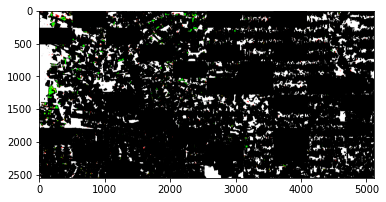

In [ ]:
main_compute_metrics(args = parse_params(metrics_params_amazon))

In [ ]:
metrics_params_amazon['save_result_text'] = False
metrics_params_amazon['Npoints'] = 10
main_compute_metrics_multi_threshold(args = parse_params(metrics_params_amazon))

Arguments for Compute Metrics Multi Threshold: 
Namespace(Npoints=10, area_avoided=69, buffer=True, buffer_dimension_in=2, buffer_dimension_out=4, checkpoint_dir='20201216_01_Resnet18_classification_Train_Amazon', compute_ndvi=False, data_t1_name='18_07_2016_image_R232_67_RO', data_t1_year='2016', data_t2_name='21_07_2017_image_R232_67_RO', data_t2_year='2017', data_type='.npy', dataset='Amazon_RO', dataset_main_path='Datasets/', defined_before=False, eliminate_regions=True, file='/root/.local/share/jupyter/runtime/kernel-d1d578bd-3752-401f-a779-480f925a3a03.json', fixed_tiles=True, horizontal_blocks=10, images_section='Organized/Images/', method_type='DeepLab', overlap=0.75, patches_dimension=64, phase='compute_metrics', reference_section='Organized/References/', reference_t1_name='PAST_REFERENCE_FOR_2017_EPSG32620_R232_67_RO', reference_t2_name='REFERENCE_2017_EPSG32620_R232_67_RO', results_dir='20201216_01_Resnet18_classification_Amazon_Test_Amazon', save_result_text=False, training

### Test on Cerrado (lower bound AMAZON -> CERRADO)

In [ ]:
test_params_cerrado['results_dir'] = test_dir_amazon_cerrado
test_params_cerrado['checkpoint_dir'] = train_dir_amazon
main_test(args = parse_params(test_params_cerrado))

Arguments for Test run: 
Namespace(area_avoided=69, aspp_rates=[3, 6, 12], base_architecture='resnet_v2_18', batch_norm_decay=0.9, batch_size=32, buffer=False, buffer_dimension_in=0, buffer_dimension_out=2, checkpoint_dir='20201216_01_Resnet18_classification_Train_Amazon', compute_ndvi=False, data_t1_name='18_08_2017_image_R220_63_MA', data_t1_year='2017', data_t2_name='21_08_2018_image_R220_63_MA', data_t2_year='2018', data_type='.npy', dataset='Cerrado_MA', dataset_main_path='Datasets/', defined_before=False, eliminate_regions=True, file='/root/.local/share/jupyter/runtime/kernel-d1d578bd-3752-401f-a779-480f925a3a03.json', fixed_tiles=True, horizontal_blocks=5, image_channels=7, images_section='Organized/Images/', loss_alpha=0.1, loss_gamma=2, loss_type='', method_type='DeepLab', num_classes=2, overlap=0.75, patches_dimension=64, phase='test', reference_section='Organized/References/', reference_t1_name='PAST_REFERENCE_FOR_2018_EPSG4674_R220_63_MA', reference_t2_name='REFERENCE_2018_


  0%|          | 0/300 [00:00<?, ?it/s]

 [*] Load with SUCCESS 
300



100%|██████████| 300/300 [00:05<00:00, 53.46it/s]


(1700, 1440)


Arguments for Compute Metrics: 
Namespace(area_avoided=69, buffer=True, buffer_dimension_in=0, buffer_dimension_out=2, checkpoint_dir='20201216_01_Resnet18_classification_Train_Cerrado', compute_ndvi=False, data_t1_name='18_08_2017_image_R220_63_MA', data_t1_year='2017', data_t2_name='21_08_2018_image_R220_63_MA', data_t2_year='2018', data_type='.npy', dataset='Cerrado_MA', dataset_main_path='Datasets/', defined_before=False, eliminate_regions=True, file='/root/.local/share/jupyter/runtime/kernel-d1d578bd-3752-401f-a779-480f925a3a03.json', fixed_tiles=True, horizontal_blocks=5, images_section='Organized/Images/', method_type='DeepLab', overlap=0.75, patches_dimension=64, phase='compute_metrics', reference_section='Organized/References/', reference_t1_name='PAST_REFERENCE_FOR_2018_EPSG4674_R220_63_MA', reference_t2_name='REFERENCE_2018_EPSG4674_R220_63_MA', results_dir='20201216_01_Resnet18_classification_Amazon_Test_Cerrado', save_result_text=True, training_type='classification', verti

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


53.569422286138014
Accuracy
[[94.62732826]]
Fscore
[[53.56942229]]
Recall
[[76.28067706]]
Precision
[[41.27924091]]
Confusion matrix
[[704023.  33913.]
 [  7413.  23840.]]
Alert_area
[[7.5082977]]
[94.62732826392472]
------------------------------------------------------------------------------------
Mean: 0 Accuracy: 94.627328% F1-Score: 53.569422% Recall: 76.280677% Precision: 41.279241% Area: 7.508298%

Std: 0 Accuracy: 0.00% F1-Score: 0.00% Recall: 0.00% Precision: 0.00% Area: 0.00%

------------------------------------------------------------------------------------


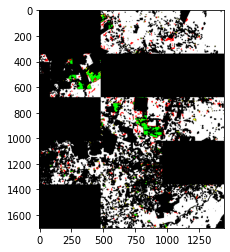

In [ ]:
metrics_params_cerrado['results_dir'] = test_dir_amazon_cerrado
main_compute_metrics(args = parse_params(metrics_params_cerrado))

In [ ]:
metrics_params_cerrado['save_result_text'] = False
metrics_params_cerrado['Npoints'] = 10
main_compute_metrics_multi_threshold(args = parse_params(metrics_params_cerrado))

Arguments for Compute Metrics Multi Threshold: 
Namespace(Npoints=10, area_avoided=69, buffer=True, buffer_dimension_in=0, buffer_dimension_out=2, checkpoint_dir='20201216_01_Resnet18_classification_Train_Cerrado', compute_ndvi=False, data_t1_name='18_08_2017_image_R220_63_MA', data_t1_year='2017', data_t2_name='21_08_2018_image_R220_63_MA', data_t2_year='2018', data_type='.npy', dataset='Cerrado_MA', dataset_main_path='Datasets/', defined_before=False, eliminate_regions=True, file='/root/.local/share/jupyter/runtime/kernel-d1d578bd-3752-401f-a779-480f925a3a03.json', fixed_tiles=True, horizontal_blocks=5, images_section='Organized/Images/', method_type='DeepLab', overlap=0.75, patches_dimension=64, phase='compute_metrics', reference_section='Organized/References/', reference_t1_name='PAST_REFERENCE_FOR_2018_EPSG4674_R220_63_MA', reference_t2_name='REFERENCE_2018_EPSG4674_R220_63_MA', results_dir='20201216_01_Resnet18_classification_Amazon_Test_Cerrado', save_result_text=False, training

## Cerrado

### Train on Cerrado

In [ ]:
train_params_cerrado['checkpoint_dir'] = train_dir_cerrado
main_train(args = parse_params(train_params_cerrado))

Arguments for Train: 
Namespace(aspp_rates=[3, 6, 12], balanced_tr=True, base_architecture='resnet_v2_18', batch_norm_decay=0.9, batch_size=32, beta1=0.9, buffer=True, checkpoint_dir='20201216_01_Resnet18_classification_Train_Cerrado', compute_ndvi=False, data_augmentation=True, data_type='.npy', dataset_main_path='Datasets/', defined_before=False, epochs=50, file='/root/.local/share/jupyter/runtime/kernel-d1d578bd-3752-401f-a779-480f925a3a03.json', fixed_tiles=True, image_channels=7, images_section='Organized/Images/', is_training=True, loss_alpha=0.1, loss_gamma=2, loss_type='', lr=0.0001, method_type='DeepLab', num_classes=2, overlap_s=0.75, overlap_t=0.75, patches_dimension=64, patience=10, phase='train', porcent_of_last_reference_in_actual_reference=100, porcent_of_positive_pixels_in_actual_reference_s=1, porcent_of_positive_pixels_in_actual_reference_t=1, reference_section='Organized/References/', resnet_type='simple', runs=1, save_intermediate_model=False, source_buffer_dimensio


  0%|          | 0/82 [00:00<?, ?it/s]

Sets dimensions before data augmentation
Source dimensions: 
(879, 4)
(267, 4)
Sets dimensions before balancing
Source dimensions: 
(2637, 5)
(801, 5)
(1760, 1488, 1)
(1760, 1488, 1)
epochs percentage: 0.0
lambda_p: 0.0



100%|██████████| 82/82 [00:12<00:00,  6.60it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

83
0 [Training loss: 0.046244, acc.: 84.70%, precission: 54.64%, recall: 91.06%, f1: 66.66%]
[*]Computing the validation loss...



100%|██████████| 25/25 [00:03<00:00,  7.80it/s]

  1%|          | 1/82 [00:00<00:11,  7.05it/s]


 0 [Validation loss: 0.042160, acc.: 85.51%,  precission: 44.46%, recall: 90.54%, f1: 58.71%]
---------------------------------------
[!] Best Validation F1 score: %.2f%% 58.7085617212166
---------------------------------------
epochs percentage: 0.02
lambda_p: 0.049958374957880025



100%|██████████| 82/82 [00:11<00:00,  7.02it/s]

  4%|▍         | 1/25 [00:00<00:02,  9.56it/s]

83
1 [Training loss: 0.019316, acc.: 94.52%, precission: 72.06%, recall: 96.61%, f1: 82.27%]
[*]Computing the validation loss...



100%|██████████| 25/25 [00:03<00:00,  8.21it/s]

  1%|          | 1/82 [00:00<00:11,  7.29it/s]


 1 [Validation loss: 0.045813, acc.: 93.78%,  precission: 69.05%, recall: 87.00%, f1: 76.63%]
---------------------------------------
[!] Best Validation F1 score: %.2f%% 76.63330073651443
---------------------------------------
epochs percentage: 0.04
lambda_p: 0.0996679946249559



100%|██████████| 82/82 [00:11<00:00,  7.07it/s]

  4%|▍         | 1/25 [00:00<00:03,  7.63it/s]

83
2 [Training loss: 0.014821, acc.: 95.64%, precission: 76.66%, recall: 97.72%, f1: 85.75%]
[*]Computing the validation loss...



100%|██████████| 25/25 [00:03<00:00,  8.29it/s]

  1%|          | 1/82 [00:00<00:11,  7.04it/s]


 2 [Validation loss: 0.038731, acc.: 91.96%,  precission: 59.98%, recall: 91.83%, f1: 71.61%]
epochs percentage: 0.06
lambda_p: 0.14888503362331806



100%|██████████| 82/82 [00:11<00:00,  7.10it/s]

  4%|▍         | 1/25 [00:00<00:02,  8.09it/s]

83
3 [Training loss: 0.012236, acc.: 96.28%, precission: 78.83%, recall: 98.22%, f1: 87.31%]
[*]Computing the validation loss...



100%|██████████| 25/25 [00:03<00:00,  8.27it/s]

  1%|          | 1/82 [00:00<00:12,  6.72it/s]


 3 [Validation loss: 0.041631, acc.: 90.00%,  precission: 55.76%, recall: 91.59%, f1: 68.13%]
epochs percentage: 0.08
lambda_p: 0.197375320224904



100%|██████████| 82/82 [00:11<00:00,  7.00it/s]

  4%|▍         | 1/25 [00:00<00:02,  8.35it/s]

83
4 [Training loss: 0.010330, acc.: 96.77%, precission: 81.17%, recall: 98.64%, f1: 88.94%]
[*]Computing the validation loss...



100%|██████████| 25/25 [00:03<00:00,  8.28it/s]

  1%|          | 1/82 [00:00<00:11,  7.25it/s]


 4 [Validation loss: 0.052361, acc.: 93.82%,  precission: 68.22%, recall: 87.03%, f1: 76.28%]
epochs percentage: 0.1
lambda_p: 0.2449186624037092



100%|██████████| 82/82 [00:11<00:00,  7.01it/s]

  4%|▍         | 1/25 [00:00<00:02,  8.31it/s]

83
5 [Training loss: 0.008776, acc.: 97.20%, precission: 82.88%, recall: 98.84%, f1: 90.05%]
[*]Computing the validation loss...



100%|██████████| 25/25 [00:03<00:00,  8.28it/s]

  1%|          | 1/82 [00:00<00:12,  6.46it/s]


 5 [Validation loss: 0.067402, acc.: 94.35%,  precission: 72.39%, recall: 83.73%, f1: 77.48%]
---------------------------------------
[!] Best Validation F1 score: %.2f%% 77.48074010776477
---------------------------------------
epochs percentage: 0.12
lambda_p: 0.2913126124515908



100%|██████████| 82/82 [00:11<00:00,  6.89it/s]

  4%|▍         | 1/25 [00:00<00:02,  8.04it/s]

83
6 [Training loss: 0.007605, acc.: 97.55%, precission: 85.24%, recall: 99.12%, f1: 91.59%]
[*]Computing the validation loss...



100%|██████████| 25/25 [00:03<00:00,  8.14it/s]

  1%|          | 1/82 [00:00<00:11,  7.36it/s]


 6 [Validation loss: 0.100392, acc.: 93.55%,  precission: 70.82%, recall: 79.62%, f1: 74.57%]
epochs percentage: 0.14
lambda_p: 0.3363755443363323



100%|██████████| 82/82 [00:11<00:00,  7.02it/s]

  4%|▍         | 1/25 [00:00<00:03,  7.18it/s]

83
7 [Training loss: 0.006372, acc.: 97.89%, precission: 86.42%, recall: 99.29%, f1: 92.34%]
[*]Computing the validation loss...



100%|██████████| 25/25 [00:03<00:00,  8.10it/s]

  1%|          | 1/82 [00:00<00:10,  7.50it/s]


 7 [Validation loss: 0.108016, acc.: 95.26%,  precission: 80.83%, recall: 76.77%, f1: 78.22%]
---------------------------------------
[!] Best Validation F1 score: %.2f%% 78.22137990769757
---------------------------------------
epochs percentage: 0.16
lambda_p: 0.379948962255225



100%|██████████| 82/82 [00:11<00:00,  6.84it/s]

  4%|▍         | 1/25 [00:00<00:02,  8.55it/s]

83
8 [Training loss: 0.005347, acc.: 98.24%, precission: 88.56%, recall: 99.41%, f1: 93.63%]
[*]Computing the validation loss...



100%|██████████| 25/25 [00:03<00:00,  8.33it/s]

  1%|          | 1/82 [00:00<00:10,  7.45it/s]


 8 [Validation loss: 0.107192, acc.: 94.58%,  precission: 75.80%, recall: 78.70%, f1: 76.98%]
epochs percentage: 0.18
lambda_p: 0.4218990052500078



100%|██████████| 82/82 [00:11<00:00,  6.99it/s]

  4%|▍         | 1/25 [00:00<00:03,  7.76it/s]

83
9 [Training loss: 0.004547, acc.: 98.49%, precission: 89.91%, recall: 99.51%, f1: 94.42%]
[*]Computing the validation loss...



100%|██████████| 25/25 [00:02<00:00,  8.35it/s]

  1%|          | 1/82 [00:00<00:12,  6.35it/s]


 9 [Validation loss: 0.096787, acc.: 93.92%,  precission: 71.34%, recall: 82.43%, f1: 76.28%]
epochs percentage: 0.2
lambda_p: 0.4621171572600098



100%|██████████| 82/82 [00:11<00:00,  7.13it/s]

  4%|▍         | 1/25 [00:00<00:02,  9.42it/s]

83
10 [Training loss: 0.004047, acc.: 98.64%, precission: 90.94%, recall: 99.58%, f1: 95.02%]
[*]Computing the validation loss...



100%|██████████| 25/25 [00:02<00:00,  8.39it/s]

  1%|          | 1/82 [00:00<00:10,  7.49it/s]


 10 [Validation loss: 0.115310, acc.: 93.63%,  precission: 70.58%, recall: 79.28%, f1: 74.48%]
epochs percentage: 0.22
lambda_p: 0.5005202111902354



100%|██████████| 82/82 [00:11<00:00,  7.17it/s]

  4%|▍         | 1/25 [00:00<00:02,  9.72it/s]

83
11 [Training loss: 0.003236, acc.: 98.90%, precission: 92.37%, recall: 99.70%, f1: 95.87%]
[*]Computing the validation loss...



100%|██████████| 25/25 [00:02<00:00,  8.43it/s]

  1%|          | 1/82 [00:00<00:11,  7.26it/s]


 11 [Validation loss: 0.157233, acc.: 94.83%,  precission: 80.11%, recall: 75.30%, f1: 77.54%]
epochs percentage: 0.24
lambda_p: 0.5370495669980351



100%|██████████| 82/82 [00:11<00:00,  7.18it/s]

  4%|▍         | 1/25 [00:00<00:02,  9.66it/s]

83
12 [Training loss: 0.003380, acc.: 98.87%, precission: 92.48%, recall: 99.67%, f1: 95.90%]
[*]Computing the validation loss...



100%|██████████| 25/25 [00:02<00:00,  8.63it/s]

  1%|          | 1/82 [00:00<00:10,  7.78it/s]


 12 [Validation loss: 0.152297, acc.: 94.32%,  precission: 75.93%, recall: 75.25%, f1: 75.41%]
epochs percentage: 0.26
lambda_p: 0.5716699660851172



100%|██████████| 82/82 [00:11<00:00,  7.21it/s]

  4%|▍         | 1/25 [00:00<00:02,  8.58it/s]

83
13 [Training loss: 0.002803, acc.: 99.06%, precission: 93.36%, recall: 99.75%, f1: 96.42%]
[*]Computing the validation loss...



100%|██████████| 25/25 [00:02<00:00,  8.51it/s]

  1%|          | 1/82 [00:00<00:12,  6.71it/s]


 13 [Validation loss: 0.201220, acc.: 93.73%,  precission: 75.79%, recall: 74.38%, f1: 74.60%]
epochs percentage: 0.28
lambda_p: 0.6043677771171636



100%|██████████| 82/82 [00:11<00:00,  7.26it/s]

  4%|▍         | 1/25 [00:00<00:02,  8.79it/s]

83
14 [Training loss: 0.002230, acc.: 99.25%, precission: 94.56%, recall: 99.82%, f1: 97.10%]
[*]Computing the validation loss...



100%|██████████| 25/25 [00:02<00:00,  8.53it/s]

  1%|          | 1/82 [00:00<00:09,  8.15it/s]


 14 [Validation loss: 0.241569, acc.: 94.16%,  precission: 78.44%, recall: 69.90%, f1: 73.33%]
epochs percentage: 0.3
lambda_p: 0.6351489523872873



100%|██████████| 82/82 [00:11<00:00,  7.21it/s]

  4%|▍         | 1/25 [00:00<00:02,  8.33it/s]

83
15 [Training loss: 0.001956, acc.: 99.35%, precission: 95.14%, recall: 99.85%, f1: 97.42%]
[*]Computing the validation loss...



100%|██████████| 25/25 [00:02<00:00,  8.39it/s]

  1%|          | 1/82 [00:00<00:10,  7.56it/s]


 15 [Validation loss: 0.340643, acc.: 93.49%,  precission: 81.02%, recall: 69.22%, f1: 74.11%]
epochs percentage: 0.32
lambda_p: 0.6640367702678489



100%|██████████| 82/82 [00:11<00:00,  7.25it/s]

  4%|▍         | 1/25 [00:00<00:02,  9.82it/s]

83
16 [Training loss: 0.001676, acc.: 99.44%, precission: 96.05%, recall: 99.86%, f1: 97.91%]
[*]Computing the validation loss...



100%|██████████| 25/25 [00:02<00:00,  8.62it/s]

  1%|          | 1/82 [00:00<00:11,  7.00it/s]


 16 [Validation loss: 0.213315, acc.: 94.54%,  precission: 77.76%, recall: 72.75%, f1: 74.09%]
epochs percentage: 0.34
lambda_p: 0.6910694698329305



100%|██████████| 82/82 [00:11<00:00,  7.25it/s]

  4%|▍         | 1/25 [00:00<00:02,  8.15it/s]

83
17 [Training loss: 0.001582, acc.: 99.47%, precission: 96.16%, recall: 99.86%, f1: 97.97%]
[*]Computing the validation loss...



100%|██████████| 25/25 [00:02<00:00,  8.43it/s]

  1%|          | 1/82 [00:00<00:11,  7.04it/s]


 17 [Validation loss: 0.234087, acc.: 94.55%,  precission: 80.53%, recall: 71.13%, f1: 75.34%]
epochs percentage: 0.36
lambda_p: 0.7162978701990246



100%|██████████| 82/82 [00:11<00:00,  7.21it/s]

  4%|▍         | 1/25 [00:00<00:02,  8.82it/s]

83
18 [Training loss: 0.001433, acc.: 99.52%, precission: 96.55%, recall: 99.90%, f1: 98.19%]
[*]Computing the validation loss...



100%|██████████| 25/25 [00:02<00:00,  8.66it/s]



 18 [Validation loss: 0.203651, acc.: 94.71%,  precission: 77.08%, recall: 75.58%, f1: 75.84%]
Patience limit reachead. Exiting training...
---------------------------------------
Training ended
[!] Best Validation F1 score: %.2f%% 78.22137990769757
Saving the best model
Checkpoint Saved with SUCCESS!


### Test on Cerrado (upper bound CERRADO -> CERRADO)

In [ ]:
test_params_cerrado['checkpoint_dir'] = train_dir_cerrado
test_params_cerrado['results_dir'] = test_dir_cerrado_cerrado
main_test(args = parse_params(test_params_cerrado))

Arguments for Test run: 
Namespace(area_avoided=69, aspp_rates=[3, 6, 12], base_architecture='resnet_v2_18', batch_norm_decay=0.9, batch_size=32, buffer=False, buffer_dimension_in=0, buffer_dimension_out=2, checkpoint_dir='20201216_01_Resnet18_classification_Train_Cerrado', compute_ndvi=False, data_t1_name='18_08_2017_image_R220_63_MA', data_t1_year='2017', data_t2_name='21_08_2018_image_R220_63_MA', data_t2_year='2018', data_type='.npy', dataset='Cerrado_MA', dataset_main_path='Datasets/', defined_before=False, eliminate_regions=True, file='/root/.local/share/jupyter/runtime/kernel-d1d578bd-3752-401f-a779-480f925a3a03.json', fixed_tiles=True, horizontal_blocks=5, image_channels=7, images_section='Organized/Images/', loss_alpha=0.1, loss_gamma=2, loss_type='', method_type='DeepLab', num_classes=2, overlap=0.75, patches_dimension=64, phase='test', reference_section='Organized/References/', reference_t1_name='PAST_REFERENCE_FOR_2018_EPSG4674_R220_63_MA', reference_t2_name='REFERENCE_2018


  0%|          | 0/300 [00:00<?, ?it/s]

 [*] Load with SUCCESS 
300



100%|██████████| 300/300 [00:05<00:00, 51.71it/s]

(1700, 1440)


Arguments for Compute Metrics: 
Namespace(Npoints=10, area_avoided=69, buffer=True, buffer_dimension_in=0, buffer_dimension_out=2, checkpoint_dir='20201216_01_Resnet18_classification_Train_Cerrado', compute_ndvi=False, data_t1_name='18_08_2017_image_R220_63_MA', data_t1_year='2017', data_t2_name='21_08_2018_image_R220_63_MA', data_t2_year='2018', data_type='.npy', dataset='Cerrado_MA', dataset_main_path='Datasets/', defined_before=False, eliminate_regions=True, file='/root/.local/share/jupyter/runtime/kernel-d1d578bd-3752-401f-a779-480f925a3a03.json', fixed_tiles=True, horizontal_blocks=5, images_section='Organized/Images/', method_type='DeepLab', overlap=0.75, patches_dimension=64, phase='compute_metrics', reference_section='Organized/References/', reference_t1_name='PAST_REFERENCE_FOR_2018_EPSG4674_R220_63_MA', reference_t2_name='REFERENCE_2018_EPSG4674_R220_63_MA', results_dir='20201216_01_Resnet18_classification_Cerrado_Test_Cerrado', save_result_text=True, training_type='classific

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


84.22667982023458
Accuracy
[[98.69387914]]
Fscore
[[84.22667982]]
Recall
[[88.29284307]]
Precision
[[80.51854735]]
Confusion matrix
[[734248.   6507.]
 [  3566.  26894.]]
Alert_area
[[4.33095829]]
[98.69387913876156]
------------------------------------------------------------------------------------
Mean: 0 Accuracy: 98.693879% F1-Score: 84.226680% Recall: 88.292843% Precision: 80.518547% Area: 4.330958%

Std: 0 Accuracy: 0.00% F1-Score: 0.00% Recall: 0.00% Precision: 0.00% Area: 0.00%

------------------------------------------------------------------------------------


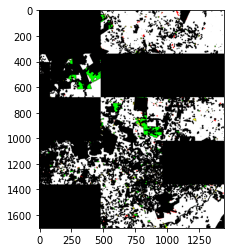

In [ ]:
metrics_params_cerrado['save_result_text'] = True
metrics_params_cerrado['results_dir'] = test_dir_cerrado_cerrado
main_compute_metrics(args = parse_params(metrics_params_cerrado))

In [ ]:
metrics_params_cerrado['save_result_text'] = False
metrics_params_cerrado['results_dir'] = test_dir_cerrado_cerrado
metrics_params_cerrado['Npoints'] = 10
main_compute_metrics_multi_threshold(args = parse_params(metrics_params_cerrado))

Arguments for Compute Metrics Multi Threshold: 
Namespace(Npoints=10, area_avoided=69, buffer=True, buffer_dimension_in=0, buffer_dimension_out=2, checkpoint_dir='20201216_01_Resnet18_classification_Train_Cerrado', compute_ndvi=False, data_t1_name='18_08_2017_image_R220_63_MA', data_t1_year='2017', data_t2_name='21_08_2018_image_R220_63_MA', data_t2_year='2018', data_type='.npy', dataset='Cerrado_MA', dataset_main_path='Datasets/', defined_before=False, eliminate_regions=True, file='/root/.local/share/jupyter/runtime/kernel-d1d578bd-3752-401f-a779-480f925a3a03.json', fixed_tiles=True, horizontal_blocks=5, images_section='Organized/Images/', method_type='DeepLab', overlap=0.75, patches_dimension=64, phase='compute_metrics', reference_section='Organized/References/', reference_t1_name='PAST_REFERENCE_FOR_2018_EPSG4674_R220_63_MA', reference_t2_name='REFERENCE_2018_EPSG4674_R220_63_MA', results_dir='20201216_01_Resnet18_classification_Cerrado_Test_Cerrado', save_result_text=False, trainin

### Test on Amazon (lower bound CERRADO -> AMAZON)


In [ ]:
test_params_amazon['results_dir'] = test_dir_cerrado_amazon
test_params_amazon['checkpoint_dir'] = train_dir_cerrado
main_test(args = parse_params(test_params_amazon))

Arguments for Test run: 
Namespace(area_avoided=69, aspp_rates=[3, 6, 12], base_architecture='resnet_v2_18', batch_norm_decay=0.9, batch_size=32, buffer=False, buffer_dimension_in=0, buffer_dimension_out=2, checkpoint_dir='20201216_01_Resnet18_classification_Train_Cerrado', compute_ndvi=False, data_t1_name='18_07_2016_image_R232_67_RO', data_t1_year='2016', data_t2_name='21_07_2017_image_R232_67_RO', data_t2_year='2017', data_type='.npy', dataset='Amazon_RO', dataset_main_path='Datasets/', defined_before=False, eliminate_regions=True, file='/root/.local/share/jupyter/runtime/kernel-d1d578bd-3752-401f-a779-480f925a3a03.json', fixed_tiles=True, horizontal_blocks=10, image_channels=7, images_section='Organized/Images/', loss_alpha=0.1, loss_gamma=2, loss_type='', method_type='DeepLab', num_classes=2, overlap=0.75, patches_dimension=64, phase='test', reference_section='Organized/References/', reference_t1_name='PAST_REFERENCE_FOR_2017_EPSG32620_R232_67_RO', reference_t2_name='REFERENCE_201


  0%|          | 1/1600 [00:00<04:20,  6.13it/s]

1600



100%|██████████| 1600/1600 [00:28<00:00, 56.70it/s]


(2550, 5120)


Arguments for Compute Metrics: 
Namespace(Npoints=10, area_avoided=69, buffer=True, buffer_dimension_in=2, buffer_dimension_out=4, checkpoint_dir='20201216_01_Resnet18_classification_Train_Amazon', compute_ndvi=False, data_t1_name='18_07_2016_image_R232_67_RO', data_t1_year='2016', data_t2_name='21_07_2017_image_R232_67_RO', data_t2_year='2017', data_type='.npy', dataset='Amazon_RO', dataset_main_path='Datasets/', defined_before=False, eliminate_regions=True, file='/root/.local/share/jupyter/runtime/kernel-d1d578bd-3752-401f-a779-480f925a3a03.json', fixed_tiles=True, horizontal_blocks=10, images_section='Organized/Images/', method_type='DeepLab', overlap=0.75, patches_dimension=64, phase='compute_metrics', reference_section='Organized/References/', reference_t1_name='PAST_REFERENCE_FOR_2017_EPSG32620_R232_67_RO', reference_t2_name='REFERENCE_2017_EPSG32620_R232_67_RO', results_dir='20201216_01_Resnet18_classification_Cerrado_Test_Amazon', save_result_text=True, training_type='classific

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


59.63302017508029
Accuracy
[[96.83230532]]
Fscore
[[59.63302018]]
Recall
[[49.59831599]]
Precision
[[74.75802241]]
Confusion matrix
[[1503465.   12570.]
 [  37831.   37228.]]
Alert_area
[[3.12979623]]
[96.83230531948458]
------------------------------------------------------------------------------------
Mean: 0 Accuracy: 96.832305% F1-Score: 59.633020% Recall: 49.598316% Precision: 74.758022% Area: 3.129796%

Std: 0 Accuracy: 0.00% F1-Score: 0.00% Recall: 0.00% Precision: 0.00% Area: 0.00%

------------------------------------------------------------------------------------


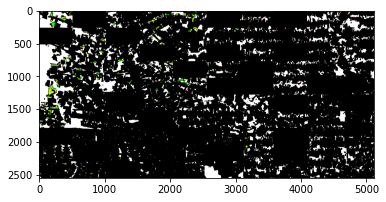

In [ ]:
metrics_params_amazon['results_dir'] = test_dir_cerrado_amazon
metrics_params_amazon['save_result_text'] = True
main_compute_metrics(args = parse_params(metrics_params_amazon))

In [ ]:
metrics_params_amazon['save_result_text'] = False
metrics_params_amazon['Npoints'] = 10  
main_compute_metrics_multi_threshold(args = parse_params(metrics_params_amazon))

Arguments for Compute Metrics Multi Threshold: 
Namespace(Npoints=10, area_avoided=69, buffer=True, buffer_dimension_in=2, buffer_dimension_out=4, checkpoint_dir='20201216_01_Resnet18_classification_Train_Amazon', compute_ndvi=False, data_t1_name='18_07_2016_image_R232_67_RO', data_t1_year='2016', data_t2_name='21_07_2017_image_R232_67_RO', data_t2_year='2017', data_type='.npy', dataset='Amazon_RO', dataset_main_path='Datasets/', defined_before=False, eliminate_regions=True, file='/root/.local/share/jupyter/runtime/kernel-d1d578bd-3752-401f-a779-480f925a3a03.json', fixed_tiles=True, horizontal_blocks=10, images_section='Organized/Images/', method_type='DeepLab', overlap=0.75, patches_dimension=64, phase='compute_metrics', reference_section='Organized/References/', reference_t1_name='PAST_REFERENCE_FOR_2017_EPSG32620_R232_67_RO', reference_t2_name='REFERENCE_2017_EPSG32620_R232_67_RO', results_dir='20201216_01_Resnet18_classification_Cerrado_Test_Amazon', save_result_text=False, trainin

## Domain Adaptation - S:Amazon T:Cerrado

In [ ]:
train_dir_da_amazon_to_cerrado = '20201216_02_Resnet18_DA_Source_Amazon_Target_Cerrado'
train_dir_da_cerrado_to_amazon = '20201216_02_Resnet18_DA_Source_Cerrado_Target_Amazon'

test_dir_da_target_cerrado = '20201216_02_Resnet18_DA_Test_Source_Amazon_Target_Cerrado'
test_dir_da_target_amazon = '20201216_02_Resnet18_DA_Test_Source_Cerrado_Target_Amazon'

train_params_amazon['training_type'] = 'domain_adaptation'
train_params_amazon['checkpoint_dir'] = train_dir_da_amazon_to_cerrado

main_train(args = parse_params(train_params_amazon))

Arguments for Train: 
Namespace(aspp_rates=[3, 6, 12], balanced_tr=True, base_architecture='resnet_v2_18', batch_norm_decay=0.9, batch_size=32, beta1=0.9, buffer=True, checkpoint_dir='20201216_02_Resnet18_DA_Source_Amazon_Target_Cerrado', compute_ndvi=False, data_augmentation=True, data_type='.npy', dataset_main_path='Datasets/', defined_before=False, epochs=50, file='/root/.local/share/jupyter/runtime/kernel-d1d578bd-3752-401f-a779-480f925a3a03.json', fixed_tiles=True, image_channels=7, images_section='Organized/Images/', is_training=True, loss_alpha=0.1, loss_gamma=2, loss_type='', lr=0.0001, method_type='DeepLab', num_classes=2, overlap_s=0.75, overlap_t=0.75, patches_dimension=64, patience=10, phase='train', porcent_of_last_reference_in_actual_reference=100, porcent_of_positive_pixels_in_actual_reference_s=1, porcent_of_positive_pixels_in_actual_reference_t=1, reference_section='Organized/References/', resnet_type='simple', runs=1, save_intermediate_model=False, source_buffer_dimen

  0%|          | 0/339 [00:00<?, ?it/s]

epochs percentage: 0.0
lambda_p: 0.0


  0%|          | 0/150 [00:00<?, ?it/s]

340
0 [Training loss: 0.068188, acc.: 74.42%, precission: 42.61%, recall: 93.65%, f1: 57.44%, Dr loss: 0.425935]
[*]Computing the validation loss...


  1%|          | 2/339 [00:00<00:29, 11.35it/s]


 0 [Validation loss: 0.131044, acc.: 84.84%,  precission: 44.91%, recall: 77.61%, f1: 56.33%, DrV loss: 0.004123]

epochs percentage: 0.02
lambda_p: 0.049958374957880025


  1%|▏         | 2/150 [00:00<00:07, 18.60it/s]

340
1 [Training loss: 0.056382, acc.: 80.61%, precission: 48.29%, recall: 94.60%, f1: 63.08%, Dr loss: 0.837472]
[*]Computing the validation loss...


  1%|          | 2/339 [00:00<00:26, 12.78it/s]


 1 [Validation loss: 0.082666, acc.: 84.19%,  precission: 43.66%, recall: 83.54%, f1: 57.02%, DrV loss: 0.003879]

epochs percentage: 0.04
lambda_p: 0.0996679946249559


  1%|▏         | 2/150 [00:00<00:07, 18.97it/s]

340
2 [Training loss: 0.044563, acc.: 84.65%, precission: 53.92%, recall: 96.19%, f1: 68.45%, Dr loss: 0.706958]
[*]Computing the validation loss...


  1%|          | 2/339 [00:00<00:28, 11.64it/s]


 2 [Validation loss: 0.125105, acc.: 87.91%,  precission: 51.54%, recall: 77.21%, f1: 61.38%, DrV loss: 0.004529]

epochs percentage: 0.06
lambda_p: 0.14888503362331806


  1%|▏         | 2/150 [00:00<00:08, 17.51it/s]

340
3 [Training loss: 0.036024, acc.: 87.78%, precission: 59.45%, recall: 97.14%, f1: 73.26%, Dr loss: 0.689028]
[*]Computing the validation loss...


  1%|          | 2/339 [00:00<00:28, 11.90it/s]


 3 [Validation loss: 0.098525, acc.: 81.10%,  precission: 38.59%, recall: 82.34%, f1: 52.07%, DrV loss: 0.004388]

epochs percentage: 0.08
lambda_p: 0.197375320224904


  1%|▏         | 2/150 [00:00<00:07, 18.90it/s]

340
4 [Training loss: 0.031242, acc.: 89.64%, precission: 63.34%, recall: 97.37%, f1: 76.28%, Dr loss: 0.691900]
[*]Computing the validation loss...


  1%|          | 2/339 [00:00<00:24, 13.50it/s]


 4 [Validation loss: 0.116677, acc.: 85.45%,  precission: 46.04%, recall: 80.41%, f1: 58.21%, DrV loss: 0.004576]

epochs percentage: 0.1
lambda_p: 0.2449186624037092


  2%|▏         | 3/150 [00:00<00:08, 18.20it/s]

340
5 [Training loss: 0.024810, acc.: 91.90%, precission: 69.04%, recall: 98.00%, f1: 80.55%, Dr loss: 0.689714]
[*]Computing the validation loss...


  0%|          | 1/339 [00:00<00:35,  9.59it/s]


 5 [Validation loss: 0.139669, acc.: 85.12%,  precission: 45.15%, recall: 79.10%, f1: 56.99%, DrV loss: 0.004238]

---------------------------------------
[!] Best Validation F1 score: %.2f%% 56.990468334410046
---------------------------------------
epochs percentage: 0.12
lambda_p: 0.2913126124515908


  1%|▏         | 2/150 [00:00<00:09, 15.64it/s]

340
6 [Training loss: 0.019712, acc.: 93.69%, precission: 73.87%, recall: 98.48%, f1: 84.04%, Dr loss: 0.687670]
[*]Computing the validation loss...


  1%|          | 2/339 [00:00<00:27, 12.27it/s]


 6 [Validation loss: 0.154784, acc.: 86.41%,  precission: 47.89%, recall: 77.38%, f1: 58.71%, DrV loss: 0.004377]

---------------------------------------
[!] Best Validation F1 score: %.2f%% 58.7103314405304
---------------------------------------
epochs percentage: 0.14
lambda_p: 0.3363755443363323


  2%|▏         | 3/150 [00:00<00:07, 19.20it/s]

340
7 [Training loss: 0.021046, acc.: 93.29%, precission: 73.27%, recall: 98.23%, f1: 83.50%, Dr loss: 0.688614]
[*]Computing the validation loss...


  1%|          | 2/339 [00:00<00:28, 11.98it/s]


 7 [Validation loss: 0.125163, acc.: 84.06%,  precission: 42.47%, recall: 80.30%, f1: 55.13%, DrV loss: 0.004293]

epochs percentage: 0.16
lambda_p: 0.379948962255225


  1%|▏         | 2/150 [00:00<00:08, 17.37it/s]

340
8 [Training loss: 0.017835, acc.: 94.39%, precission: 76.24%, recall: 98.49%, f1: 85.63%, Dr loss: 0.687055]
[*]Computing the validation loss...


  1%|          | 2/339 [00:00<00:27, 12.06it/s]


 8 [Validation loss: 0.191722, acc.: 87.12%,  precission: 49.50%, recall: 74.16%, f1: 58.86%, DrV loss: 0.004392]

---------------------------------------
[!] Best Validation F1 score: %.2f%% 58.86407285545165
---------------------------------------
epochs percentage: 0.18
lambda_p: 0.4218990052500078


  1%|▏         | 2/150 [00:00<00:08, 17.30it/s]

340
9 [Training loss: 0.014474, acc.: 95.46%, precission: 79.67%, recall: 98.89%, f1: 88.03%, Dr loss: 0.690816]
[*]Computing the validation loss...


  1%|          | 2/339 [00:00<00:30, 11.04it/s]


 9 [Validation loss: 0.236142, acc.: 89.26%,  precission: 55.23%, recall: 67.24%, f1: 60.19%, DrV loss: 0.004395]

---------------------------------------
[!] Best Validation F1 score: %.2f%% 60.18958751133979
---------------------------------------
epochs percentage: 0.2
lambda_p: 0.4621171572600098


  1%|▏         | 2/150 [00:00<00:07, 19.09it/s]

340
10 [Training loss: 0.013809, acc.: 95.69%, precission: 80.64%, recall: 98.90%, f1: 88.63%, Dr loss: 0.692410]
[*]Computing the validation loss...


  1%|          | 2/339 [00:00<00:26, 12.74it/s]


 10 [Validation loss: 0.281846, acc.: 86.95%,  precission: 48.78%, recall: 66.71%, f1: 55.88%, DrV loss: 0.004163]

epochs percentage: 0.22
lambda_p: 0.5005202111902354


  1%|▏         | 2/150 [00:00<00:08, 17.25it/s]

340
11 [Training loss: 0.018134, acc.: 94.41%, precission: 76.95%, recall: 98.48%, f1: 85.95%, Dr loss: 0.694639]
[*]Computing the validation loss...


  1%|          | 2/339 [00:00<00:30, 11.07it/s]


 11 [Validation loss: 0.161974, acc.: 78.01%,  precission: 34.31%, recall: 77.38%, f1: 47.09%, DrV loss: 0.004649]

epochs percentage: 0.24
lambda_p: 0.5370495669980351


  1%|▏         | 2/150 [00:00<00:08, 18.00it/s]

340
12 [Training loss: 0.013836, acc.: 95.70%, precission: 81.27%, recall: 98.89%, f1: 88.91%, Dr loss: 0.688525]
[*]Computing the validation loss...


  0%|          | 1/339 [00:00<00:35,  9.65it/s]


 12 [Validation loss: 0.260285, acc.: 88.71%,  precission: 53.47%, recall: 68.18%, f1: 59.55%, DrV loss: 0.004194]

epochs percentage: 0.26
lambda_p: 0.5716699660851172


  1%|▏         | 2/150 [00:00<00:07, 18.94it/s]

340
13 [Training loss: 0.009154, acc.: 97.16%, precission: 86.05%, recall: 99.27%, f1: 92.07%, Dr loss: 0.690406]
[*]Computing the validation loss...


  1%|          | 2/339 [00:00<00:32, 10.39it/s]


 13 [Validation loss: 0.333219, acc.: 89.95%,  precission: 58.64%, recall: 64.05%, f1: 60.66%, DrV loss: 0.004232]

---------------------------------------
[!] Best Validation F1 score: %.2f%% 60.6641002517326
---------------------------------------
epochs percentage: 0.28
lambda_p: 0.6043677771171636


  1%|▏         | 2/150 [00:00<00:08, 17.49it/s]

340
14 [Training loss: 0.008574, acc.: 97.34%, precission: 86.77%, recall: 99.32%, f1: 92.53%, Dr loss: 0.688064]
[*]Computing the validation loss...


  1%|          | 2/339 [00:00<00:28, 11.97it/s]


 14 [Validation loss: 0.260646, acc.: 88.56%,  precission: 53.41%, recall: 66.82%, f1: 58.89%, DrV loss: 0.004479]

epochs percentage: 0.3
lambda_p: 0.6351489523872873


  1%|▏         | 2/150 [00:00<00:07, 18.79it/s]

340
15 [Training loss: 0.008412, acc.: 97.42%, precission: 87.35%, recall: 99.30%, f1: 92.84%, Dr loss: 0.687809]
[*]Computing the validation loss...


  1%|          | 2/339 [00:00<00:26, 12.65it/s]


 15 [Validation loss: 0.304360, acc.: 89.33%,  precission: 56.03%, recall: 64.57%, f1: 59.49%, DrV loss: 0.004548]

epochs percentage: 0.32
lambda_p: 0.6640367702678489


  2%|▏         | 3/150 [00:00<00:07, 20.42it/s]

340
16 [Training loss: 0.008632, acc.: 97.38%, precission: 87.47%, recall: 99.33%, f1: 92.82%, Dr loss: 0.686616]
[*]Computing the validation loss...


  1%|          | 2/339 [00:00<00:27, 12.11it/s]


 16 [Validation loss: 0.298458, acc.: 89.05%,  precission: 54.78%, recall: 68.53%, f1: 60.30%, DrV loss: 0.004313]

epochs percentage: 0.34
lambda_p: 0.6910694698329305


  1%|▏         | 2/150 [00:00<00:09, 16.00it/s]

340
17 [Training loss: 0.007477, acc.: 97.74%, precission: 88.63%, recall: 99.43%, f1: 93.56%, Dr loss: 0.687022]
[*]Computing the validation loss...


  0%|          | 1/339 [00:00<00:34,  9.75it/s]


 17 [Validation loss: 0.232512, acc.: 85.49%,  precission: 45.26%, recall: 71.59%, f1: 55.08%, DrV loss: 0.004405]

epochs percentage: 0.36
lambda_p: 0.7162978701990246


  1%|▏         | 2/150 [00:00<00:08, 18.48it/s]

340
18 [Training loss: 0.010848, acc.: 96.76%, precission: 85.06%, recall: 99.05%, f1: 91.28%, Dr loss: 0.689616]
[*]Computing the validation loss...


  0%|          | 1/339 [00:00<00:33,  9.95it/s]


 18 [Validation loss: 0.151248, acc.: 79.25%,  precission: 34.91%, recall: 74.41%, f1: 47.08%, DrV loss: 0.004482]

epochs percentage: 0.38
lambda_p: 0.7397830512740042


  1%|▏         | 2/150 [00:00<00:08, 17.48it/s]

340
19 [Training loss: 0.044491, acc.: 85.44%, precission: 57.56%, recall: 95.67%, f1: 70.70%, Dr loss: 0.679956]
[*]Computing the validation loss...


  1%|          | 2/339 [00:00<00:27, 12.09it/s]


 19 [Validation loss: 0.113917, acc.: 83.91%,  precission: 42.62%, recall: 80.47%, f1: 55.36%, DrV loss: 0.003981]

epochs percentage: 0.4
lambda_p: 0.7615941559557646


  1%|▏         | 2/150 [00:00<00:08, 17.35it/s]

340
20 [Training loss: 0.017854, acc.: 94.48%, precission: 76.51%, recall: 98.34%, f1: 85.74%, Dr loss: 0.687506]
[*]Computing the validation loss...


  1%|          | 2/339 [00:00<00:31, 10.66it/s]


 20 [Validation loss: 0.229759, acc.: 86.77%,  precission: 48.01%, recall: 67.15%, f1: 55.56%, DrV loss: 0.004267]

epochs percentage: 0.42
lambda_p: 0.7818063576087741


  1%|▏         | 2/150 [00:00<00:08, 18.35it/s]

340
21 [Training loss: 0.013943, acc.: 95.75%, precission: 80.95%, recall: 98.83%, f1: 88.74%, Dr loss: 0.688883]
[*]Computing the validation loss...


  1%|          | 2/339 [00:00<00:31, 10.78it/s]


 21 [Validation loss: 0.155299, acc.: 84.19%,  precission: 42.50%, recall: 73.75%, f1: 53.52%, DrV loss: 0.004446]

epochs percentage: 0.44
lambda_p: 0.8004990217606296


  1%|▏         | 2/150 [00:00<00:07, 18.55it/s]

340
22 [Training loss: 0.009023, acc.: 97.26%, precission: 86.55%, recall: 99.28%, f1: 92.36%, Dr loss: 0.685341]
[*]Computing the validation loss...


  1%|          | 2/339 [00:00<00:28, 11.74it/s]


 22 [Validation loss: 0.255383, acc.: 88.75%,  precission: 53.77%, recall: 69.07%, f1: 60.04%, DrV loss: 0.004311]

epochs percentage: 0.46
lambda_p: 0.8177540779702877


  1%|▏         | 2/150 [00:00<00:09, 15.62it/s]

340
23 [Training loss: 0.010133, acc.: 96.88%, precission: 85.13%, recall: 99.20%, f1: 91.46%, Dr loss: 0.686229]
[*]Computing the validation loss...


  1%|          | 2/339 [00:00<00:28, 11.64it/s]


 23 [Validation loss: 0.325103, acc.: 89.11%,  precission: 55.72%, recall: 66.83%, f1: 60.10%, DrV loss: 0.004515]

epochs percentage: 0.48
lambda_p: 0.8336546070121553


  1%|▏         | 2/150 [00:00<00:08, 18.47it/s]

340
24 [Training loss: 0.009643, acc.: 97.08%, precission: 86.03%, recall: 99.21%, f1: 92.01%, Dr loss: 0.687354]
[*]Computing the validation loss...


100%|██████████| 150/150 [00:08<00:00, 17.42it/s]



 24 [Validation loss: 0.296050, acc.: 89.27%,  precission: 55.89%, recall: 66.75%, f1: 60.34%, DrV loss: 0.004131]

Patience limit reachead. Exiting training...
---------------------------------------
Training ended
[!] Best Validation F1 score: %.2f%% 60.6641002517326
Saving the best model
Checkpoint Saved with SUCCESS!


In [ ]:
test_params_cerrado['results_dir'] = test_dir_da_target_cerrado
test_params_cerrado['checkpoint_dir'] = train_dir_da_amazon_to_cerrado
main_test(args = parse_params(test_params_cerrado))

Arguments for Test run: 
Namespace(area_avoided=69, aspp_rates=[3, 6, 12], base_architecture='resnet_v2_18', batch_norm_decay=0.9, batch_size=32, buffer=False, buffer_dimension_in=0, buffer_dimension_out=2, checkpoint_dir='20201216_02_Resnet18_DA_Source_Amazon_Target_Cerrado', compute_ndvi=False, data_t1_name='18_08_2017_image_R220_63_MA', data_t1_year='2017', data_t2_name='21_08_2018_image_R220_63_MA', data_t2_year='2018', data_type='.npy', dataset='Cerrado_MA', dataset_main_path='Datasets/', defined_before=False, eliminate_regions=True, file='/root/.local/share/jupyter/runtime/kernel-d1d578bd-3752-401f-a779-480f925a3a03.json', fixed_tiles=True, horizontal_blocks=5, image_channels=7, images_section='Organized/Images/', loss_alpha=0.1, loss_gamma=2, loss_type='', method_type='DeepLab', num_classes=2, overlap=0.75, patches_dimension=64, phase='test', reference_section='Organized/References/', reference_t1_name='PAST_REFERENCE_FOR_2018_EPSG4674_R220_63_MA', reference_t2_name='REFERENCE_2

  0%|          | 1/300 [00:00<00:42,  6.98it/s]

 [*] Load with SUCCESS 
300


100%|██████████| 300/300 [00:05<00:00, 53.52it/s]


(1700, 1440)


Arguments for Compute Metrics: 
Namespace(area_avoided=69, buffer=True, buffer_dimension_in=0, buffer_dimension_out=2, checkpoint_dir='20201216_01_Resnet18_classification_Train_Cerrado', compute_ndvi=False, data_t1_name='18_08_2017_image_R220_63_MA', data_t1_year='2017', data_t2_name='21_08_2018_image_R220_63_MA', data_t2_year='2018', data_type='.npy', dataset='Cerrado_MA', dataset_main_path='Datasets/', defined_before=False, eliminate_regions=True, file='/root/.local/share/jupyter/runtime/kernel-d1d578bd-3752-401f-a779-480f925a3a03.json', fixed_tiles=True, horizontal_blocks=5, images_section='Organized/Images/', method_type='DeepLab', overlap=0.75, patches_dimension=64, phase='compute_metrics', reference_section='Organized/References/', reference_t1_name='PAST_REFERENCE_FOR_2018_EPSG4674_R220_63_MA', reference_t2_name='REFERENCE_2018_EPSG4674_R220_63_MA', results_dir='20201216_02_Resnet18_DA_Test_Source_Amazon_Target_Cerrado', save_result_text=True, training_type='classification', ver

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65.3304845268454
Accuracy
[[96.74740288]]
Fscore
[[65.33048453]]
Recall
[[75.73104087]]
Precision
[[57.44170262]]
Confusion matrix
[[724411.  17557.]
 [  7594.  23697.]]
Alert_area
[[5.33508178]]
[96.74740287536258]
------------------------------------------------------------------------------------
Mean: 0 Accuracy: 96.747403% F1-Score: 65.330485% Recall: 75.731041% Precision: 57.441703% Area: 5.335082%

Std: 0 Accuracy: 0.00% F1-Score: 0.00% Recall: 0.00% Precision: 0.00% Area: 0.00%

------------------------------------------------------------------------------------


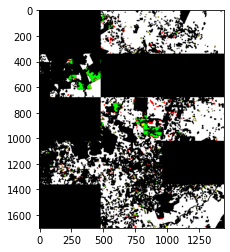

In [ ]:
metrics_params_cerrado['save_result_text'] = True
metrics_params_cerrado['results_dir'] =   test_dir_da_target_cerrado
main_compute_metrics(args = parse_params(metrics_params_cerrado))

In [ ]:
metrics_params_cerrado['save_result_text'] = False
metrics_params_cerrado['Npoints'] = 10  
main_compute_metrics_multi_threshold(args = parse_params(metrics_params_cerrado))

Arguments for Compute Metrics Multi Threshold: 
Namespace(Npoints=10, area_avoided=69, buffer=True, buffer_dimension_in=0, buffer_dimension_out=2, checkpoint_dir='20201216_01_Resnet18_classification_Train_Cerrado', compute_ndvi=False, data_t1_name='18_08_2017_image_R220_63_MA', data_t1_year='2017', data_t2_name='21_08_2018_image_R220_63_MA', data_t2_year='2018', data_type='.npy', dataset='Cerrado_MA', dataset_main_path='Datasets/', defined_before=False, eliminate_regions=True, file='/root/.local/share/jupyter/runtime/kernel-d1d578bd-3752-401f-a779-480f925a3a03.json', fixed_tiles=True, horizontal_blocks=5, images_section='Organized/Images/', method_type='DeepLab', overlap=0.75, patches_dimension=64, phase='compute_metrics', reference_section='Organized/References/', reference_t1_name='PAST_REFERENCE_FOR_2018_EPSG4674_R220_63_MA', reference_t2_name='REFERENCE_2018_EPSG4674_R220_63_MA', results_dir='20201216_02_Resnet18_DA_Test_Source_Amazon_Target_Cerrado', save_result_text=False, traini

In [ ]:
results_folders = [] 
results_folders.append('./results/'+ test_dir_amazon_amazon + '/')
results_folders.append('./results/'+ test_dir_amazon_cerrado + '/')
results_folders.append('./results/'+ test_dir_da_target_cerrado + '/')

create_precision_recall_curve(results_folders, num_samples = 10,source_domain='AMAZON_RO',target_domain='CERRADO_MA',figsize=(12,8))

## Domain Adaptation - S:Cerrado T:Amazon

In [ ]:
train_dir_da_amazon_to_cerrado = '20201216_02_Resnet18_DA_Source_Amazon_Target_Cerrado'
train_dir_da_cerrado_to_amazon = '20201216_02_Resnet18_DA_Source_Cerrado_Target_Amazon'

test_dir_da_target_cerrado = '20201216_02_Resnet18_DA_Test_Source_Amazon_Target_Cerrado'
test_dir_da_target_amazon = '20201216_02_Resnet18_DA_Test_Source_Cerrado_Target_Amazon'

train_params_cerrado['training_type'] = 'domain_adaptation'
train_params_cerrado['checkpoint_dir'] = train_dir_da_cerrado_to_amazon

main_train(args = parse_params(train_params_cerrado))

Arguments for Train: 
Namespace(aspp_rates=[3, 6, 12], balanced_tr=True, base_architecture='resnet_v2_18', batch_norm_decay=0.9, batch_size=32, beta1=0.9, buffer=True, checkpoint_dir='20201216_02_Resnet18_DA_Source_Cerrado_Target_Amazon', compute_ndvi=False, data_augmentation=True, data_type='.npy', dataset_main_path='Datasets/', defined_before=False, epochs=50, file='/root/.local/share/jupyter/runtime/kernel-d1d578bd-3752-401f-a779-480f925a3a03.json', fixed_tiles=True, image_channels=7, images_section='Organized/Images/', is_training=True, loss_alpha=0.1, loss_gamma=2, loss_type='', lr=0.0001, method_type='DeepLab', num_classes=2, overlap_s=0.75, overlap_t=0.75, patches_dimension=64, patience=10, phase='train', porcent_of_last_reference_in_actual_reference=100, porcent_of_positive_pixels_in_actual_reference_s=1, porcent_of_positive_pixels_in_actual_reference_t=1, reference_section='Organized/References/', resnet_type='simple', runs=1, save_intermediate_model=False, source_buffer_dimen

  0%|          | 0/325 [00:00<?, ?it/s]

epochs percentage: 0.0
lambda_p: 0.0


  0%|          | 0/149 [00:00<?, ?it/s]

326
0 [Training loss: 0.028222, acc.: 91.55%, precission: 65.84%, recall: 94.44%, f1: 76.50%, Dr loss: 0.332417]
[*]Computing the validation loss...


  0%|          | 0/325 [00:00<?, ?it/s]


 0 [Validation loss: 0.038621, acc.: 89.95%,  precission: 54.61%, recall: 92.86%, f1: 67.56%, DrV loss: 0.005581]

epochs percentage: 0.02
lambda_p: 0.049958374957880025


  1%|▏         | 2/149 [00:00<00:10, 13.68it/s]

326
1 [Training loss: 0.014126, acc.: 95.79%, precission: 75.71%, recall: 97.65%, f1: 84.86%, Dr loss: 0.818123]
[*]Computing the validation loss...


  0%|          | 1/325 [00:00<00:34,  9.36it/s]


 1 [Validation loss: 0.069016, acc.: 90.97%,  precission: 58.66%, recall: 84.16%, f1: 67.89%, DrV loss: 0.005363]

epochs percentage: 0.04
lambda_p: 0.0996679946249559


  1%|▏         | 2/149 [00:00<00:09, 16.32it/s]

326
2 [Training loss: 0.010965, acc.: 96.57%, precission: 79.15%, recall: 98.41%, f1: 87.43%, Dr loss: 0.708733]
[*]Computing the validation loss...


  0%|          | 1/325 [00:00<00:32,  9.85it/s]


 2 [Validation loss: 0.071828, acc.: 93.16%,  precission: 66.26%, recall: 85.43%, f1: 73.91%, DrV loss: 0.004736]

epochs percentage: 0.06
lambda_p: 0.14888503362331806


  1%|▏         | 2/149 [00:00<00:09, 16.28it/s]

326
3 [Training loss: 0.010174, acc.: 96.79%, precission: 79.93%, recall: 98.57%, f1: 88.02%, Dr loss: 0.742556]
[*]Computing the validation loss...


  1%|          | 2/325 [00:00<00:27, 11.59it/s]


 3 [Validation loss: 0.099943, acc.: 95.08%,  precission: 77.10%, recall: 81.43%, f1: 78.69%, DrV loss: 0.004768]

epochs percentage: 0.08
lambda_p: 0.197375320224904


  1%|▏         | 2/149 [00:00<00:09, 16.27it/s]

326
4 [Training loss: 0.010201, acc.: 96.86%, precission: 80.61%, recall: 98.64%, f1: 88.43%, Dr loss: 0.708316]
[*]Computing the validation loss...


  1%|          | 2/325 [00:00<00:29, 10.84it/s]


 4 [Validation loss: 0.041684, acc.: 93.96%,  precission: 67.18%, recall: 91.42%, f1: 76.78%, DrV loss: 0.004087]

epochs percentage: 0.1
lambda_p: 0.2449186624037092


  1%|▏         | 2/149 [00:00<00:08, 17.89it/s]

326
5 [Training loss: 0.008317, acc.: 97.49%, precission: 83.60%, recall: 98.83%, f1: 90.36%, Dr loss: 0.696282]
[*]Computing the validation loss...


  0%|          | 1/325 [00:00<00:32,  9.96it/s]


 5 [Validation loss: 0.118277, acc.: 93.95%,  precission: 71.66%, recall: 79.15%, f1: 74.53%, DrV loss: 0.004701]

---------------------------------------
[!] Best Validation F1 score: %.2f%% 74.52621653548293
---------------------------------------
epochs percentage: 0.12
lambda_p: 0.2913126124515908


  1%|▏         | 2/149 [00:00<00:09, 15.93it/s]

326
6 [Training loss: 0.006089, acc.: 98.08%, precission: 86.95%, recall: 99.26%, f1: 92.58%, Dr loss: 0.696435]
[*]Computing the validation loss...


  0%|          | 1/325 [00:00<00:36,  8.91it/s]


 6 [Validation loss: 0.135221, acc.: 94.01%,  precission: 71.96%, recall: 78.41%, f1: 74.38%, DrV loss: 0.004777]

epochs percentage: 0.14
lambda_p: 0.3363755443363323


  1%|▏         | 2/149 [00:00<00:09, 15.85it/s]

326
7 [Training loss: 0.006802, acc.: 97.88%, precission: 85.96%, recall: 99.14%, f1: 91.93%, Dr loss: 0.694718]
[*]Computing the validation loss...


  0%|          | 1/325 [00:00<00:33,  9.57it/s]


 7 [Validation loss: 0.114434, acc.: 93.06%,  precission: 67.12%, recall: 80.10%, f1: 72.01%, DrV loss: 0.004726]

epochs percentage: 0.16
lambda_p: 0.379948962255225


  1%|▏         | 2/149 [00:00<00:10, 14.58it/s]

326
8 [Training loss: 0.005310, acc.: 98.34%, precission: 88.53%, recall: 99.34%, f1: 93.53%, Dr loss: 0.696225]
[*]Computing the validation loss...


  1%|          | 2/325 [00:00<00:28, 11.45it/s]


 8 [Validation loss: 0.162788, acc.: 94.21%,  precission: 74.88%, recall: 77.97%, f1: 75.58%, DrV loss: 0.004626]

---------------------------------------
[!] Best Validation F1 score: %.2f%% 75.58126766185994
---------------------------------------
epochs percentage: 0.18
lambda_p: 0.4218990052500078


  1%|▏         | 2/149 [00:00<00:09, 15.10it/s]

326
9 [Training loss: 0.003944, acc.: 98.75%, precission: 90.87%, recall: 99.55%, f1: 94.95%, Dr loss: 0.694161]
[*]Computing the validation loss...


  0%|          | 1/325 [00:00<00:34,  9.41it/s]


 9 [Validation loss: 0.105722, acc.: 93.49%,  precission: 68.54%, recall: 80.28%, f1: 73.04%, DrV loss: 0.004618]

epochs percentage: 0.2
lambda_p: 0.4621171572600098


  1%|▏         | 2/149 [00:00<00:08, 16.49it/s]

326
10 [Training loss: 0.005017, acc.: 98.45%, precission: 89.10%, recall: 99.34%, f1: 93.80%, Dr loss: 0.693848]
[*]Computing the validation loss...


  0%|          | 0/325 [00:00<?, ?it/s]


 10 [Validation loss: 0.135798, acc.: 94.60%,  precission: 76.03%, recall: 77.04%, f1: 76.10%, DrV loss: 0.004550]

---------------------------------------
[!] Best Validation F1 score: %.2f%% 76.10439285282324
---------------------------------------
epochs percentage: 0.22
lambda_p: 0.5005202111902354


  1%|▏         | 2/149 [00:00<00:08, 16.54it/s]

326
11 [Training loss: 0.003188, acc.: 98.99%, precission: 92.65%, recall: 99.63%, f1: 95.98%, Dr loss: 0.695274]
[*]Computing the validation loss...


  1%|          | 2/325 [00:00<00:29, 11.01it/s]


 11 [Validation loss: 0.132191, acc.: 93.88%,  precission: 71.89%, recall: 78.21%, f1: 74.49%, DrV loss: 0.004490]

epochs percentage: 0.24
lambda_p: 0.5370495669980351


  1%|▏         | 2/149 [00:00<00:08, 16.35it/s]

326
12 [Training loss: 0.004124, acc.: 98.69%, precission: 90.38%, recall: 99.48%, f1: 94.59%, Dr loss: 0.694777]
[*]Computing the validation loss...


  1%|          | 2/325 [00:00<00:30, 10.64it/s]


 12 [Validation loss: 0.201540, acc.: 94.89%,  precission: 81.00%, recall: 74.01%, f1: 76.96%, DrV loss: 0.004574]

---------------------------------------
[!] Best Validation F1 score: %.2f%% 76.95614509364123
---------------------------------------
epochs percentage: 0.26
lambda_p: 0.5716699660851172


  1%|▏         | 2/149 [00:00<00:08, 16.65it/s]

326
13 [Training loss: 0.002398, acc.: 99.23%, precission: 94.23%, recall: 99.74%, f1: 96.88%, Dr loss: 0.694543]
[*]Computing the validation loss...


  0%|          | 1/325 [00:00<00:33,  9.78it/s]


 13 [Validation loss: 0.202545, acc.: 94.91%,  precission: 80.70%, recall: 72.89%, f1: 76.20%, DrV loss: 0.004727]

epochs percentage: 0.28
lambda_p: 0.6043677771171636


  1%|▏         | 2/149 [00:00<00:09, 15.72it/s]

326
14 [Training loss: 0.002508, acc.: 99.21%, precission: 94.06%, recall: 99.72%, f1: 96.74%, Dr loss: 0.694136]
[*]Computing the validation loss...


  0%|          | 0/325 [00:00<?, ?it/s]


 14 [Validation loss: 0.173871, acc.: 94.49%,  precission: 76.37%, recall: 75.97%, f1: 75.73%, DrV loss: 0.004668]

epochs percentage: 0.3
lambda_p: 0.6351489523872873


  1%|▏         | 2/149 [00:00<00:10, 14.02it/s]

326
15 [Training loss: 0.002836, acc.: 99.12%, precission: 93.63%, recall: 99.68%, f1: 96.51%, Dr loss: 0.696193]
[*]Computing the validation loss...


  0%|          | 1/325 [00:00<00:32,  9.88it/s]


 15 [Validation loss: 0.200217, acc.: 94.77%,  precission: 79.42%, recall: 74.54%, f1: 76.51%, DrV loss: 0.004644]

epochs percentage: 0.32
lambda_p: 0.6640367702678489


  1%|▏         | 2/149 [00:00<00:09, 14.91it/s]

326
16 [Training loss: 0.001645, acc.: 99.47%, precission: 95.94%, recall: 99.83%, f1: 97.83%, Dr loss: 0.694165]
[*]Computing the validation loss...


  1%|          | 2/325 [00:00<00:30, 10.66it/s]


 16 [Validation loss: 0.243486, acc.: 94.63%,  precission: 80.09%, recall: 71.98%, f1: 75.34%, DrV loss: 0.004604]

epochs percentage: 0.34
lambda_p: 0.6910694698329305


  1%|▏         | 2/149 [00:00<00:11, 12.75it/s]

326
17 [Training loss: 0.001300, acc.: 99.58%, precission: 96.70%, recall: 99.87%, f1: 98.25%, Dr loss: 0.694040]
[*]Computing the validation loss...


  1%|          | 2/325 [00:00<00:31, 10.29it/s]


 17 [Validation loss: 0.223214, acc.: 94.78%,  precission: 79.31%, recall: 74.28%, f1: 76.08%, DrV loss: 0.004436]

epochs percentage: 0.36
lambda_p: 0.7162978701990246


  1%|▏         | 2/149 [00:00<00:08, 17.77it/s]

326
18 [Training loss: 0.001763, acc.: 99.44%, precission: 95.67%, recall: 99.80%, f1: 97.67%, Dr loss: 0.694294]
[*]Computing the validation loss...


  0%|          | 1/325 [00:00<00:37,  8.68it/s]


 18 [Validation loss: 0.247067, acc.: 94.87%,  precission: 82.30%, recall: 70.76%, f1: 75.66%, DrV loss: 0.004652]

epochs percentage: 0.38
lambda_p: 0.7397830512740042


  1%|▏         | 2/149 [00:00<00:08, 17.07it/s]

326
19 [Training loss: 0.001312, acc.: 99.58%, precission: 96.66%, recall: 99.87%, f1: 98.23%, Dr loss: 0.693731]
[*]Computing the validation loss...


  0%|          | 1/325 [00:00<00:37,  8.63it/s]


 19 [Validation loss: 0.282438, acc.: 94.38%,  precission: 78.49%, recall: 69.86%, f1: 73.31%, DrV loss: 0.004509]

epochs percentage: 0.4
lambda_p: 0.7615941559557646


  1%|▏         | 2/149 [00:00<00:08, 16.76it/s]

326
20 [Training loss: 0.001649, acc.: 99.49%, precission: 96.10%, recall: 99.81%, f1: 97.90%, Dr loss: 0.694821]
[*]Computing the validation loss...


  0%|          | 0/325 [00:00<?, ?it/s]


 20 [Validation loss: 0.159014, acc.: 94.81%,  precission: 77.88%, recall: 75.83%, f1: 76.46%, DrV loss: 0.004533]

epochs percentage: 0.42
lambda_p: 0.7818063576087741


  1%|▏         | 2/149 [00:00<00:09, 16.24it/s]

326
21 [Training loss: 0.003987, acc.: 98.84%, precission: 92.19%, recall: 99.46%, f1: 95.55%, Dr loss: 0.694621]
[*]Computing the validation loss...


  0%|          | 0/325 [00:00<?, ?it/s]


 21 [Validation loss: 0.229568, acc.: 94.38%,  precission: 78.17%, recall: 72.74%, f1: 74.82%, DrV loss: 0.004545]

epochs percentage: 0.44
lambda_p: 0.8004990217606296


  1%|▏         | 2/149 [00:00<00:08, 16.57it/s]

326
22 [Training loss: 0.001061, acc.: 99.65%, precission: 97.27%, recall: 99.90%, f1: 98.56%, Dr loss: 0.694211]
[*]Computing the validation loss...


  1%|          | 2/325 [00:00<00:28, 11.28it/s]


 22 [Validation loss: 0.256428, acc.: 94.67%,  precission: 80.17%, recall: 72.64%, f1: 75.67%, DrV loss: 0.004742]

epochs percentage: 0.46
lambda_p: 0.8177540779702877


  1%|▏         | 2/149 [00:00<00:09, 15.36it/s]

326
23 [Training loss: 0.005650, acc.: 98.55%, precission: 91.00%, recall: 99.28%, f1: 94.71%, Dr loss: 0.695286]
[*]Computing the validation loss...


  0%|          | 1/325 [00:00<00:33,  9.67it/s]


 23 [Validation loss: 0.169786, acc.: 94.90%,  precission: 79.31%, recall: 75.91%, f1: 77.07%, DrV loss: 0.004636]

---------------------------------------
[!] Best Validation F1 score: %.2f%% 77.07129684091751
---------------------------------------
epochs percentage: 0.48
lambda_p: 0.8336546070121553


  1%|▏         | 2/149 [00:00<00:09, 15.04it/s]

326
24 [Training loss: 0.001769, acc.: 99.42%, precission: 95.44%, recall: 99.82%, f1: 97.56%, Dr loss: 0.694360]
[*]Computing the validation loss...


  1%|          | 2/325 [00:00<00:31, 10.39it/s]


 24 [Validation loss: 0.242053, acc.: 94.32%,  precission: 78.30%, recall: 72.77%, f1: 74.88%, DrV loss: 0.004612]

epochs percentage: 0.5
lambda_p: 0.8482836399575131


  1%|▏         | 2/149 [00:00<00:09, 16.18it/s]

326
25 [Training loss: 0.000995, acc.: 99.67%, precission: 97.44%, recall: 99.90%, f1: 98.65%, Dr loss: 0.693457]
[*]Computing the validation loss...


  1%|          | 2/325 [00:00<00:29, 10.86it/s]


 25 [Validation loss: 0.272087, acc.: 93.05%,  precission: 70.32%, recall: 71.14%, f1: 69.99%, DrV loss: 0.004704]

epochs percentage: 0.52
lambda_p: 0.8617231593133066


  1%|▏         | 2/149 [00:00<00:09, 16.28it/s]

326
26 [Training loss: 0.005093, acc.: 98.51%, precission: 89.81%, recall: 99.23%, f1: 94.13%, Dr loss: 0.697054]
[*]Computing the validation loss...


  0%|          | 0/325 [00:00<?, ?it/s]


 26 [Validation loss: 0.159706, acc.: 95.17%,  precission: 79.00%, recall: 77.21%, f1: 77.81%, DrV loss: 0.004801]

---------------------------------------
[!] Best Validation F1 score: %.2f%% 77.80726968323543
---------------------------------------
epochs percentage: 0.54
lambda_p: 0.874053287886007


  1%|▏         | 2/149 [00:00<00:08, 16.46it/s]

326
27 [Training loss: 0.001736, acc.: 99.44%, precission: 95.74%, recall: 99.80%, f1: 97.71%, Dr loss: 0.694166]
[*]Computing the validation loss...


  0%|          | 1/325 [00:00<00:33,  9.76it/s]


 27 [Validation loss: 0.168025, acc.: 95.18%,  precission: 79.25%, recall: 77.98%, f1: 78.34%, DrV loss: 0.004726]

---------------------------------------
[!] Best Validation F1 score: %.2f%% 78.34356910296718
---------------------------------------
epochs percentage: 0.56
lambda_p: 0.8853516482022625


  1%|▏         | 2/149 [00:00<00:08, 18.15it/s]

326
28 [Training loss: 0.001226, acc.: 99.60%, precission: 96.89%, recall: 99.87%, f1: 98.35%, Dr loss: 0.693765]
[*]Computing the validation loss...


  1%|          | 2/325 [00:00<00:30, 10.50it/s]


 28 [Validation loss: 0.190765, acc.: 96.07%,  precission: 84.83%, recall: 77.90%, f1: 80.99%, DrV loss: 0.004659]

---------------------------------------
[!] Best Validation F1 score: %.2f%% 80.987092671231
---------------------------------------
epochs percentage: 0.58
lambda_p: 0.8956928738431646


  1%|▏         | 2/149 [00:00<00:08, 17.01it/s]

326
29 [Training loss: 0.001217, acc.: 99.62%, precission: 97.15%, recall: 99.86%, f1: 98.48%, Dr loss: 0.694159]
[*]Computing the validation loss...


  0%|          | 1/325 [00:00<00:36,  8.93it/s]


 29 [Validation loss: 0.224260, acc.: 95.15%,  precission: 83.27%, recall: 72.12%, f1: 76.92%, DrV loss: 0.004635]

epochs percentage: 0.6
lambda_p: 0.9051482536448667


  1%|▏         | 2/149 [00:00<00:08, 16.89it/s]

326
30 [Training loss: 0.001155, acc.: 99.64%, precission: 97.19%, recall: 99.88%, f1: 98.51%, Dr loss: 0.694266]
[*]Computing the validation loss...


  0%|          | 0/325 [00:00<?, ?it/s]


 30 [Validation loss: 0.245551, acc.: 95.61%,  precission: 83.38%, recall: 74.43%, f1: 78.38%, DrV loss: 0.004824]

epochs percentage: 0.62
lambda_p: 0.9137854901178277


  1%|▏         | 2/149 [00:00<00:09, 15.35it/s]

326
31 [Training loss: 0.002942, acc.: 99.16%, precission: 93.88%, recall: 99.59%, f1: 96.55%, Dr loss: 0.695009]
[*]Computing the validation loss...


  0%|          | 1/325 [00:00<00:32,  9.90it/s]


 31 [Validation loss: 0.192253, acc.: 95.40%,  precission: 82.40%, recall: 75.31%, f1: 78.33%, DrV loss: 0.004635]

epochs percentage: 0.64
lambda_p: 0.9216685544064713


  1%|▏         | 2/149 [00:00<00:09, 15.89it/s]

326
32 [Training loss: 0.001559, acc.: 99.50%, precission: 96.13%, recall: 99.82%, f1: 97.93%, Dr loss: 0.693949]
[*]Computing the validation loss...


  1%|          | 2/325 [00:00<00:31, 10.27it/s]


 32 [Validation loss: 0.196484, acc.: 94.70%,  precission: 77.62%, recall: 75.72%, f1: 76.19%, DrV loss: 0.004757]

epochs percentage: 0.66
lambda_p: 0.9288576214547277


  1%|▏         | 2/149 [00:00<00:08, 16.62it/s]

326
33 [Training loss: 0.001912, acc.: 99.42%, precission: 95.68%, recall: 99.76%, f1: 97.65%, Dr loss: 0.695836]
[*]Computing the validation loss...


  1%|          | 2/325 [00:00<00:30, 10.60it/s]


 33 [Validation loss: 0.186293, acc.: 94.44%,  precission: 75.71%, recall: 75.00%, f1: 74.86%, DrV loss: 0.004806]

epochs percentage: 0.68
lambda_p: 0.9354090706030991


  1%|▏         | 2/149 [00:00<00:09, 16.00it/s]

326
34 [Training loss: 0.001036, acc.: 99.67%, precission: 97.42%, recall: 99.90%, f1: 98.64%, Dr loss: 0.694000]
[*]Computing the validation loss...


  0%|          | 1/325 [00:00<00:33,  9.72it/s]


 34 [Validation loss: 0.241480, acc.: 95.05%,  precission: 81.20%, recall: 73.48%, f1: 76.78%, DrV loss: 0.004651]

epochs percentage: 0.7
lambda_p: 0.9413755384972873


  1%|▏         | 2/149 [00:00<00:09, 15.08it/s]

326
35 [Training loss: 0.001078, acc.: 99.66%, precission: 97.44%, recall: 99.88%, f1: 98.63%, Dr loss: 0.694303]
[*]Computing the validation loss...


  0%|          | 0/325 [00:00<?, ?it/s]


 35 [Validation loss: 0.273277, acc.: 94.28%,  precission: 78.38%, recall: 72.18%, f1: 74.53%, DrV loss: 0.004627]

epochs percentage: 0.72
lambda_p: 0.9468060128462681


  1%|▏         | 2/149 [00:00<00:08, 16.98it/s]

326
36 [Training loss: 0.001159, acc.: 99.64%, precission: 97.15%, recall: 99.88%, f1: 98.49%, Dr loss: 0.694104]
[*]Computing the validation loss...


  0%|          | 1/325 [00:00<00:36,  8.82it/s]


 36 [Validation loss: 0.241243, acc.: 92.63%,  precission: 67.13%, recall: 75.38%, f1: 70.07%, DrV loss: 0.004627]

epochs percentage: 0.74
lambda_p: 0.9517459571646616


  1%|▏         | 2/149 [00:00<00:10, 14.25it/s]

326
37 [Training loss: 0.000718, acc.: 99.77%, precission: 98.17%, recall: 99.93%, f1: 99.04%, Dr loss: 0.693720]
[*]Computing the validation loss...


  0%|          | 1/325 [00:00<00:34,  9.50it/s]


 37 [Validation loss: 0.224613, acc.: 92.52%,  precission: 65.91%, recall: 77.03%, f1: 70.19%, DrV loss: 0.004594]

epochs percentage: 0.76
lambda_p: 0.9562374581277389


  1%|▏         | 2/149 [00:00<00:08, 17.89it/s]

326
38 [Training loss: 0.001000, acc.: 99.68%, precission: 97.48%, recall: 99.89%, f1: 98.66%, Dr loss: 0.693743]
[*]Computing the validation loss...


  0%|          | 1/325 [00:00<00:33,  9.81it/s]


 38 [Validation loss: 0.257319, acc.: 94.82%,  precission: 81.08%, recall: 72.15%, f1: 75.85%, DrV loss: 0.004479]

epochs percentage: 0.78
lambda_p: 0.9603193885318451


  1%|▏         | 2/149 [00:00<00:07, 18.48it/s]

326
39 [Training loss: 0.001726, acc.: 99.49%, precission: 96.14%, recall: 99.79%, f1: 97.91%, Dr loss: 0.693974]
[*]Computing the validation loss...


100%|██████████| 149/149 [00:09<00:00, 16.07it/s]



 39 [Validation loss: 0.220912, acc.: 95.41%,  precission: 83.73%, recall: 74.60%, f1: 78.54%, DrV loss: 0.004587]

Patience limit reachead. Exiting training...
---------------------------------------
Training ended
[!] Best Validation F1 score: %.2f%% 80.987092671231
Saving the best model
Checkpoint Saved with SUCCESS!


In [ ]:
test_params_amazon['results_dir'] = test_dir_da_target_amazon
test_params_amazon['checkpoint_dir'] = train_dir_da_cerrado_to_amazon

main_test(args = parse_params(test_params_amazon))

Arguments for Test run: 
Namespace(area_avoided=69, aspp_rates=[3, 6, 12], base_architecture='resnet_v2_18', batch_norm_decay=0.9, batch_size=32, buffer=False, buffer_dimension_in=0, buffer_dimension_out=2, checkpoint_dir='20201216_02_Resnet18_DA_Source_Cerrado_Target_Amazon', compute_ndvi=False, data_t1_name='18_07_2016_image_R232_67_RO', data_t1_year='2016', data_t2_name='21_07_2017_image_R232_67_RO', data_t2_year='2017', data_type='.npy', dataset='Amazon_RO', dataset_main_path='Datasets/', defined_before=False, eliminate_regions=True, file='/root/.local/share/jupyter/runtime/kernel-d1d578bd-3752-401f-a779-480f925a3a03.json', fixed_tiles=True, horizontal_blocks=10, image_channels=7, images_section='Organized/Images/', loss_alpha=0.1, loss_gamma=2, loss_type='', method_type='DeepLab', num_classes=2, overlap=0.75, patches_dimension=64, phase='test', reference_section='Organized/References/', reference_t1_name='PAST_REFERENCE_FOR_2017_EPSG32620_R232_67_RO', reference_t2_name='REFERENCE_

  0%|          | 1/1600 [00:00<03:48,  6.99it/s]

1600


100%|██████████| 1600/1600 [00:26<00:00, 59.66it/s]


(2550, 5120)


Arguments for Compute Metrics: 
Namespace(area_avoided=69, buffer=True, buffer_dimension_in=2, buffer_dimension_out=4, checkpoint_dir='20201216_01_Resnet18_classification_Train_Amazon', compute_ndvi=False, data_t1_name='18_07_2016_image_R232_67_RO', data_t1_year='2016', data_t2_name='21_07_2017_image_R232_67_RO', data_t2_year='2017', data_type='.npy', dataset='Amazon_RO', dataset_main_path='Datasets/', defined_before=False, eliminate_regions=True, file='/root/.local/share/jupyter/runtime/kernel-d1d578bd-3752-401f-a779-480f925a3a03.json', fixed_tiles=True, horizontal_blocks=10, images_section='Organized/Images/', method_type='DeepLab', overlap=0.75, patches_dimension=64, phase='compute_metrics', reference_section='Organized/References/', reference_t1_name='PAST_REFERENCE_FOR_2017_EPSG32620_R232_67_RO', reference_t2_name='REFERENCE_2017_EPSG32620_R232_67_RO', results_dir='20201216_02_Resnet18_DA_Test_Source_Cerrado_Target_Amazon', save_result_text=True, training_type='classification', ve

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


52.96880733944954
Accuracy
[[96.6054018]]
Fscore
[[52.96880734]]
Recall
[[42.44245539]]
Precision
[[70.43861875]]
Confusion matrix
[[1787540.   15144.]
 [  48936.   36085.]]
Alert_area
[[2.71382446]]
[96.60540179742068]
------------------------------------------------------------------------------------
Mean: 0 Accuracy: 96.605402% F1-Score: 52.968807% Recall: 42.442455% Precision: 70.438619% Area: 2.713824%

Std: 0 Accuracy: 0.00% F1-Score: 0.00% Recall: 0.00% Precision: 0.00% Area: 0.00%

------------------------------------------------------------------------------------


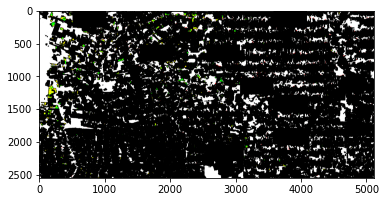

In [ ]:
metrics_params_amazon['save_result_text'] = True
metrics_params_amazon['results_dir'] = test_dir_da_target_amazon
main_compute_metrics(args = parse_params(metrics_params_amazon))

In [ ]:
metrics_params_amazon['save_result_text'] = False
metrics_params_amazon['Npoints'] = 10  
main_compute_metrics_multi_threshold(args = parse_params(metrics_params_amazon))

Arguments for Compute Metrics Multi Threshold: 
Namespace(Npoints=10, area_avoided=69, buffer=True, buffer_dimension_in=2, buffer_dimension_out=4, checkpoint_dir='20201216_01_Resnet18_classification_Train_Amazon', compute_ndvi=False, data_t1_name='18_07_2016_image_R232_67_RO', data_t1_year='2016', data_t2_name='21_07_2017_image_R232_67_RO', data_t2_year='2017', data_type='.npy', dataset='Amazon_RO', dataset_main_path='Datasets/', defined_before=False, eliminate_regions=True, file='/root/.local/share/jupyter/runtime/kernel-d1d578bd-3752-401f-a779-480f925a3a03.json', fixed_tiles=True, horizontal_blocks=10, images_section='Organized/Images/', method_type='DeepLab', overlap=0.75, patches_dimension=64, phase='compute_metrics', reference_section='Organized/References/', reference_t1_name='PAST_REFERENCE_FOR_2017_EPSG32620_R232_67_RO', reference_t2_name='REFERENCE_2017_EPSG32620_R232_67_RO', results_dir='20201216_02_Resnet18_DA_Test_Source_Cerrado_Target_Amazon', save_result_text=False, train

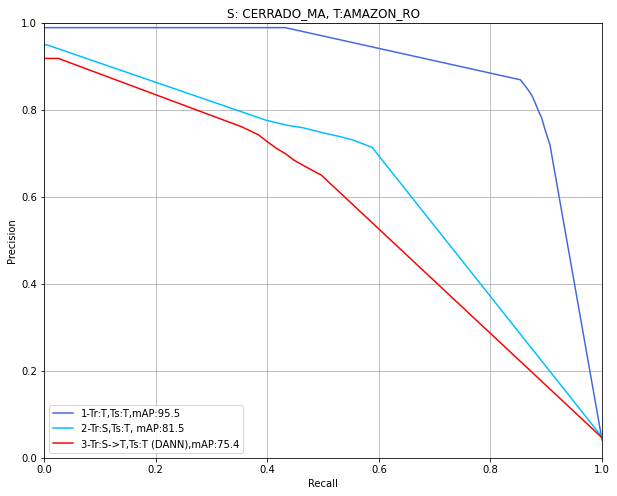

In [ ]:
results_folders = []
results_folders.append('./results/'+test_dir_cerrado_cerrado + '/')
results_folders.append('./results/'+test_dir_cerrado_amazon + '/')
results_folders.append('./results/'+ test_dir_da_target_amazon + '/')

create_precision_recall_curve(results_folders, num_samples = 10,source_domain='CERRADO_MA',target_domain='AMAZON_RO')